# Analyse dsync Notebook

## Abstract

Dans le cadre du projet d'analyse de la désynchronisation dans l'immprovisation musicale ...

## Experiments

The experiments were carried out over 3 sessions *data-yyyy-mm-dd*, with each session corresponding to a series of experiments *n__d_yyyy_mm_dd_t_hh_mm_ss*. 
There are 6 musicians, and each musician participating in the experiment has 2 acquisition devices (**riots**), one always on the head and the other on the arm or leg, depending on the session. There are therefore a total of 12 acquisition devices in an experiment. In addition, a trial (experiment) has 2 factors (or conditions)  

An acquisition device has :

* 3 sensors: accelerometer (**acc**) gyroscope (**gyro**) and magnetometer (**mag**) on 3 axes each
* 3 metrics : 
  **orientation** on 3 axes, device angle relative to gravitational axis
  * filtered acceleration (**accfilt**) on 3 axes, low-pass filter (~10 Hz) for accelerometer data to eliminate unwanted micro-variations
  **intensity**, normalization of the quantity of motion, "softened" representation of the recorded motion

There are therefore a total of 16 metrics per device per musician.

a sound file of the performance; depending on the session, this includes the sound of one or more metronomes, the sound "changes".

a video of the performance

a *riots-musicians.txt* file associating each riot with a musician and its type 

a *trials-info.txt* file associating the conditions of each experiment

A session also includes calibration recordings, improvisations and tests.

Translated with DeepL.com (free version)

## Datas

Stored in *.txt* format for each riot, sampled at 10ms, the data includes :

| Time Stamp | acc_x | acc_y | acc_z | gyro_x | gyro_y | gyro_z | mag_x | mag_y | mag_z | orientation_x | orientation_y | orientation_z | accfilt_x | accfilt_y | accfilt_z | intensity |
| ---------- | ----- | ----- | ----- | ------ | ------ | ------ | ----- | ----- | ----- | ------------- | ------------- | ------------- | --------- | --------- | --------- | --------- |

Data must be truncated in time, as they include biased data before and after performance.

## Code 

### Imports

#### Data Manipulation and Analysis

1.  **Numpy (`import numpy as np`)**: A fundamental package for numerical computing in Python.
    
2.  **Pandas (`import pandas as pd`)**: A library providing high-performance, easy-to-use data structures, and data analysis tools.

#### Data Visualization

1.  **Matplotlib (`import matplotlib.pyplot as plt`)**: A comprehensive library for creating static, interactive, and animated visualizations in Python.
    
2.  **Seaborn (`import seaborn as sns`)**: A statistical data visualization library based on Matplotlib.
    

#### Audio Processing

1.  **Librosa (`import librosa`, `import librosa.display`)**: A Python package for music and audio analysis.
    
2.  **SciPy (`from scipy import signal`, `import scipy as sp`)**: An open-source Python library used for scientific and technical computing. The `signal` module is specifically used for signal processing tasks, such as filtering or convolution.
    

#### File and System Operations

1.  **Glob (`import glob`)**: A module that finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
    
2.  **OS (`import os`)**: Provides a way of using operating system-dependent functionality.
    
3.  **Pickle (`import pickle`)**: Implements binary protocols for serializing and de-serializing a Python object structure.
    

#### Memory Management

1.   **Garbage Collector (`import gc`)**: Provides an interface to the garbage collector for Python objects.

#### Interactive Widgets and Displays

1.   **IPyWidgets (`import ipywidgets as widgets`, `from ipywidgets import interact, interactive, fixed, interact_manual`)**: Provides interactive HTML widgets for Jupyter notebooks. 
    
2.   **IPython Display (`from IPython.display import Audio, display, clear_output`)**: Facilitates rich media representation in Jupyter notebooks.
    
3.   **Regular Expressions (`import re`)**: Provides regular expression matching operations similar to those found in Perl.
    
4.   **Matplotlib Scale (`from matplotlib import scale`)**: While this specific import is unusual (as scales are typically used as part of plots directly), it might be aimed at customizing the scale of an axis in a plot.

### Data structures

Data structures must have a scalable organization, optimized to avoid redundancy and to speed up searching; the structure is "trivial" for other, lower-level programming languages.
Data structures can be organized as follows:

* class Session:
    * date: string (date)
    * experiences: dict of Experience (from 1 to 24 or 32 (number of trials))

* class Experience:
    * time: string (time)
    * number: int
    * musician_riots: dictionary { musician: (riot_head, riot_limb) }
    * riots: dict of Riot (instead of list)
    * factors: tuple of string ('same' | 'close' | 'high' | 'low' ,'Yes' | 'No' | 'All' | musician)

* class Riot:
    * dataset: dict Dataset (instead of list, from 0 to N)
    * duration : float
    * trunc: (start: float, end: float)
    * riot_type: "arm" | "leg" | "head"

* class Dataset:
    * t: float
    * acc_x: float
    * acc_y: float
    * acc_z: float
    * gyro_x: float
    * gyro_y: float
    * gyro_z: float
    * mag_x: float
    * mag_y: float
    * mag_z: float
    * orientation_x: float
    * orientation_y: float
    * orientation_z: float
    * accfilt_x: float
    * accfilt_y: float
    * accfilt_z: float
    * intensity: float

In [1]:
#imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")
# sns.color_palette(palette="colorblind")

import scipy as sp
from scipy.stats import zscore
from scipy import signal
from scipy.signal import hilbert,hilbert2
# from scipy.ndimage import shift
from scipy.fft import fft,fftfreq
# from scipy.fftpack import *
import librosa
import librosa.display
import pycwt as wavelet #wavelet
import pywt
from dtw import *
from functools import partial





import glob
import os
import sys
import pickle

import gc
import re

import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Audio, display, clear_output

def import_external():
    global Coherence,PeakDetect

    sys.path.insert(0, '../libs/python/SyncPy/src/')   # To be able to import packages from parent directory
    sys.path.insert(0, '../libs/python/SyncPy/src/Methods')
    sys.path.insert(0, '../libs/python/SyncPy/src/Methods/utils')  

    from DataFrom2Persons.Univariate.Continuous.Linear import Coherence

    import utils.Standardize
    from utils.ExtractSignal import ExtractSignalFromCSV
    from utils import PeakDetect

import_external()

class Session:
    def __init__(self, date, experiences=None):
        self.date = date
        if(experiences is None):
            experiences = {}
        self.experiences = experiences

class Experience:
    def __init__(self, time, number,musician_riots={},riots=None):
        self.time = time
        self.number = number
        # WARNING : Mutable default argument, all instance of experience point on the same instance of musician_riots dictionnary
        self.musician_riots = musician_riots
        if(riots is None):
            riots = {}
        self.riots = riots
        self.trunc = (0,0)
        self.info = ('','')

class Riot:
    def __init__(self, dataset, duration, riot_type):
        self.dataset = dataset
        self.duration = duration
        # trunc into experiences instead in riots
        # self.trunc = trunc
        self.riot_type = riot_type

class Dataset:
    def __init__(self, t, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, orientation_x, orientation_y, orientation_z, accfilt_x, accfilt_y, accfilt_z, intensity):
        self.t = t
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.gyro_x = gyro_x
        self.gyro_y = gyro_y
        self.gyro_z = gyro_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.orientation_x = orientation_x
        self.orientation_y = orientation_y
        self.orientation_z = orientation_z
        self.accfilt_x = accfilt_x
        self.accfilt_y = accfilt_y
        self.accfilt_z = accfilt_z
        self.intensity = intensity
        
    def __str__(self):
        return f"t: {self.t}, acc_x: {self.acc_x}, acc_y: {self.acc_y}, acc_z: {self.acc_z}, gyro_x: {self.gyro_x}, gyro_y: {self.gyro_y}, gyro_z: {self.gyro_z}, mag_x: {self.mag_x}, mag_y: {self.mag_y}, mag_z: {self.mag_z}, orientation_x: {self.orientation_x}, orientation_y: {self.orientation_y}, orientation_z: {self.orientation_z}, accfilt_x: {self.accfilt_x}, accfilt_y: {self.accfilt_y}, accfilt_z: {self.accfilt_z}, intensity: {self.intensity}"

# function to load data in object-based representation
def load_data(session_folder):
    # Extract date from folder name
    date = session_folder.split('-',1)[-1]
    session = Session(date)

    
    musicians_info_path = os.path.join(session_folder, 'riots-musicians.txt')
    musician_info = {}
    musician_riots = {}

    trials_info_path = os.path.join(session_folder, 'trials-info.txt')
    trials_info = []

    # Load musician and riot info
    with open(musicians_info_path, 'r') as file:
        for line in file:
            riot_number, musician, riot_type = line.strip().split()
            musician_info[int(riot_number)-1] = (musician, riot_type)
            
           # musician already in dict
            if musician not in musician_riots:
                musician_riots[musician] = (None, None)
            
            if riot_type == 'head':
                musician_riots[musician] = (int(riot_number)-1, musician_riots[musician][1])
            elif riot_type in ['arm', 'leg']:
                if musician_riots[musician][1] is None:
                    musician_riots[musician] = (musician_riots[musician][0], int(riot_number)-1)

     # Load trials info
    with open(trials_info_path, 'r') as file:
        for line in file:
            factor1, factor2 = line.strip().split()
            trials_info.append((factor1,factor2))
    
    # load experiment's datas
    for exp_file in glob.glob(f'{session_folder}/*-data-riot-*.txt'):
        exp_info = os.path.basename(exp_file).split('_')
        exp_number = int(exp_info[0])
        exp_time = re.search(r't_(\d+_\d+_\d+)-data', exp_file).group(1).replace('_', ':')
        riot_number = int(exp_info[-1].split('.')[0].split('-')[-1]) - 1
        
        experience = None
        if exp_number in session.experiences:
            experience = session.experiences[exp_number]
        else:
            experience = Experience(exp_time,exp_number)
            experience.musician_riots = musician_riots
            experience.info = trials_info[exp_number-1]
            session.experiences[exp_number] = experience
        
        # Read from each riots
        datasets = []
        with open(exp_file, 'r') as file:
            for line in file:
                data = list(map(float, line.strip().split()))
                dataset = Dataset(*data)
                datasets.append(dataset)
        
        duration = max([d.t for d in datasets])
        session.experiences[exp_number].trunc = (0,max(duration,session.experiences[exp_number].trunc[1]))
        
        riot = Riot(datasets, duration, musician_info[riot_number][1])
        session.experiences[exp_number].riots[riot_number] = riot
        
    return session



class Dataf(Dataset):
    def __init__(self,dataset,exp_n,riot_n,musician,riot_type,trials_info):
        Dataset.__init__(self,dataset.t,dataset.acc_x,dataset.acc_y,dataset.acc_z,dataset.gyro_x,dataset.gyro_y,dataset.gyro_z,dataset.mag_x,dataset.mag_y,dataset.mag_z,dataset.orientation_x,dataset.orientation_y,dataset.orientation_z,dataset.accfilt_x,dataset.accfilt_y,dataset.accfilt_z,dataset.intensity)
        self.exp_n = exp_n
        self.riot_n = riot_n
        self.musician = musician
        self.riot_type = riot_type
        self.factor1, self.factor2 = trials_info
        
def session_to_dataf(session):
    # Construire les objets Dataf en prenant compte du tronquage
    datasetsf = []

    # for exp in session.experiences:      
    #     experience = session.experiences[exp]
    #     for musician in list(experience.musician_riots.keys()):
    #         riot_head, riot_limb = experience.musician_riots[musician]
    #         datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type) for data in experience.riots[riot_head].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
    #         datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_limb].riot_type) for data in experience.riots[riot_limb].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
    
    # Cette algo tiens compte du fait que les données sont rangé par ordre croissant
    for exp in session.experiences:      
        experience = session.experiences[exp]
        for musician in list(experience.musician_riots.keys()):
            riot_head, riot_limb = experience.musician_riots[musician]
            
            # Pour riot_head
            for data in experience.riots[riot_head].dataset:
                if data.t > experience.trunc[1]:
                    break  # Arrêtez l'itération si data.t dépasse la limite de temps supérieure
                if experience.trunc[0] <= data.t:
                    datasetsf.append(Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type,experience.info))
            
            # Pour riot_limb
            for data in experience.riots[riot_limb].dataset:
                if data.t > experience.trunc[1]:
                    break  # Arrêtez l'itération si data.t dépasse la limite de temps supérieure
                if experience.trunc[0] <= data.t:
                    datasetsf.append(Dataf(data,experience.number,riot_limb,musician,experience.riots[riot_limb].riot_type,experience.info))
    
    # Utilisation de l'introspection pour construire la liste des dictionnaires
    data_dicts = [vars(dataset) for dataset in datasetsf]

    # Création du DataFrame Pandas
    return pd.DataFrame(data_dicts)

def load_csv(filename):
    csv_path = '../data/csv/'
    full_path = os.path.join(csv_path, filename)
    if os.path.isfile(full_path):
        dframe = pd.read_csv(full_path)
        # print("Fichier chargé avec succès. Aperçu des données :")
        # display(dframe.head())
        return dframe
    else:
        print("Le fichier spécifié n'existe pas.")
        return None


# Get data from dataframe (return ref)
def get_data(df : pd.DataFrame , riot_type=None, trial_n=None, musician=None,riot_n=None):
    # Vérifier si la colonne 'exp_n' ou 'trial' existe et renommer la colonne si nécessaire
    if 'trial' in df.columns:
        df = df.rename(columns={'trial': 'exp_n'})
    
    query = pd.Series([True] * len(df))
    
    if riot_type is not None:
        query &= (df['riot_type'] == riot_type)
    if trial_n is not None:
        query &= (df['exp_n'] == trial_n)
    if musician is not None:
        query &= (df['musician'] == musician)
    if riot_n is not None:
        query &= (df['riot_n'] == riot_n)
    
    
    return df[query]

# return 
# 1 click tempo 2 mask attack 3 change
def get_onsets(session_number,trial=None):
    session_str = ""
    onsets_folder = "../data/onsets/"
    if(session_number == 1):
        session_str = "CT"
    if(session_number == 2):
        session_str = "MA"
    if(session_number == 3):
        session_str = "CH"
    
    # Construct the search pattern
    if trial == None:
        search_pattern = f"{onsets_folder}{session_str}_*.csv"
    else:
        search_pattern = f"{onsets_folder}{session_str}_{str(trial).zfill(2)}*.csv"

    # Find all matching files
    matching_files =  glob.glob(search_pattern)
    # Load each CSV into a DataFrame and store in a list of tuples : Musician Trial DF
    results = [(onset_csvname2musician(filename), re.search('\d+',filename)[0], pd.read_csv(filename).rename(columns={pd.read_csv(filename).columns[0]: 'onsets'})) for filename in matching_files]

    # return results
    return { (musician, int(trial)): df for musician, trial, df in results }

def onset_csvname2musician(csvname):
    if("Pno" in csvname or "piano" in csvname):
        return "Piano"
    if("Sax" in csvname or "sax" in csvname):
        return "Sax"
    if("Vlc" in csvname or "cello" in csvname):
        return "Cello"
    if("MD" in csvname or "MG" in csvname):
        return "Accordion"
    if("Clar" in csvname):
        return "Clarinet"
    if("Tom" in csvname or "peau" in csvname or "OH" in csvname or "Snare" in csvname or "Kick" in csvname or "drums" in csvname):
        return "Drum"
    
def create_combined_dataframe(data, factors_file):
    """
    Crée un DataFrame combiné à partir de données de musiciens et d'essais,
    et des informations de facteurs.

    :param data: Dictionnaire où les clés sont des tuples (musician, trial) et les valeurs sont des DataFrames.
    :param factors_file: Chemin vers le fichier contenant les facteurs (factor1, factor2).
    :return: DataFrame combiné.
    """
    # Charger le fichier de facteurs
    factors_df = pd.read_csv(factors_file, index_col=None,header=None, sep='\s+',names=['factor1', 'factor2','timecode'])
    print(factors_df)
    # Initialiser une liste pour stocker les DataFrames combinés
    combined_data = []

    # Parcourir les données
    for (musician, trial), df in data.items():
        # Ajouter les colonnes musician, trial, factor1, factor2
        df['musician'] = musician
        df['trial'] = trial
        df['factor1'] = factors_df.iloc[trial-1, 0]
        df['factor2'] = factors_df.iloc[trial-1, 1]
        
        # Réorganiser les colonnes
        df = df[['onsets', 'musician', 'trial', 'factor1', 'factor2']]
        
        # Ajouter le DataFrame à la liste
        combined_data.append(df)
    
    # Combiner tous les DataFrames en un seul
    final_df = pd.concat(combined_data, ignore_index=True)
    
    return final_df

def onset_to_sig(onset,musician,trial,signal_t : pd.Series=None,fs=100,value=1.0):
    '''
        signal_t : Serie, on sait où commence la serie de data 
    '''

    # Filtrer le DataFrame pour les entrées correspondantes au musicien et au trial
    filtered = onset[(onset['musician'] == musician) & (onset['trial'] == trial)]

    # passer en ms
    # filtered['onsets'] *= 1000.0

    print(filtered)

    #si pas d'onset correspondant
    if filtered.size == 0:
        return None
    
    signal_firstidx = 0

    duration = int(filtered['onsets'].max() * fs + 10000) #secondes max * échantillon par seconde + 10 secondes
    
    if(signal_t is not None):
        # duration = len(signal_t) #samples
        signal_firstidx = round(signal_t.reset_index(drop=True)[0] // 10) # * fs / (ms->s = 1000)
    else:
        duration = int(filtered['onsets'].max() * fs + 10000) #secondes max * échantillon par seconde + 10 secondes
    
    # Créer un signal de zéros
    signal = np.zeros(duration)

    print(signal_firstidx)
    
    for onset_t in filtered['onsets']:
        onset_index = round(onset_t *fs) 
        if onset_index < duration:
            print('time',onset_t,'index',onset_index)
            signal[onset_index] = value
    
    return signal[signal_firstidx:duration]


# def calculate_tempo(onset,musician,trial,bpm=True):
#     #Calcule le tempo moyen (en s ou bpm) d'un onset et renvoi aussi la liste des écarts à la moyenne de chaque tempi
#     onsets = onset[(onset['musician'] == musician) & (onset['trial'] == trial)]['onsets'].to_numpy()
#     #si pas d'onset correspondant ou pas assé d'onset
#     if onsets.size < 2:
#         return None
    
#     if bpm:
#         tempi = 60.0 / np.diff(onsets)
#     else :
#         tempi = np.diff(onsets)
#     tempo = np.mean(tempi)

#     return tempo, tempo - tempi

def calculate_tempo(onset, musician, trial, window_size=8, bpm=True):
    '''
    return: average tempo, deviations from average tempo, onsets (from deviations)
    '''

    onsets = onset[(onset['musician'] == musician) & (onset['trial'] == trial)]['onsets'].to_numpy()
    if onsets.size < window_size:
        return None
    
    if bpm:
        # Calcul des intervalles et conversion en tempi (BPM)
        intervals = 60.0 / np.diff(onsets)
    else:
        intervals = np.diff(onsets)
    
    # Calcul de la moyenne glissante des tempi
    tempi = np.convolve(intervals, np.ones(window_size)/window_size, mode='valid')
    tempo = np.mean(tempi)

    # Calcul des écarts par rapport à la moyenne glissante
    deviations = intervals[(window_size-1):] - tempo

    return tempo, deviations, onsets[(window_size):]

def period2bpm(period):
    return 60.0 / period

def bpm2period(bpm):
    return 60.0 / bpm

def freq2bpm(freq):
    return 60*freq
    return period2bpm(1.0/freq)

def bpm2freq(bpm):
    return 1.0/bpm2period(bpm)



Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Datas loading

TODO C version to speedup

### Building Dataframe 

TODO

class Dataf (extend Dataset): 
  * exp_n: int
  * riot_n: int
  * musician: string
  * riot_type: "arm" | "leg" | "head"

### Exemple

Display waveform of the intensity of Cello over time in experience 10

In [ ]:
#Load data in object based, convert to dataframe

# data_folder = "../data/"
# session2_folder = data_folder + 'data-2023-09-28'

# session = load_data(session2_folder)
# df = session_to_dataf(session)

In [ ]:
# Plot Intensity of some riot

# filtered_df_Cello = df[(df['musician'] == 'Cello') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

plt.figure(figsize=(20, 3))
sns.lineplot(data=get_data(click_tempo_intensity,), x='t', y='intensity', label='Intensity for Cello (Head) - Exp 10')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# filtered_df_Drum = df[(df['musician'] == 'Drum') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Drum, x='t', y='intensity', label='Intensity for Drum (Arm) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Sax = df[(df['musician'] == 'Sax') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Sax, x='t', y='intensity', label='Intensity for Sax (Arm) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Sax = df[(df['musician'] == 'Piano') & (df['riot_type'] == 'head') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Sax, x='t', y='intensity', label='Intensity for Piano (Head) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

### Make data preparation interactive

In [ ]:
# interactive code to truncate datas
%matplotlib inline


data_folder = "../data/"
cache_folder = "../data/cache/"
session_folder = ""
session = None
df = None
sound_file_path = ""
session_folders = []

save_name = ""




# Sauvegarde

def save_session(session,str=''):
    global save_name
    if(save_name == ""):
        save_name = '../data/cache/data-' + session.date + str + '.pickle'
    else:
        save_name = '../data/cache/' + save_name + '.pickle'
    with open(save_name, 'wb') as fichier:
        pickle.dump(session, fichier)

def load_session(session_path):
    with open(session_path, 'rb') as fichier:
        return pickle.load(fichier)
    return None

# Widgets
# Liste tous les dossiers dans data_folder
session_folders = [f.name for f in os.scandir(data_folder) if f.is_dir()]
session_select = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'] + session_folders,
    description='Sessions:',
    disabled=False
)
saved_folders = [f for f in os.listdir(cache_folder) if f.endswith('.pickle')]
saved_select = widgets.Dropdown(
    options=['Sélectionnez une sauvegarde de session'] + saved_folders,
    description='Saves:',
    disabled=False
)
sound_dropdown = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'],
    description='Fichiers son:',
    disabled=False,)

def update_sound_dropdown(session_folder):
    sound_files = sorted( [f for f in os.listdir(os.path.join(session_folder, 'sound')) if f.endswith('.aif')],key=lambda str: int(str.split('_',1)[0]))
    if sound_files:
        sound_dropdown.options = ['Sélectionnez un son'] + sound_files
    else:
        sound_dropdown.options = ['Aucun fichier trouvé']

def on_session_change(change):
    global df
    global session
    global session_folder
    session_folder = os.path.join(data_folder, change['new'])
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)
    print("chargement du dataframe ...")
    session = load_data(session_folder)
    df = session_to_dataf(session)
    # save_session(session)
    print("chargement du dataframe Terminé")
    
def on_saved_change(change):
    global df
    global session
    global session_folder
    
    print("chargement du dataframe ...")
    session = load_session(os.path.join(cache_folder, change['new']))
    df = session_to_dataf(session)
    # save_session(session)
    print("chargement du dataframe Terminé")
    session_folder = os.path.join(data_folder,'data-'+session.date)
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)
    
ui_active = False

def on_sound_change(change):
    global sound_file_path, ui_box, ui_active
    if change['new'] != 'Sélectionnez un son':
        if ui_active == False:
            ui_active = True
            display(ui_box)
            
        start_end_slider.unobserve(update_selection, names='value')
        sound_file_path = change['new']
        setup_waveform_trunc(os.path.join(data_folder, session_folder,"sound",sound_file_path))

# Widgets callback
session_select.observe(on_session_change, names='value')
saved_select.observe(on_saved_change, names='value')
sound_dropdown.observe(on_sound_change, names='value')

# Widgets display
display(session_select,saved_select)
display(sound_dropdown)

# Pour tronquer la waveform

# Lier la lecture à l'appui sur le bouton
def on_play_button_clicked(b):
    play_audio(start_end_slider.value[0], start_end_slider.value[1], audio, sr)


# Tronquage des datas

def on_trunc_button_clicked(b):
    global df, session
    # Tronquage directement à l'update de la selection, tout est donc Tronqué automatiquement
        #Màj de l'objet session directement (attention seconde -> milliseconde)
        # session.experiences[int(sound_file_path.split("_",1)[0])].trunc = (start_end_slider.value[0] * 1000, start_end_slider.value[1] * 1000)
        
    # Màj du dataframe
    print("mis à jour du dataframe ...")
    df = session_to_dataf(session)
    save_session(session)
    print("mis à jour du dataframe Terminé")


out = widgets.Output()

# Définir la fonction de lecture audio
def play_audio(start_time, end_time, audio, sr):
    display(Audio(data=audio[int(start_time * sr):int(end_time * sr)], rate=sr))

# Créer la fonction de mise à jour de la sélection
def update_selection(change):
    global session
    #Màj de l'objet session (attention seconde -> milliseconde)
    session.experiences[int(sound_file_path.split("_",1)[0])].trunc = (change['new'][0] * 1000, change['new'][1] * 1000)

    with out:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.axvspan(change['new'][0], change['new'][1], color='red', alpha=0.5)
        plt.show()
        
# Créer les widgets pour contrôler la lecture et le tronquage
start_end_slider = widgets.FloatRangeSlider(
    min=0, 
    step=0.01, 
    description='Time Range (s):',
    continuous_update=False,
)
start_end_slider.layout.width = '50%'
play_button = widgets.Button(description="Play")
trunc_button = widgets.Button(description="Trunc")
trunc_button.on_click(on_trunc_button_clicked)

play_button.on_click(on_play_button_clicked)

# textbox pour sauvegarde
def update_save_name(change):
    global save_name
    save_name = change['new']
    

save_tbox = widgets.Text(
    value=save_name,
    placeholder='Nom de Sauvegarde',
    description='Save:',
    disabled=False   
)
save_tbox.observe(update_save_name, names='value')


ui_box = widgets.VBox([start_end_slider, play_button, trunc_button,save_tbox, out], layout={'width': '100%'})

# Créer la fonction pour configurer et afficher le waveform avec les contrôles
def setup_waveform_trunc(audio_path):
    global audio, sr, session
    
    # Charger le fichier audio
    audio, sr = librosa.load(audio_path)

    # Mise à jour des widgets pour contrôler la lecture et le tronquage
    start_end_slider.max = len(audio) / sr
    start_end_slider.value=[session.experiences[int(sound_file_path.split("_",1)[0])].trunc[0]/1000, session.experiences[int(sound_file_path.split("_",1)[0])].trunc[1]/1000]
    # Lier la mise à jour de la sélection aux changements de valeur des curseurs
    start_end_slider.observe(update_selection, names='value')
    
    # Initialiser l'affichage
    with out:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.axvspan(start_end_slider.value[0], start_end_slider.value[1], color='red', alpha=0.5)
        plt.show()
    
# %matplotlib inline

### Load or Save CSV Dataframe

In [ ]:
# interactive code to load/save csv
csv_path = '../data/csv/'

# Fonction pour charger les données CSV
def _load_csv(filename):
    global df
    full_path = os.path.join(csv_path, filename)
    if os.path.isfile(full_path):
        df = pd.read_csv(full_path)
        print("Fichier chargé avec succès. Aperçu des données :")
        display(df.head())
    else:
        print("Le fichier spécifié n'existe pas.")

def load_csv(filename):
    full_path = os.path.join(csv_path, filename)
    if os.path.isfile(full_path):
        dframe = pd.read_csv(full_path)
        # print("Fichier chargé avec succès. Aperçu des données :")
        # display(dframe.head())
        return dframe
    else:
        print("Le fichier spécifié n'existe pas.")
        return None

# Fonction pour sauvegarder les données dans un fichier CSV
def save_csv(b):
    file_name = save_text.value
    if file_name == '': return
    if df.empty:
        print("Le DataFrame est vide. Veuillez charger des données avant de sauvegarder.")
        return
    df.to_csv(os.path.join(csv_path, file_name + ".csv"), index=False)
    print(f"Les données ont été sauvegardées dans {file_name}.csv")

# Interface utilisateur pour le chargement de fichiers CSV
def file_selector(folder_path=csv_path):
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    selected_file = widgets.Dropdown(options=filenames, description='Fichiers CSV:')
    return selected_file

# Création du widget de sélection de fichier pour le chargement
file_dropdown = file_selector()
load_button = widgets.Button(description="Charger")
load_button.on_click(lambda b: _load_csv(file_dropdown.value))

# Création du widget de texte et bouton pour la sauvegarde
save_text = widgets.Text(
    value='',
    placeholder='Nom du fichier CSV',
    description='Sauver CSV:',
    disabled=False
)
save_button = widgets.Button(description="Sauvegarder")
save_button.on_click(save_csv)

# Affichage des widgets
display(file_dropdown, load_button, save_text, save_button)

# Interface utilisateur pour la sauvegarde de fichiers CSV
# interact(save_csv, file_name='')

#### ❗ Clear Memory

In [ ]:
# add everything to free here
session = None
audio = None

# columns_to_drop = ['acc_x' , 'acc_y' , 'acc_z' , 'gyro_x' , 'gyro_y' , 'gyro_z' , 'mag_x' , 'mag_y' , 'mag_z' , 'orientation_x' , 'orientation_y' , 'orientation_z' , 'accfilt_x' , 'accfilt_y' , 'accfilt_z']
columns_to_drop = ['acc_x' , 'acc_y' , 'acc_z' , 'gyro_x' , 'gyro_y' , 'gyro_z' , 'mag_x' , 'mag_y' , 'mag_z' , 'intensity', 'accfilt_x' , 'accfilt_y' , 'accfilt_z']

def clear_df(df,columns):
    return df.drop(columns,axis=1)

plt.close('all')

# df = clear_df(df,columns_to_drop)

gc.collect()

## Analysis
basic statistics ,wavelet transform, correlation, cross-correlation, Fourrier Transform, spectral analysis, tempi/rhytmic analysis, Granger causality

### Distribution of movement

D'abord analyser la distribution du mouvement (pour une expérience) par instrument peut nous donner un bon indicateur d'à quel point certain mouvement de même amplitude sont important durant la performance 
Plus tard il faudrait distinguer les mouvements spontannées des mouvements de couplage avec le tempo


### Load dataframe of the 3 experiences

In [2]:
# CSV Intensitity

change_intensity = load_csv("change_intensity.csv")

mask_attack_intensity = load_csv("mask_attack_intensity.csv")

click_tempo_intensity = load_csv("click_tempo_intensity.csv")

df = click_tempo_intensity

### Exemple

In [ ]:
filtered_df_mvDistrib = df[(df['exp_n'] == 10)]

g = sns.catplot(
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="riot_type",inner="quart" ,kind="violin",aspect=3,
)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()


In [ ]:
%matplotlib widget
filtered_df_mvDistrib = df[(df['riot_type'] == "head")]

g = sns.catplot(
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="exp_n",inner="quart" ,kind="violin",height=5,width=0.7,aspect=3,
)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()

### Interactive Box Plot

*How to use ?*

First, ensure you execute the code above to build and load the dataframe (Group 1), no need to manually load csv. Then, run this cell. You should wait approximately 30 seconds for the widgets to appear. Next, you can select your dataframe, trial numbers, riot type, and experiment factors, and then press 'Submit'. Press 'Reset' to clear all filters. You can group data using the 'Hue' dropdown.

(Note that the filters for all dataframe's factors are currently not working.)

In [ ]:
# functions to plot distrib.
import pandas


def normalize_zscore(group,col='cc'):
    # Supprimer les lignes contenant des NaN dans la colonne spécifiée
    group = group.dropna(subset=[col])
    group.loc[:, col] = zscore(group[col].values)
    # group[col] = zscore(group[col])
    return group

def boxplot(dataframe,hue,y='cc',norm=None,trial=None,musician=None,riot_type=None,title='',savepath=None):
    dataframe = get_data(dataframe,trial_n=trial,riot_type=riot_type,musician=musician)
    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=y)
        dataframe = dataframe.copy().groupby('musician').apply(normalize_zscore_partial,include_groups=False)
    sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
    g = sns.catplot(
            data=dataframe, x="musician", y=y, hue=hue,
            palette="colorblind",
            # kind="violin",
            # inner="quart",
            kind="boxen",
            aspect=3,
        )
    g.figure.suptitle(title)
    # set_title(hue_widget.value, exp_n_widget.label, riot_type_widget.label,factor1_widget.label,factor2_widget.label)
    # g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - {} - Filtered by Trial: {}, Riot Type: {}, Complexity: {}, Parameter: {}'.format(
    #     grouped_title,dataframes_str[select_integer], trial_title, riot_title,f1_title,f2_title
    # ))
    # g.set(ylim=(0, 1))
    # g.set(ylim=(-5, 15))
    if savepath:
        plt.savefig(savepath)
    plt.show()

def boxplotx(dataframe, hue1, hue2, y='cc', norm=None, trial=None, musician=None, riot_type=None, title='', savepath=None):
    dataframe = get_data(dataframe, trial_n=trial, riot_type=riot_type, musician=musician)
    
    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=y)
        dataframe = dataframe.copy().groupby('musician').apply(normalize_zscore_partial, include_groups=False)
    
    sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")

    # Create a FacetGrid to plot hue1 on one axis and hue2 on another
    g = sns.FacetGrid(dataframe, col=hue1, row=hue2, margin_titles=True, despine=False)
    g.map_dataframe(sns.boxplot, x="musician", y=y, palette="colorblind")
    
    g.figure.suptitle(title, y=1.03)  # Adjust title position
    
    if savepath:
        plt.savefig(savepath)
    plt.show()

def boxplot2(dataframe, hue1, hue2, y='cc', norm=None, trial=None, musician=None, riot_type=None, title='', savepath=None):
    dataframe = get_data(dataframe, trial_n=trial, riot_type=riot_type, musician=musician)
    
    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=y)
        dataframe = dataframe.copy().groupby('musician').apply(normalize_zscore_partial, include_groups=False)
    
    sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    # Bar plot with hue1
    sns.boxplot(data=dataframe, x="musician", y=y, hue=hue1, ax=axes[0], palette="colorblind")
    axes[0].set_title(f"{title} - {hue1}")

    # Bar plot with hue2
    sns.boxplot(data=dataframe, x="musician", y=y, hue=hue2, ax=axes[1], palette="colorblind")
    axes[1].set_title(f"{title} - {hue2}")

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

def barplot2(dataframe, hue1, hue2, y='cc', norm=None, trial=None, musician=None, riot_type=None, title='', savepath=None):
    dataframe = get_data(dataframe, trial_n=trial, riot_type=riot_type, musician=musician)
    
    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=y)
        dataframe = dataframe.copy().groupby('musician').apply(normalize_zscore_partial, include_groups=False)
    
    sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    # Bar plot with hue1
    sns.barplot(data=dataframe, x="musician", y=y, hue=hue1, ax=axes[0], palette="colorblind")
    axes[0].set_title(f"{title} - {hue1}")

    # Bar plot with hue2
    sns.barplot(data=dataframe, x="musician", y=y, hue=hue2, ax=axes[1], palette="colorblind")
    axes[1].set_title(f"{title} - {hue2}")

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


def barplotx(dataframe, hue1, hue2, y='cc', norm=None, trial=None, musician=None, riot_type=None, title='', savepath=None):
    dataframe = get_data(dataframe, trial_n=trial, riot_type=riot_type, musician=musician)
    
    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=y)
        dataframe = dataframe.copy().groupby('musician').apply(normalize_zscore_partial, include_groups=False)
    
    sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")

    # Create a FacetGrid to plot hue1 on one axis and hue2 on another
    g = sns.FacetGrid(dataframe, col=hue1, row=hue2, margin_titles=True, despine=False)
    g.map_dataframe(sns.barplot, x="musician", y=y, palette="colorblind")
    
    g.figure.suptitle(title, y=1.03)  # Adjust title position
    
    if savepath:
        plt.savefig(savepath)
    plt.show()

# def barplotp(dataframe, hue1, hue2, y='cc', norm=None, trial=None, musician=None, riot_type=None, title='', savepath=None):
#     dataframe = get_data(dataframe, trial_n=trial, riot_type=riot_type, musician=musician)
    
#     if norm:
#         normalize_zscore_partial = partial(normalize_zscore, col=y)
#         dataframe = dataframe.copy().groupby('musician').apply(normalize_zscore_partial, include_groups=False)
    
#     sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")

#     # Créer un FacetGrid avec chaque ligne représentant un musicien
#     g = sns.FacetGrid(dataframe, row='musician', margin_titles=True, height=4, aspect=2)
#     g.map_dataframe(sns.barplot, x=hue1, y=y, hue=hue2, palette="colorblind", dodge=True)
#     # g.map_dataframe(sns.barplot, x=hue1, y=y, hue=hue2, palette="colorblind", dodge=True)
    
#     # Ajouter une légende et ajuster les titres
#     g.add_legend()
#     g.set_axis_labels(hue1, y)
#     g.set_titles(row_template='{row_name}', col_template='{col_name}')
    
#     # Ajouter un titre général
#     plt.subplots_adjust(top=0.9)
#     g.fig.suptitle(title)
    
#     # Sauvegarder la figure si un chemin est fourni
#     if savepath:
#         plt.savefig(savepath)
#     plt.show()

def barplotp(dataframe, hue1, hue2, y='cc', norm=None, trial=None, musician=None, riot_type=None, title='', savepath=None):
    dataframe = get_data(dataframe, trial_n=trial, riot_type=riot_type, musician=musician).copy()
    
    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=y)
        dataframe = dataframe.groupby('musician').apply(normalize_zscore_partial, include_groups=False)
        dataframe.reset_index(inplace=True)

    #  # Définir l'ordre souhaité pour hue1 et hue2
    # hue1_order = ['same', 'close', 'high', 'low']
    # hue2_order = ['No', 'Yes']
    
    # Convertir les colonnes hue1 et hue2 en catégories avec un ordre spécifique et combiner les valeurs de hue1 et hue2 en une seule colonne
    # dataframe[hue1] = pd.Categorical(dataframe[hue1], categories=hue1_order, ordered=True)
    # dataframe[hue2] = pd.Categorical(dataframe[hue2], categories=hue2_order, ordered=True)
    dataframe['hue_combination'] = dataframe[hue1].astype(str) + "_" + dataframe[hue2].astype(str)
    
    sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")

    # Créer un FacetGrid avec chaque ligne représentant un musicien
    g = sns.FacetGrid(dataframe, row='musician', margin_titles=True, height=4, aspect=2,
                      row_order=['Accordion','Clarinet','Piano','Drum','Sax','Cello'])
    g.map_dataframe(sns.barplot, x='hue_combination', y=y, order=['same_No','same_Yes','close_No','close_Yes','low_No','low_Yes','high_No','high_Yes'],palette="colorblind")
    # sns.barplot(x='hue_combination', y=y, data=dataframe)
    
    # Ajuster les labels des axes et les titres
    g.set_axis_labels(f'{hue1} - {hue2} Combinations', y)
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    
    # Ajouter un titre général
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title)
    
    # Sauvegarder la figure si un chemin est fourni
    if savepath:
        plt.savefig(savepath)
    plt.show()

def boxplotp(dataframe, hue1, hue2, y='cc', norm=None, trial=None, musician=None, riot_type=None, title='', savepath=None):
    dataframe = get_data(dataframe, trial_n=trial, riot_type=riot_type, musician=musician).copy()
    
    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=y)
        dataframe = dataframe.groupby('musician').apply(normalize_zscore_partial, include_groups=False)
        dataframe.reset_index(inplace=True)

    #  # Définir l'ordre souhaité pour hue1 et hue2
    # hue1_order = ['same', 'close', 'high', 'low']
    # hue2_order = ['No', 'Yes']
    
    # Convertir les colonnes hue1 et hue2 en catégories avec un ordre spécifique et combiner les valeurs de hue1 et hue2 en une seule colonne
    # dataframe[hue1] = pd.Categorical(dataframe[hue1], categories=hue1_order, ordered=True)
    # dataframe[hue2] = pd.Categorical(dataframe[hue2], categories=hue2_order, ordered=True)
    dataframe['hue_combination'] = dataframe[hue1].astype(str) + "_" + dataframe[hue2].astype(str)
    
    sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")

    # Créer un FacetGrid avec chaque ligne représentant un musicien
    g = sns.FacetGrid(dataframe, row='musician', margin_titles=True, height=4, aspect=2,
                      row_order=['Accordion','Clarinet','Piano','Drum','Sax','Cello'])
    g.map_dataframe(sns.boxplot, x='hue_combination', y=y, order=['same_No','same_Yes','close_No','close_Yes','low_No','low_Yes','high_No','high_Yes'],palette="colorblind")
    # sns.barplot(x='hue_combination', y=y, data=dataframe)
    
    # Ajuster les labels des axes et les titres
    g.set_axis_labels(f'{hue1} - {hue2} Combinations', y)
    g.set_titles(row_template='{row_name}', col_template='{col_name}')

    g.set(ylim=(-1,1))
    
    # Ajouter un titre général
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title)
    
    # Sauvegarder la figure si un chemin est fourni
    if savepath:
        plt.savefig(savepath)
    plt.show()


In [ ]:
# Interactive violin plot
%matplotlib widget

# Initialize the MinMaxScaler
from pandas import DataFrame
from scipy.stats import zscore

debug = pd.DataFrame()

# minmax_scaler = MinMaxScaler()
# zscore_scaler = StandardScaler()
# robust_scaler = RobustScaler()

def normalize_zscore(group,col='intensity'):
    # group['intensity'] = zscore_scaler.fit_transform(group['intensity'])
    group[col] = zscore(group[col])
    return group

# Fonction pour normaliser avec Min-Max
def normalize_min_max(group):
    min_val = group['intensity'].min()
    max_val = group['intensity'].max()
    group['intensity'] = (group['intensity'] - min_val) / (max_val - min_val)
    return group

def normalize_rolling(df, window_size=500):
    # Calculer la moyenne et l'écart-type pour chaque fenêtre
    rolling_mean = df['intensity'].rolling(window=window_size, min_periods=1).mean()
    rolling_std = df['intensity'].rolling(window=window_size, min_periods=1).std()
    
    # Appliquer la normalisation
    df['intensity'] = (df['intensity'] - rolling_mean) / rolling_std

    df['intensity'] = df['intensity'].dropna()
    
    # Retourner le DataFrame normalisé
    return df

# Widgets pour les filtres

grouped_title = ""
trial_title = ""
riot_title = ""
f1_title = ""
f2_title = ""

dataframes = [click_tempo_intensity,mask_attack_intensity,change_intensity]
dataframes_str = ['click tempo', 'mask attack', 'change intensity']
selected_all = False
#worst thing to do
select_integer = -1


exp_n_widget = widgets.SelectMultiple(
    # options=sorted(df['exp_n'].unique()),
    value=[],
    description='Trial Numbers:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor1_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Complexities:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor2_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Parameters:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

# Widget pour choisir la variable de catégorisation (hue)
hue_widget = widgets.Dropdown(
    options=['exp_n', 'riot_type','factor1','factor2'],
    value='exp_n',
    description='Hue:',
)

# chage options lost values (and labels)
def update_widget_options(widget, new_options):
    current_values = widget.value 
    widget.options = sorted(new_options)
    
    new_values = tuple(value for value in current_values if value in new_options)
    widget.value = new_values


def set_title(hue_value,exp_list,riot_list,f1_list,f2_list):
    global grouped_title, trial_title, riot_title
    if hue_value == 'exp_n':
        grouped_title = 'trial'
    elif hue_value == 'riot_type':
        grouped_title = 'riot type'
    elif hue_value == 'factor1':
        grouped_title = 'complexity'
    elif hue_value == 'factor2':
        grouped_title = 'parameters'
    
    if not exp_list:
        trial_title = 'All'
    else :
        trial_title = exp_list
    if not riot_list:
        riot_title = 'All'
    else :
        riot_title = riot_list
    if not f1_list:
        f1_title = 'All'
    else :
        f1_title = exp_list
    if not f2_list:
        f2_title = 'All'
    else :
        f2_title = riot_list

def update_violin_plot(*args):
    global df, select_integer,out,debug
    filtered_dfs = []

    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())


    if selected_all == True:
        # Appliquer les filtres à chaque DataFrame de la liste
        for df_i in dataframes:
            if factor1_widget.value:
                df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
            if factor2_widget.value:
                df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
            if exp_n_widget.value:
                df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
            if riot_type_widget.value:
                df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
            filtered_dfs.append(df_i)
    else:
        # Appliquer les filtres
        df_i = df.copy()
        if factor1_widget.value:
            df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
        if factor2_widget.value:
            df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
        if exp_n_widget.value:
            df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
        if riot_type_widget.value:
            df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
        filtered_dfs.append(df_i)

    #doesn't display all filters options when all dataframes are selected
    update_widget_options(factor1_widget,df_i['factor1'].unique())
    update_widget_options(factor2_widget, df_i['factor2'].unique())
    update_widget_options(exp_n_widget,df_i['exp_n'].unique())
    update_widget_options(riot_type_widget,df_i['riot_type'].unique())

    if select_integer == -1 or select_integer == 3:
        select_integer = 0

    with out:
        plt.close('all')
        df_i_scale = DataFrame()
        clear_output(wait=True)
        for df_i in filtered_dfs:

            # scaling data per minMax
            df_i_scale = df_i.copy(deep=True)

            # normalize
            df_i_scale = df_i_scale.groupby('musician').apply(normalize_zscore,include_groups=False)
            # df_i_scale = df_i_scale.groupby('musician').apply(normalize_rolling)
            # df_i_scale = df_i_scale.groupby('musician').apply(normalize_min_max)

            # debug = df_i_scale.copy()

            sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
            g = sns.catplot(
                data=df_i_scale, x="musician", y="intensity", hue=hue_widget.value,
                palette="colorblind",
                kind="boxen",
                # kind="violin",
                # inner="quart",
                aspect=3,
            )
            set_title(hue_widget.value, exp_n_widget.label, riot_type_widget.label,factor1_widget.label,factor2_widget.label)
            g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - {} - Filtered by Trial: {}, Riot Type: {}, Complexity: {}, Parameter: {}'.format(
                grouped_title,dataframes_str[select_integer], trial_title, riot_title,f1_title,f2_title
            ))
            # g.set(ylim=(0, 1))
            # g.set(ylim=(-5, 15))

            # plt.savefig('violinplot.svg')
            plt.show()

            select_integer = select_integer + 1
#Chosir dataframe correspondant à la session
def update_df(selected_df):
    global df, selected_all, select_integer
    if selected_df == 'click tempo':
        df = click_tempo_intensity
        select_integer = 0
        selected_all = False
    elif selected_df == 'mask attack':
        df = mask_attack_intensity
        select_integer = 1
        selected_all = False
    elif selected_df == 'change':
        df = change_intensity
        select_integer = 2
        selected_all = False
    else:
        # df = pd.DataFrame()  # Réinitialise df si aucune sélection valide
        selected_all = True
        select_integer = -1
    update_violin_plot()

# Création du widget dropdown pour la sélection du DataFrame
df_selector = interactive(update_df, selected_df=['all','click tempo', 'mask attack', 'change'])


# Observeur pour la mise à jour UPDATE : Via Submit
# exp_n_widget.observe(update_violin_plot, 'value')
# riot_type_widget.observe(update_violin_plot, 'value')
# hue_widget.observe(update_violin_plot, 'value')
# factor1_widget.observe(update_violin_plot, 'value')
# factor2_widget.observe(update_violin_plot, 'value')

# Submit Button
submit_button = widgets.Button(description="Submit")
submit_button.on_click(update_violin_plot)

# Boutton Reset
reset_button = widgets.Button(description="Reset")
def on_reset_button_clicked(b):
    # Réinitialiser les valeurs des widgets à toutes les options sélectionnées
    print('reset')
    factor1_widget.value = ()
    factor2_widget.value = ()
    exp_n_widget.value = ()
    riot_type_widget.value = ()
    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    update_violin_plot()
reset_button.on_click(on_reset_button_clicked)

# Zone d'affichage pour le graphique
out = widgets.Output()

# Initialisation de l'affichage du graphique
update_violin_plot()

# Organiser et afficher les widgets
widgets_ui = widgets.VBox([df_selector,widgets.HBox([exp_n_widget, riot_type_widget]),widgets.HBox([factor1_widget,factor2_widget]), hue_widget
                           ,submit_button
                           ,reset_button
                           , out])
display(widgets_ui)

In [ ]:
# update_df('click_tempo')

# # Appliquer les filtres
# df_i = df.copy()

# sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
# g = sns.catplot(
#     data=df_i, x="musician", y="intensity", hue='exp_n',
#     palette="colorblind",
#     kind="violin", inner="quart", aspect=3,
# )
# set_title(hue_widget.value, [], [])
# g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - Filtered by Trial: {}, Riot Type: {}'.format(
#     grouped_title, trial_title, riot_title
# ))
# g.set(ylim=(0, 1))

# # plt.savefig('violinplot.svg')
# plt.show()

### Mean Motion per Condition

I want to make statistics on the intensity of movement of musicians as a function of several factors, including the complexity of the rhythm being played and, for example, whether or not they have masks over their eyes.
The musicians are playing at the same time, so I need to be able to observe whether the movement of one affects the movement of the other.

For the moment I'm interested in the results ‘on average’. A hypothesis might be: on average, do musicians tend to move their unblindfolded eyes more when the complexity is high? 

However, the tendency of musicians to move depends on many factors such as the style of playing, the instrument and simply the musician's tendency to move. For example, a drummer moves much more than a clarinettist.

So the average movements with the mask, for example, will be biased, because they don't have the same tendency to move. I imagined standardised movements with the z-score.

My questions are, what's the procedure for putting all the musicians on an equal footing, how do you compare the different factors?


In [ ]:
from tokenize import group
from xml.etree.ElementInclude import include


def plot_and_save_barplot(dataframe, x_col,x_label, y_col,y_label, hue_col,hue_label, title, save_path,sns_palette="hls"):
    """
    Normalise le dataframe par z-score, crée un barplot et l'enregistre.

    Parameters:
    dataframe (pd.DataFrame): Le dataframe d'origine.
    x_col (str): La colonne à utiliser pour l'axe des x.
    x_label (str)
    y_col (str): La colonne à utiliser pour l'axe des y.
    y_label (str)
    hue_col (str): La colonne à utiliser pour la teinte (hue).
    hue_label (str)
    
    title (str): Le titre du plot.
    save_path (str): Le chemin où le plot sera enregistré.
    """
    # Copier le dataframe pour éviter de modifier l'original
    df_copy = dataframe.copy()

    # no more misinterprete with this coloring
    # Get sorted unique levels of factor1
    factor1_levels = sorted(df_copy['factor1'].unique())
    # Define a color palette for factor1 based on the sorted levels
    palette = sns.color_palette(sns_palette, len(factor1_levels))
    factor1_colors = {factor: palette[i] for i, factor in enumerate(factor1_levels)}
    # Define hue order and palette based on the sorted factor levels
    hue_order = factor1_levels
    hue_palette = [factor1_colors[key] for key in hue_order]

    # Normaliser les données par z-score
    df_copy = df_copy.groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

    # Créer le barplot
    plt.figure(figsize=(10, 6))
    axs = sns.barplot(data=df_copy, x=x_col, y=y_col,
                      estimator='mean', errorbar=("sd"),
                      hue=hue_col, capsize=.2,palette=hue_palette)
    
    for container in axs.containers:
        axs.bar_label(container, fmt='%.2f')
    
    # Ajouter les titres et étiquettes
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(f'Average {y_label} (zscore normalized)')
    plt.legend(title=hue_label)

    # Enregistrer le plot
    plt.savefig(save_path)
    plt.show()

def plot_and_save_barplot_noNorm(dataframe, x_col,x_label, y_col,y_label, hue_col,hue_label, title, save_path,sns_palette="hls"):
    """
    Normalise le dataframe par z-score, crée un barplot et l'enregistre.

    Parameters:
    dataframe (pd.DataFrame): Le dataframe d'origine.
    x_col (str): La colonne à utiliser pour l'axe des x.
    x_label (str)
    y_col (str): La colonne à utiliser pour l'axe des y.
    y_label (str)
    hue_col (str): La colonne à utiliser pour la teinte (hue).
    hue_label (str)
    
    title (str): Le titre du plot.
    save_path (str): Le chemin où le plot sera enregistré.
    """
    # Copier le dataframe pour éviter de modifier l'original
    df_copy = dataframe.copy()

    # no more misinterprete with this coloring
    # Get sorted unique levels of factor1
    factor1_levels = sorted(df_copy['factor1'].unique())
    print(len(factor1_levels))
    # Define a color palette for factor1 based on the sorted levels
    palette = sns.color_palette(sns_palette, len(factor1_levels))
    factor1_colors = {factor: palette[i] for i, factor in enumerate(factor1_levels)}
    # Define hue order and palette based on the sorted factor levels
    hue_order = factor1_levels
    hue_palette = [factor1_colors[key] for key in hue_order]

    # Créer le barplot
    plt.figure(figsize=(10, 6))
    axs = sns.barplot(data=df_copy, x=x_col, y=y_col,
                      estimator='mean', errorbar=("sd"),
                      hue=hue_col, capsize=.2,palette=hue_palette)
    
    for container in axs.containers:
        axs.bar_label(container, fmt='%.2f')
    
    # Ajouter les titres et étiquettes
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(f'Average {y_label} (zscore normalized)')
    plt.legend(title=hue_label)

    # Enregistrer le plot
    plt.savefig(save_path)
    plt.show()


#### Click Tempo

In [ ]:

plt.close('all')

# Average Intensity per  for each musician
plot_and_save_barplot(dataframe=click_tempo_intensity,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/click_tempo/ClickTempo_Average_Intensity_per_Complexity_and_Metronome_normalize.png"
                      ,x_label='Metronome'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
plot_and_save_barplot_noNorm(dataframe=click_tempo_intensity,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and Metronome'
                      ,save_path="../graph/click_tempo/ClickTempo_Average_Intensity_per_Complexity_and_Metronome.png"
                      ,x_label='Metronome'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
 
# Average Intensity per  for each musician head
plot_and_save_barplot(dataframe=click_tempo_intensity[(click_tempo_intensity['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/click_tempo/ClickTempo_Average_Intensity_per_Complexity_and_Metronome_head_normalize.png"
                      ,x_label='Metronome'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
# Average Intensity per  for each musician arm
plot_and_save_barplot(dataframe=click_tempo_intensity[(click_tempo_intensity['riot_type'] == 'leg')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Leg Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/click_tempo/ClickTempo_Average_Intensity_per_Complexity_and_Metronome_leg_normalize.png"
                      ,x_label='Metronome'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")



In [ ]:


# df = click_tempo_all = load_csv("click_tempo_all.csv")
# df = df.groupby('musician').apply(normalize_zscore)

# # Maintenant, créons le bar plot avec Seaborn
# plt.figure(figsize=(10, 6))
# # sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
# sns.boxplot(data=df, x='musician', y='orientation_x',
#             # estimator='mean',errorbar=("sd"),
#               hue='factor1')
#             #   , capsize=.2)

# plt.title('Box plot Orientation X dispersion per Musician (zscore normalized)')
# plt.xlabel('Musician')
# plt.ylabel('Average Intensity')
# plt.legend(title='Complexity')

# plt.show()

# plt.figure(figsize=(10, 6))
# # sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
# sns.boxplot(data=df, x='musician', y='orientation_y',
#             # estimator='mean',errorbar=("sd"),
#               hue='factor1')
#             #   , capsize=.2)

# plt.title('Box plot Orientation Y dispersion per Musician (zscore normalized)')
# plt.xlabel('Musician')
# plt.ylabel('Average Intensity')
# plt.legend(title='Complexity')

# plt.show()

# plt.figure(figsize=(10, 6))
# # sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
# sns.boxplot(data=df, x='musician', y='orientation_z',
#             # estimator='mean',errorbar=("sd"),
#               hue='factor1')
#             #   , capsize=.2)

# plt.title('Box plot Orientation Z dispersion per Musician (zscore normalized)')
# plt.xlabel('Musician')
# plt.ylabel('Average Intensity')
# plt.legend(title='Complexity')

# plt.show()

#### Mask Attack

In [ ]:
plot_and_save_barplot(dataframe=mask_attack_intensity,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/mask_attack/MaskAttack_Average_Intensity_per_Complexity_and_Mask_normalize.png"
                      ,x_label='Mask'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Spectral")
plot_and_save_barplot(dataframe=mask_attack_intensity[(mask_attack_intensity['riot_type'] == ('head'))],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/mask_attack/MaskAttack_Average_Intensity_per_Complexity_and_Mask_head_normalize.png"
                      ,x_label='Mask'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Spectral")
plot_and_save_barplot(dataframe=mask_attack_intensity[(mask_attack_intensity['riot_type'] == ('arm'))],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/mask_attack/MaskAttack_Average_Intensity_per_Complexity_and_Mask_arm_normalize.png"
                      ,x_label='Mask'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Spectral")


#### Change

In [ ]:
plt.close('all')

#change piano head no data
change_intensity = change_intensity[~((change_intensity['riot_type'] == 'head') & (change_intensity['musician'] == 'Piano'))]


#global

plot_and_save_barplot(dataframe=change_intensity,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="bright")

plot_and_save_barplot(dataframe=change_intensity[(change_intensity['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_head_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="bright")
plot_and_save_barplot(dataframe=change_intensity[(change_intensity['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_arm_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="bright")

# # One vs All

change_intensity_onevsall = change_intensity.copy()
change_intensity_onevsall['factor2'] = np.where(change_intensity_onevsall['factor2'] != 'All', 'One', change_intensity_onevsall['factor2'])

change_intensity_onevsall = change_intensity_onevsall.groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)
# test = change_intensity_onevsall

plot_and_save_barplot_noNorm(dataframe=change_intensity_onevsall,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="hls")

plot_and_save_barplot_noNorm(dataframe=change_intensity_onevsall[(change_intensity_onevsall['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_head_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="hls")
plot_and_save_barplot_noNorm(dataframe=change_intensity_onevsall[(change_intensity_onevsall['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_arm_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="hls")


# before/after change WARNING need to normalize before (see cell end)

def read_time_codes(file_path):
    change_timestamp = {}

    # Lire le fichier ligne par ligne
    with open(file_path, 'r') as file:
        nline = 1
        for line in file:
            # Séparer les éléments sur chaque ligne
            parts = line.strip().split()
            if len(parts) == 3:
                # Les deux premiers éléments sont des chaînes (str), le troisième est un float
                # key = f"{parts[0]} {parts[1]}"
                time_code = float(parts[2])
                change_timestamp[nline] = time_code
            nline = nline +1 

    return change_timestamp

change_timestamp = read_time_codes("../data/data-2023-09-28/trials-info.txt")

# Créer deux DataFrames pour stocker les données avant et après le time code

def before_after_sort_df(df):
    before_time_code = pd.DataFrame()
    after_time_code = pd.DataFrame()
    # Séparer les données en fonction du time code pour chaque trial
    for exp_n, group in df.groupby('exp_n'):
        # print(exp_n)
        time_code = change_timestamp[exp_n]  # Obtenir le time code pour ce trial
        before = group[group['t'] < time_code]
        after = group[group['t'] >= time_code]
        
        before_time_code = pd.concat([before_time_code, before])
        after_time_code = pd.concat([after_time_code, after])

    return before_time_code,after_time_code

#normalize here
before_change,after_change = before_after_sort_df(change_intensity.copy().groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False))


# global

# before change
plot_and_save_barplot_noNorm(dataframe=before_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_head_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")
plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_arm_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

# after change
plot_and_save_barplot_noNorm(dataframe=after_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_head_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")
plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_arm_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

# # One vs All

# #normalize here
# # before_change,after_change = before_after_sort_df(change_intensity_onevsall.copy().groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False))

#normalized before
before_change,after_change = before_after_sort_df(change_intensity_onevsall)

# before change
plot_and_save_barplot_noNorm(dataframe=before_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")

plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_head_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")
plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_arm_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")

# after change
plot_and_save_barplot_noNorm(dataframe=after_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")

plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_head_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")
plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_arm_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")


# # preuve qu'il faut normaliser avant de séparer les données
# plt.close('all')


df = (change_intensity_onevsall[(change_intensity_onevsall['musician'] == 'Cello') & (change_intensity_onevsall['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

# plt.figure(figsize=(5, 2))
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello")
# plt.axhline(y=df['intensity'].mean(), color='blue', linestyle='--', linewidth=1, label=f'Mean')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# before_change,after_change = before_after_sort_df(change_intensity_onevsall)


# plt.figure(figsize=(5, 2))
# df = (before_change[(before_change['musician'] == 'Cello') & (before_change['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello before",color='blue')
# plt.axhline(y=df['intensity'].mean(), color='b', linestyle='--', linewidth=1, label=f'Mean')
# df = (after_change[(after_change['musician'] == 'Cello') & (after_change['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello after",color='red')
# # plt.axhline(y=df['intensity'].mean(), color='r', linestyle='--', linewidth=1, label=f'Mean')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# df = pd.concat([(before_change[(before_change['musician'] == 'Cello') & (before_change['exp_n'] == 22)]),
#                  (after_change[(after_change['musician'] == 'Cello') & (after_change['exp_n'] == 22)])]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

# plt.figure(figsize=(5, 2))
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello")
# plt.axhline(y=df['intensity'].mean(), color='blue', linestyle='--', linewidth=1, label=f'Mean')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# before_change,after_change = before_after_sort_df((change_intensity_onevsall[(change_intensity_onevsall['musician'] == 'Cello') & (change_intensity_onevsall['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False))
# # before_change,after_change = before_after_sort_df(change_intensity_onevsall.copy().groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=True)) #doesn't work 


# plt.figure(figsize=(5, 2))
# # df = (before_change[(before_change['musician'] == 'Cello') & (before_change['exp_n'] == 22)])#doesn't work 
# sns.lineplot(data=before_change, x='t', y='intensity', label=f"Intensity - trial 22 Cello before",color='blue')
# plt.axhline(y=df['intensity'].mean(), color='b', linestyle='--', linewidth=1, label=f'Mean')
# # df = (after_change[(after_change['musician'] == 'Cello') & (after_change['exp_n'] == 22)])#doesn't work 
# sns.lineplot(data=after_change, x='t', y='intensity', label=f"Intensity - trial 22 Cello after",color='red')
# # plt.axhline(y=df['intensity'].mean(), color='r', linestyle='--', linewidth=1, label=f'Mean')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# # Calculate and print means for verification
# def calculate_means(df):
#     return df.groupby(['factor1', 'factor2'])['intensity'].mean().reset_index()
# # Verify consistency of the means
# def verify_consistency(overall_means, before_means, after_means):
#     print(overall_means)
#     print(before_means)
#     print(after_means)
#     consistency = True
#     for index, row in overall_means.iterrows():
#         factor1, factor2 = row['factor1'], row['factor2']
#         overall_mean = row['intensity']
#         before_mean = before_means[(before_means['factor1'] == factor1) & (before_means['factor2'] == factor2)]['intensity'].values[0]
#         after_mean = after_means[(after_means['factor1'] == factor1) & (after_means['factor2'] == factor2)]['intensity'].values[0]
        
#         if not (before_mean <= overall_mean <= after_mean or after_mean <= overall_mean <= before_mean):
#             print(f"Inconsistent means for factor1={factor1}, factor2={factor2}: overall={overall_mean}, before={before_mean}, after={after_mean}")
#             consistency = False
#     return consistency

# mean_whole = test['intensity'].mean()
# mean_before = before_change['intensity'].mean()
# mean_after = after_change['intensity'].mean()

# print(f"Mean of the whole series: {mean_whole}")
# print(f"Mean before the change: {mean_before}")
# print(f"Mean after the change: {mean_after}")

# # Ensure the means follow the expected relationship
# assert mean_before <= mean_whole <= mean_after or mean_after <= mean_whole <= mean_before, "Inconsistent means found!"

# consistent = verify_consistency(calculate_means(test), calculate_means(before_change), calculate_means(after_change))
# print(f"\nConsistency of means: {'Consistent' if consistent else 'Inconsistent'}")


# # Generate the data

# num_musicians = 2
# time_series_length = 500
# num_trials = 20

# # Generate the data
# data = {
#     'exp_n': np.repeat(np.arange(1, num_trials + 1), num_musicians * time_series_length),
#     't': np.tile(np.arange(time_series_length), num_musicians * num_trials),
#     'intensity': np.random.rand(num_musicians * time_series_length * num_trials),
#     'musician': np.tile(np.repeat(np.arange(1, num_musicians + 1), time_series_length), num_trials),
#     'factor1': np.random.choice(['close', 'same'], num_musicians * time_series_length * num_trials),
#     'factor2': np.random.choice(['All', 'One'], num_musicians * time_series_length * num_trials)
# }

# # change timestamp

# change_timestamp = {trial: np.random.randint(0, time_series_length) for trial in range(1, num_trials + 1)}

# df = pd.DataFrame(data).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

# df1,df2 = before_after_sort_df(df)

# plot_and_save_barplot_noNorm(dataframe=df,x_col='factor2',y_col='intensity',hue_col='factor1'
#                       ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
#                       ,save_path="test.png"
#                       ,x_label='Who is Notified'
#                       ,y_label='Intensity'
#                       ,hue_label='Complexity')

# plot_and_save_barplot_noNorm(dataframe=df1,x_col='factor2',y_col='intensity',hue_col='factor1'
#                       ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
#                       ,save_path="test1.png"
#                       ,x_label='Who is Notified'
#                       ,y_label='Intensity'
#                       ,hue_label='Complexity')

# plot_and_save_barplot_noNorm(dataframe=df2,x_col='factor2',y_col='intensity',hue_col='factor1'
#                       ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
#                       ,save_path="test2.png"
#                       ,x_label='Who is Notified'
#                       ,y_label='Intensity'
#                       ,hue_label='Complexity')

# mean_whole = df['intensity'].mean()
# mean_before = df1['intensity'].mean()
# mean_after = df2['intensity'].mean()s

# print(f"Mean of the whole series: {mean_whole}")
# print(f"Mean before the change: {mean_before}")
# print(f"Mean after the change: {mean_after}")

# # Ensure the means follow the expected relationship
# assert mean_before <= mean_whole <= mean_after or mean_after <= mean_whole <= mean_before, "Inconsistent means found!"

# consistent = verify_consistency(calculate_means(df), calculate_means(df1), calculate_means(df2))
# print(f"\nConsistency of means: {'Consistent' if consistent else 'Inconsistent'}")



In [ ]:
# test du rolling zscore

plt.close('all')

def rolling_zscore(df, window_ms, time_column='t', value_column='intensity'):
    # Convert the DataFrame to ensure proper types
    df = df[[time_column, value_column]].copy()
    
    # Ensure the DataFrame is sorted by time
    df.sort_values(by=time_column, inplace=True)
    
    # Calculate the rolling window size in number of samples
    time_diffs = df[time_column].diff().dropna().values
    average_sample_interval = np.mean(time_diffs)
    window_size = int(window_ms / average_sample_interval)
    
    # Calculate the rolling mean and std
    rolling_mean = df[value_column].rolling(window=window_size).mean()
    rolling_std = df[value_column].rolling(window=window_size).std()
    
    # Compute the rolling Z-score
    df['rolling_zscore'] = (df[value_column] - rolling_mean) / rolling_std

    # Normalize the rolling Z-score between -1 and 1 (min/max)
    min_z = df['rolling_zscore'].min()
    max_z = df['rolling_zscore'].max()
    df['normalized_rolling_zscore'] = (df['rolling_zscore'] - min_z) / (max_z - min_z) 
    
    return df

# Paramètres des fenêtres
window_sizes_ms = [40000 / (n + 1) for n in range(10)]

# Génération des graphiques
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

df = (change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['exp_n'] == 22)]).copy()

plt.figure(figsize=(15, 10))

# Tracer la courbe originale
plt.plot(df['t'], df['intensity'], label='Original Signal', color='black', linewidth=2)

# Tracer les courbes de Z-score roulant pour chaque taille de fenêtre
# for window_ms in window_sizes_ms:
#     result_df = rolling_zscore(df, window_ms)
#     plt.plot(result_df['t'], result_df['normalized_rolling_zscore'], label=f'Rolling Z-score (Window = {window_ms} ms)')

# Ajouter des titres et des étiquettes
plt.title('Rolling Z-score with Different Window Sizes')
plt.xlabel('Time (ms)')
plt.ylabel('Value / Z-score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Chosir dataframe correspondant à la session
def update_df(selected_df):
    global df
    if selected_df == 'click tempo':
        df = click_tempo_intensity
    elif selected_df == 'mask attack':
        df = mask_attack_intensity
    elif selected_df == 'change intensity':
        df = change_intensity
    else:
        df = pd.DataFrame()  # Réinitialise df si aucune sélection valide
    update_violin_plot()

# Création du widget dropdown pour la sélection du DataFrame
df_selector = interactive(update_df, selected_df=['click tempo', 'mask attack', 'change intensity'])



### Tempis


In [ ]:
# df = change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['riot_type'] == 'arm') & (change_intensity['exp_n'] == 10)]
# df = df['intensity'].to_numpy()

# plt.figure(figsize=(12,8))
# Tgram = librosa.feature.tempogram(y=df, sr=10000)
# librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
# plt.colorbar()
# plt.title('Tempogram')
# plt.show()

df = change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['riot_type'] == 'arm') & (change_intensity['exp_n'] == 10)]
df = df['intensity'].to_numpy()

from scipy  import signal

frequencies, power =  signal.periodogram(df, 100)

# Affichage du périodogramme
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, power)
plt.title('Périodogramme du signal')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.grid(True)
plt.show()

# import numpy as np


# signal = filtered_df_Cello['intensity'].to_numpy()
# # Normalisation du signal
# signal = signal - np.mean(signal)
# signal = signal / np.max(np.abs(signal))

# # Définir le taux d'échantillonnage
# sr = 100  # Le taux d'échantillonnage est de 100 Hz
# # tempo, _ = librosa.beat.beat_track(y=signal, sr=sr, tightness=100, trim=False)
# # Utiliser librosa.beat.tempo pour estimer le tempo global du signal
# # On utilise aggregate=None pour obtenir la distribution de tous les tempos estimés plutôt qu'un seul tempo global
# tempo_distribution = librosa.beat.tempo(y=signal, sr=sr, aggregate=None)

# # Visualiser la distribution du tempo
# plt.figure(figsize=(10, 6))
# plt.hist(tempo_distribution, bins=30, color='blue', alpha=0.7)
# plt.title('Distribution du Tempo')
# plt.xlabel('Tempo (battements par minute)')
# plt.ylabel('Fréquence')
# plt.show()

## Signal analysis

Dans cette partie nous allons réaliser les analyses de signaux relatif au mouvement. Pour cela nous allons comparer différentes méthode de traitement en utilisant les onsets temporelle extrait [des expériences pour chaque musicien](../Reaper/README.md)

In [3]:
onsets_ch_partial = create_combined_dataframe(get_onsets(3),"../data/data-2023-09-28/trials-info.txt")
onsets_ch_partial.to_csv("../data/csv/change_onsets.csv")

   factor1    factor2  timecode
0     same       Drum   23544.8
1    close        All   20858.8
2    close  Accordion   27271.2
3    close        All   27503.5
4     same        All   24435.2
5    close       Drum   21865.9
6     same      Cello   27398.1
7     same        All   21847.9
8     same        All   17841.0
9    close      Cello   23360.9
10    same        All   21065.8
11    same  Accordion   29958.1
12   close        All   20137.1
13   close        Sax   29127.8
14    same      Piano   24208.2
15   close        All   17953.8
16   close        All   18870.9
17    same        Sax   22835.6
18   close      Piano   22668.2
19   close   Clarinet   22529.3
20   close        All   29211.0
21    same   Clarinet   28941.0
22    same        All   19352.2
23    same        All   21610.9


In [3]:
# onsets_ct_all = create_combined_dataframe(get_onsets(1),"../data/data-2023-09-26/trials-info.txt")
# onsets_ma_all = create_combined_dataframe(get_onsets(2),"../data/data-2023-09-27/trials-info.txt")

# onsets_ct_all.to_csv("../data/csv/click_tempo_onsets.csv")
# onsets_ma_all.to_csv("../data/csv/mask_attack_onsets.csv")


onsets_ct_all = load_csv('click_tempo_onsets.csv')
onsets_ma_all = load_csv('mask_attack_onsets.csv')
onsets_ch_partial = load_csv('change_onsets.csv')

# %matplotlib inline
%matplotlib widget

from math import sqrt
from numpy import signbit


plt.close('all')

# test get onsets
# onsets_ma_10 = []
# onsets_ma_10 = get_onsets(2,10)

# print(onsets_ma_10)


# tmp=  onsets_ma_10[4][1].diff()

# onset = onsets_ma_10[4][1]
# onset['t'] = onset['Absolute Time (s)']*1000 
# print(tmp)



# test with mask attack 10

# df = mask_attack_intensity[(mask_attack_intensity['riot_n'] == 1) & (mask_attack_intensity['exp_n'] == 10)] #Cello arm
# df = click_tempo_intensity[(click_tempo_intensity['musician'] == 'Piano') & (click_tempo_intensity['riot_type'] == 'head') & (click_tempo_intensity['exp_n'] == 22)] #Cello arm
df = get_data(mask_attack_intensity,riot_n=10,trial_n=10)
N = len(df)  # Nombre de points
T =  0.010 #df['t'][1] - df['t'][0]  # 10 ms
fs = 1 / T  # Fréquence d'échantillonnage

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - Exp 10")
# # sns.scatterplot(data=onset,x='t',y=0,label="onset",color="red")
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()


# high pass filter

#coeffs
# order = 4
# cutoff = 0.1 # 10%
# b, a = signal.butter(order, cutoff,fs = fs, btype='high', analog=False) #Butterworth filter
def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    sos = signal.butter(poles, cutoff, 'highpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data
def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    sos = signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data
# def bandpass(data: np.ndarray, lowcut: float,highcut: float, sample_rate: float, poles: int = 2):
#     sos = signal.butter(poles, lowcut,highcut, 'bandpass', fs=sample_rate, output='sos')
#     filtered_data = signal.sosfiltfilt(sos, data)
#     return filtered_data

def sos_butter_highpass(cutoff,fs=fs,order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return signal.butter(order,normal_cutoff,'high',output='sos')
def sos_butter_lowpass(cutoff,fs=fs,order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return signal.butter(order,normal_cutoff,'low',output='sos')
def sos_butter_bandpass(lowcut, highcut, fs=fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return signal.butter(N=order, Wn=[low, high],btype='band', output='sos')

def sos_filter(data,sos):
    return signal.sosfiltfilt(sos, data)

def center_sig(data):
    return (data - data.mean()).copy()




def plot_signal(x, y, title="Signal Plot", xlabel="Time [s]", ylabel="Amplitude",first=True,show=True,ylim=(0,0.15)):

    if first : plt.figure(figsize=(16, 3))
    plt.plot(x, y, label='Signal')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.ylim(ylim)
    # plt.legend()
    if show : plt.show()


def autocorrelation(sig,lag_seconde=False,norm=True):
    autocorr = np.correlate(sig, sig,mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Conserver seulement la moitié positive
    lags = np.arange(autocorr.size)
    if lag_seconde : lags = lags / fs  # Convertir les lags en secondes
    # Normaliser l'autocorrélation
    if norm : autocorr /= autocorr[0]

    return lags,autocorr

def apodize(sig, window_size, fs, window_type='taylor'):
    """
    Apodize the given signal using a specified window type.

    Parameters:
    signal (numpy array): The input binary signal.
    window_size (float): The size of the window in seconds.
    fs (int): The sampling frequency in Hz.
    window_type (str): The type of window to use ('gaussian', 'hann', 'hamming', 'blackmanharris',
                                                  'exponential', 'chebwin', 'flattop', 'kaiser', 'nuttall', 'taylor').

    Returns:
    numpy array: The apodized signal.
    """
    if window_size == 0:
        return sig
    # Convert window size from seconds to samples
    window_width = int(window_size * fs)
    print("wsize sample",window_width)
    
    # Create the specified window
    if window_type == 'gaussian':
        window = signal.windows.gaussian(window_width, std=window_width/6)
    elif window_type == 'hann':
        window = signal.windows.hann(window_width)
    elif window_type == 'hamming':
        window = signal.windows.hamming(window_width)
    elif window_type == 'blackmanharris':
        window = signal.windows.blackmanharris(window_width)
    elif window_type == 'exponential':
        window = signal.windows.exponential(window_width, center=None, tau=window_width/6)
    elif window_type == 'chebwin':
        window = signal.windows.chebwin(window_width, at=100)
    elif window_type == 'flattop':
        window = signal.windows.flattop(window_width)
    elif window_type == 'kaiser':
        window = signal.windows.kaiser(window_width, beta=14)
    elif window_type == 'nuttall':
        window = signal.windows.nuttall(window_width)
    elif window_type == 'taylor':
        window = signal.windows.taylor(window_width, nbar=4, sll=100)
    elif window_type == 'cosine':
        window = signal.windows.cosine(window_width)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")
    
    # Find the indices where the signal has onsets (different than 0)
    # onset_indices = np.where(sig != 0)[0]
    
    # # Create a copy of the signal to apply the apodization
    # apodized_signal = np.copy(sig)
    
    # # Apply the specified window around each onset
    # for idx in onset_indices:
    #     start = max(0, idx - window_width//2)
    #     end = min(len(sig), idx + window_width//2)
    #     # apodized_signal[start:end] = np.maximum(apodized_signal[start:end], window[:end-start])
    #     apodized_signal[start:end] += apodized_signal[start:end] * window

    apodized_signal = np.convolve(sig,window,mode='same')
    
    return apodized_signal


def correlation2(sig1,sig2,lag_seconde=False,norm=True):
    corr = np.correlate(sig1, sig2,mode='full')
    corr = corr[corr.size // 2:]  # Conserver seulement la moitié positive
    lags = np.arange(corr.size)
    if lag_seconde : lags = lags / fs  # Convertir les lags en secondes
    # Normaliser la corrélation
    if norm :
        sumsig1 = 0
        sumsig2 = 0
        for s1 in sig1 :
            sumsig1 += (s1 - sig1.mean())**2
        for s2 in sig2 :
            sumsig2 += (s2 - sig2.mean())**2
        corr /= sqrt(sumsig1 * sumsig2)

    return lags,corr

def dft(sig,fs=fs):
    N = len(sig)
    yf = fft(sig)
    xf = fftfreq(N, 1 / fs)

    # Conserver uniquement la partie positive du spectre
    pos_indices = xf >= 0
    xf = xf[pos_indices]
    yf = np.abs(yf)[pos_indices]  # Utiliser l'amplitude absolue pour les fréquences positives

    return xf,yf


def psd(sig,fs=fs,nperseg=256):
    # Calcule du PSD avec la méthode de Welch
    # frequencies, psd = signal.welch(sig, fs, nperseg=256)  
    # Calcule le PSD avec le periodogram
    # frequencies,psd = signal.periodogram(sig,fs)
    # Calcule le PSD avec le théorème de Wiener-Khindin (psd = dft de l'autocorrélation)
    frequencies, psd = dft(autocorrelation(sig)[1])
    return frequencies, psd 
#98 96
def coherence(sig1,sig2,fs=fs,NFFT=512,noverlap=510):
    # 1024,512
    x = pd.DataFrame({'X':sig1})
    y = pd.DataFrame({'Y':sig2})

    # Fs = 100.0
    # t=np.arange(0,10-1.0/Fs,1.0/Fs) #number or samples
    # x = pd.DataFrame({'X':np.cos(2*np.pi*100*t)+np.sin(2*np.pi*200*t)+np.random.randn(t.size)})
    # y = pd.DataFrame({'Y':0.5*np.cos(2*np.pi*100*t-np.pi/4)+0.35*np.sin(2*np.pi*200*t-np.pi/2)+0.5*np.random.randn(t.size)})


    try : 
        c = Coherence.Coherence(fs, NFFT=NFFT, detrend=0, noverlap=noverlap, plot=False)
    except TypeError as err :
        print("TypeError in Coherence constructor : \n" + str(err))
        sys.exit(-1)
    except ValueError as err :
        print("ValueError in Coherence constructor : \n" + str(err))
        sys.exit(-1)
    except Exception as e :
        print("Exception in Coherence constructor : \n" + str(e))
        sys.exit(-1)
    try : 
        res = c.compute([x,y])
    except TypeError as err :
        print("TypeError in Coherence computation : \n" + str(err))
        sys.exit(-1)
    except ValueError as err :
        print("ValueError in Coherence computation : \n" + str(err))
        sys.exit(-1)
    except Exception as e :
        print("Exception in Coherence computation : \n" + str(e))
        sys.exit(-1)

    return res['Frequency'],res['Coherence']


def shift(arr, num, fill_value):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def dwt_alignement(sig1,sig2):
    alignment = dtw(sig1,sig2,keep_internals=True)
    slope, intercept = np.polyfit(alignment.index1, alignment.index2, 1)

    x_fit = np.linspace(alignment.index1.min(), alignment.index1.max(), alignment.index1.size)
    y_fit = slope * x_fit + intercept

    # tolerance = 100.0 # ou 50.0 basé sur la résolution fréquentiel
    # within_tolerance = np.abs(alignment.index2 - y_fit) <= tolerance
    # alignement_rate = np.sum(within_tolerance) / len(alignment.index2) * 100   # pourcentage des points en dehors de la courbe (avec une tolérnce)

    sst = np.sum((alignment.index2 - np.mean(alignment.index2))**2)
    sse =  np.sum((alignment.index2 - y_fit)**2)
    ssr = np.sum((y_fit - np.mean(y_fit))**2)

    # alignement_rate = (1 - sse/sst) * 100 # coefficient de détermination R2
    alignement_rate = ssr/sst

    return (alignment.index1,alignment.index2), slope, alignement_rate

def calculate_cwt(signal, dt, dj=1/12, s0=-1, J=-1, wavelet_name='morlet'):
    """
    Calcule la transformée en ondelettes continues (CWT) d'un signal.
    
    Parameters:
    - signal: array, le signal à analyser.
    - dt: float, l'intervalle de temps entre les points du signal.
    - dj: float, la résolution en échelle (par défaut: 1/12).
    - s0: float, l'échelle initiale (par défaut: 2*dt).
    - J: int, le nombre de sous-octaves par octave (par défaut: -1).
    - wavelet_name: str, le nom de la wavelet à utiliser (par défaut: 'morlet').
    
    Returns:
    - wavelet_transform: array, la transformée en ondelettes.
    - scales: array, les échelles utilisées.
    - freqs: array, les fréquences correspondantes.
    - coi: array, le cône d'influence.
    - power: array, le spectre de puissance des ondelettes.
    """
    n = len(signal)
    t = np.arange(0, n) * dt

    # Calcul des paramètres par défaut
    if s0 == -1:
        s0 = 2 * dt
    if J == -1:
        J = int(np.log2(n * dt / s0) / dj)

    # Calcul de la CWT
    wavelet_transform, scales, freqs, coi, _, _ = wavelet.cwt(signal, dt, dj=dj, s0=s0, J=J, wavelet=wavelet_name)

    # Calcul du spectre de puissance des ondelettes
    power = (np.abs(wavelet_transform)) ** 2

    return wavelet_transform, scales, freqs, coi, power

def construct_symmetric_signal(signal):
    """
    Construit un signal symétrique autour de zéro à partir d'un signal allant de 0 à N.

    Parameters:
    signal (numpy array): Signal d'entrée allant de 0 à N

    Returns:
    numpy array: Signal symétrique allant de -N à N
    """
    # Vérifier que le signal est un tableau numpy
    if not isinstance(signal, np.ndarray):
        raise TypeError("Le signal doit être un tableau numpy")
    
    # Inverser le signal pour obtenir la partie négative
    negative_part = np.flip(signal)
    
    # Combiner la partie négative et le signal original pour obtenir le signal symétrique
    symmetric_signal = np.concatenate((negative_part[:-1], signal))
    
    return symmetric_signal
def construct_symmetric_array(tuple_of_lists):
    """
    Construit un tableau symétrique pour un tuple de deux listes (abscisses et ordonnées).

    Parameters:
    tuple_of_lists (tuple): Un tuple contenant deux listes (abscisses et ordonnées)

    Returns:
    numpy array: Un tableau numpy symétrique
    """
    # Vérifier que le tuple contient bien deux éléments
    if len(tuple_of_lists) != 2:
        raise ValueError("Le tuple doit contenir exactement deux listes")

    # Extraire les abscisses et les ordonnées
    x_values, y_values = tuple_of_lists
    
    # Inverser les listes d'abscisses et d'ordonnées pour créer la partie négative
    x_values_negative = -np.flip(x_values)
    y_values_negative = np.flip(y_values)
    
    # Combiner les parties négatives et positives pour obtenir les abscisses et ordonnées symétriques
    x_values_symmetric = np.concatenate((x_values_negative[:-1], x_values))
    y_values_symmetric = np.concatenate((y_values_negative[:-1], y_values))
    
    # Construire le tableau numpy symétrique
    symmetric_array = np.array([x_values_symmetric, y_values_symmetric])
    
    return symmetric_array

def calculate_dwt(signal, wavelet_name='db1', level=None):
    """
    Calcule la transformée en ondelettes discrètes (DWT) d'un signal.
    
    Parameters:
    - signal: array, le signal à analyser.
    - wavelet_name: str, le nom de la wavelet à utiliser (par défaut: 'db1').
    - level: int, le niveau de décomposition (par défaut: None, ce qui signifie le niveau maximal basé sur la longueur du signal).
    
    Returns:
    - coeffs: tuple, les coefficients de décomposition (approximations et détails).
    """
    coeffs = pywt.wavedec(signal, wavelet_name, level=level)
    return coeffs

def plot_periodogram_dwt(coeffs, dt, wavelet_name='db1'):
    """
    Trace le périodogramme des coefficients de la DWT.
    
    Parameters:
    - coeffs: tuple, les coefficients de décomposition de la DWT.
    - dt: float, l'intervalle de temps entre les points du signal original.
    - wavelet_name: str, le nom de la wavelet utilisée pour la DWT.
    """
    fig, axs = plt.subplots(len(coeffs), 1, figsize=(12, 8))
    fig.suptitle(f'Periodogram of DWT Coefficients using {wavelet_name} Wavelet')
    
    for i, coeff in enumerate(coeffs):
        # Calcul du périodogramme
        freqs, psd = plt.psd(coeff, NFFT=len(coeff), Fs=1/dt, scale_by_freq=True)
        
        # Tracé du périodogramme
        axs[i].plot(freqs, psd)
        axs[i].set_title(f'Level {i} Coefficients')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_xlim(0, max(freqs))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# t = df['t']

# sig = df['intensity'].to_numpy()
# onset = onset_to_sig(onsets_ma_all,"Piano",10,df['t'])

In [ ]:
print(pywt.wavelist(kind='continuous',family='morl'))

In [ ]:
sig = center_sig(get_data(mask_attack_intensity,riot_type='head',musician='Accordion',trial_n=20)['intensity'].copy())
sos = sos_butter_bandpass(0.5, 4)
sig = sos_filter(sig, sos)
t = get_data(mask_attack_intensity,riot_type='arm',musician='Cello',trial_n=10)['t'].copy()

# Choisir une wavelet mère
wavelet = 'morl'

# Définir les échelles
scales = np.arange(1, 128)

# Appliquer la transformation de wavelet continue
coef, freqs = pywt.cwt(sig, scales=scales, wavelet=wavelet, sampling_period=fs)

# Convertir les échelles en fréquences
frequencies = pywt.scale2frequency(wavelet, scales) / (fs)

# Visualiser le résultat
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coef), extent=[t.min(), t.max(), frequencies.min(), frequencies.max()], cmap='jet', aspect='auto',
           vmax=abs(coef).max(), vmin=-abs(coef).max())
plt.colorbar(label='Coefficient magnitude')
plt.yscale('log')  # Optionnel: log scale for frequency axis
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Continuous Wavelet Transform (CWT) Scalogram')
plt.show()

In [ ]:
df = get_data(mask_attack_intensity,riot_type='arm',musician='Cello',trial_n=10).copy()

wavelet_transform, scales, freqs, coi, power = calculate_cwt(df['intensity'].to_numpy(), fs,dj=1/60)

    # Tracé du spectre de puissance des ondelettes
plt.figure(figsize=(12, 6))
plt.contourf(df['t'], np.log2(freqs), np.log2(power), 100, extend='both', cmap='viridis')
plt.colorbar(label='Power')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Wavelet Power Spectrum')
plt.show()


# Calcul de la DWT
wavelet_name = 'db4'  # Vous pouvez essayer d'autres ondelettes comme 'haar', 'db1', 'sym5', etc.
coeffs = calculate_dwt(df['intensity'].to_numpy(), wavelet_name)
plot_periodogram_dwt(coeffs, df['t'], wavelet_name)

In [ ]:


# def butter_bandpass_filter(data, lowcut, highcut, fs=fs, order=5):
#     sos = butter_bandpass(lowcut, highcut, fs,order=order)
#     y = signal.sosfiltfilt(sos, data)
#     return y

# plot Frequency response
# w, h = signal.freqz(b, a)
# plt.figure(figsize=(10, 6))
# plt.plot(w / np.pi, 20 * np.log10(abs(h)), color='blue')
# plt.title('Réponse en fréquence du filtre passe-haut')
# plt.xlabel('Fréquence normalisée (×π rad/échantillon)')
# plt.ylabel('Amplitude (dB)')
# plt.grid()
# plt.show()

# il doit y avoir des plages de valeurs typiques de mouvement oscillant (cf un papier que je lisais)

# plot filtered signal
# filtered_df = highpass(df['intensity'].values,0.08,fs)
# filtered_df = bandpass(df['intensity'].values,0.9,1.1,fs)
# filtered_df = lowpass(highpass(df['intensity'].values,10,fs),10,fs)

plt.figure(figsize=(20, 3))
# plt.plot(df['t'], filtered_df, label='Signal filtré (passe-haut)', color='orange')
# sns.scatterplot(data=onset,x='t',y=0,label="onset",color="red")
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()
# plot filtered signal
# filtered_df = lowpass(df['intensity'].values,10,fs)

# plt.figure(figsize=(20, 3))
# plt.plot(df['t'], filtered_df, label='Signal filtré (passe-bas)', color='orange')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()


# frequency spetrum


# Calcul de la Transformée de Fourier
yf = fft(df['intensity'].values)
xf = fftfreq(N, T)[:N//2]

# Tracer le spectre en fréquence
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Spectre en fréquence')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')  # Axe des fréquences en logarithmique
plt.yscale('log')  # Axe des amplitudes en logarithmique
plt.grid()
plt.show()

# Calcul de la Transformée de Fourier
yf = fft(filtered_df)
xf = fftfreq(N, T)[:N//2]
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Spectre en fréquence')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')  # Axe des fréquences en logarithmique
plt.yscale('log')  # Axe des amplitudes en logarithmique
plt.grid()
plt.show()

# Tracer le spectre en fréquence
fig, ax = plt.subplots(figsize=(20, 3))
# plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# plt.title('Spectre en fréquence')
# plt.xlabel('Fréquence (Hz)')
# plt.ylabel('Amplitude')
# plt.xscale('log')  # Axe des fréquences en logarithmique
# plt.yscale('log')  # Axe des amplitudes en logarithmique
# plt.grid()
# plt.show()
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
# plt.legend()
plt.grid()

@widgets.interact(cutoff=(0.001,1,0.001))
def update_filter(cutoff = 0.08):
    global df,fs
    [l.remove() for l in ax.lines]
    filtered_df = highpass(df['intensity'].values,cutoff,fs)
    plt.plot(df['t'], filtered_df, label='Signal filtré (passe-haut)', color='orange')
    yf = fft(filtered_df)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))

# # Calcul du spectrogramme STFT
# plt.figure(figsize=(10, 6))
# f, t, Sxx = signal.spectrogram(df['intensity'].values, fs)
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Spectrogramme STFT')
# plt.colorbar(label='Intensity [dB]')
# plt.show()

# # Calcul du spectrogramme STFT
# plt.figure(figsize=(10, 6))
# f, t, Sxx = signal.spectrogram(filtered_df, fs),1000,1
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Spectrogramme STFT')
# plt.colorbar(label='Intensity [dB]')
# plt.show()


    

# # Calcul du scalogramme
# widths = np.arange(1, 128)
# cwtmatr, freqs = pywt.cwt(df['intensity'].values, widths, 'cmor', sampling_period=1/fs)
# plt.imshow(20 * np.log10(abs(cwtmatr)), extent=[0, 10, 1, 128], cmap='viridis', aspect='auto', vmax=0)
# plt.yscale('log')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Scalogramme')
# plt.colorbar(label='Intensity [dB]')
# plt.show()

# # Calcul du scalogramme
# widths = np.arange(1, 128)
# cwtmatr, freqs = pywt.cwt(filtered_df, widths, 'cmor', sampling_period=1/fs)
# plt.imshow(20 * np.log10(abs(cwtmatr)), extent=[0, 10, 1, 128], cmap='viridis', aspect='auto', vmax=0)
# plt.yscale('log')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Scalogramme')
# plt.colorbar(label='Intensity [dB]')
# plt.show()



#hilbert test
# Compute the analytic signal using the Hilbert transform
# analytic_signal = hilbert(filtered_df)
# envelope = np.abs(analytic_signal)
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs

# # Plot the results
# plt.figure(figsize=(12, 8))

# # # Plot the original signal
# # plt.subplot(3, 1, 1)
# # plt.plot(df['t'], filtered_df, label='AM Signal')
# # plt.title('Original Signal')
# # plt.xlabel('Time [s]')
# # plt.ylabel('Amplitude')
# # plt.legend()

# # Plot the envelope
# plt.subplot(3, 1, 1)
# plt.plot(df['t'], envelope, label='Envelope', color='orange')
# plt.title('Envelope of the Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()

# Plot the instantaneous phase and frequency
# plt.subplot(3, 1, 2)
# plt.plot(df['t'][:-1], instantaneous_frequency, label='Instantaneous Frequency', color='green')
# plt.title('Instantaneous Frequency of the Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.legend()

# plt.tight_layout()
# plt.show()


#### movement onsets vs audio onsets
$t_{s} = \frac{60}{tempo_{bpm}}$

* instrumental gesture : strong correlation with audio onsets -> 40 BPM to 240 BPM  =>  2/3 Hz to 4 Hz
* oscillaria gesture :  maybe a multiple or a fraction of musician's tempo -> amplitude/frequencies off human motion have limits (0.1 Hz to 8+ Hz )


#### Signal with itself

objectif : amplitude and frequency of mouvement

In [ ]:
# df = get_data(mask_attack_intensity,riot_n=10,trial_n=10).copy()
df = get_data(mask_attack_intensity,riot_type='head',musician='Accordion',trial_n=16).copy()

plt.close('all')

FREQUENCY = fs = 100 #Hz

fig, (ax_filtered_df, ax_dft, ax_autocorr,ax_wavelet) = plt.subplots(4, 1, figsize=(12, 9))




# ax_dft.set_xlim(0.1, fs / 2)





def update_plot(filtered_df,dft_tuple,autocorr_tuple,coherence_tuple):
    global df

    # [l.remove() for l in ax_a.lines]
    ax_filtered_df.clear()
    ax_filtered_df.plot(df['t'], filtered_df, label='Signal filtré', color='orange')
    ax_filtered_df.set_title('Intensity over Time')
    ax_filtered_df.set_xlabel('Time')
    ax_filtered_df.set_ylabel('Intensity')

    ax_dft.clear()
    ax_dft.stem(dft_tuple[0],dft_tuple[1],linefmt="purple",markerfmt=" ",basefmt=" ")
    ax_dft.set_title('Fourier Transform')
    ax_dft.set_xlabel('Frequency')
    ax_dft.set_ylabel('')
    ax_dft.set_xscale('log')
    # ax_dft.set_yscale('log')
    ax_dft.set_xlim(0.5, 8)


    ax_autocorr.clear()
    ax_autocorr.plot(autocorr_tuple[0],autocorr_tuple[1],1,color="red")
    ax_autocorr.set_title('Autocorrelation of Intensity')
    ax_autocorr.set_xlabel('Lags (sample)')
    ax_autocorr.set_ylabel('Similarity')

    # ax_coherence.clear()
    # ax_coherence.plot(coherence_tuple[0],coherence_tuple[1],color="brown")
    # ax_coherence.set_title('Coherence of Intensity')
    # ax_coherence.set_xlabel('Frequency')
    # ax_coherence.set_ylabel('Coherence')
    # ax_coherence.set_ylim([0, 1])

    plt.tight_layout()
    

filter_type = widgets.RadioButtons(
    options=['None', 'Lowpass', 'Highpass', 'Bandpass'],
    value='None',
    description='Filter Type:'
)

cutoff_slider = widgets.FloatSlider(
    value=0.1,
    min=0.001,
    max=fs/2-0.001,
    step=0.001,
    description='Cutoff (Hz):'
)

lh_cut_slider = widgets.FloatRangeSlider(
    value=[0.6,4],
    min=0.001,
    max=fs/2-0.001,
    step=0.001,
    description='Low Cut and High Cut (Hz):'
)

center_signal_checkbox = widgets.Checkbox(
    value=False,
    description='Center Signal'
)

@widgets.interact(center=center_signal_checkbox,filter = filter_type,cutoff = cutoff_slider,lh_cut=lh_cut_slider)
def update_filter(center,filter = 'None',cutoff = 1,lh_cut=[0.6,4]):
    global df

    filtered_df = df['intensity'].to_numpy()

    if center:
        filtered_df = center_sig(filtered_df)
    
    if filter == 'Lowpass':
        sos = sos_butter_lowpass(cutoff)
        filtered_df = sos_filter(filtered_df, sos)
    elif filter == 'Highpass':
        sos = sos_butter_highpass(cutoff)
        filtered_df = sos_filter(filtered_df, sos)
    elif filter == 'Bandpass':
        sos = sos_butter_bandpass(lh_cut[0], lh_cut[1])
        filtered_df = sos_filter(filtered_df, sos)

    # filtered_df = sos_filter(df['intensity'],sos_butter_highpass(cutoff))
    # update_plot(filtered_df,dft(autocorrelation(filtered_df)[1]),autocorrelation(filtered_df,True))
    update_plot(filtered_df,psd(filtered_df,nperseg=filtered_df.size),autocorrelation(filtered_df,False),coherence(filtered_df,filtered_df))



#### Signal with onsets

In [65]:
from cProfile import label
from ctypes import alignment

from numpy import std
from scipy import stats


musician = 'Accordion'
riot_type = 'leg'
trial = 21
data = click_tempo_intensity
onset = onsets_ct_all

df = get_data(data,riot_type=riot_type,musician=musician,trial_n=trial).copy()
tempo,deviations,_ = calculate_tempo(onset,musician,trial,window_size=8,bpm=False)  or (None,None,None)
onset_sig = onset_to_sig(onset,musician,trial,df['t'],value=max(df['intensity'])-np.mean(df['intensity']))

filtered_df = df['intensity'].to_numpy()

dfo = get_data(onset,trial_n=trial,musician=musician)

print(  't (ms):',df['t'].reset_index(drop=True)[0],
        'intensity :',df['intensity'].reset_index(drop=True)[0],
        'sig intensity:',filtered_df[0],
        '\n',
        'onsets_t (s):',dfo['onsets'].reset_index(drop=True)[0],
        'sig onset:',np.where(onset_sig > 0.0)[0][0],
      )

#pas d'onset
if onset_sig is None:
    print("Warning : No Onset")


plt.close('all')

FREQUENCY = fs = 100 #Hz

fig, (ax_filtered_df, ax_corr,ax_dtw,ax_dft,ax_coherence,ax_period) = plt.subplots(6, 1, figsize=(12, 9))


def update_plot(filtered_df,phased_onset,autocorr_tuple,corr_tuple,dft_tuple,coherence_tuple,period_tuple):
    global df,onset_sig

    # [l.remove() for l in ax_a.lines]
    ax_filtered_df.clear()
    ax_filtered_df.plot(df['t'], filtered_df, label='Signal filtré', color='orange')
    ax_filtered_df.plot(df['t'], phased_onset, label='Signal onset', color='cyan')
    ax_filtered_df.set_title('Intensity over Time')
    ax_filtered_df.set_xlabel('Time')
    ax_filtered_df.set_ylabel('Intensity')

    ax_dft.clear()
    fftonset = ax_dft.stem(dft_tuple[1][0],dft_tuple[1][1],linefmt="blue",markerfmt=" ",basefmt=" ",label="dft onset")
    fftsig = ax_dft.stem(dft_tuple[0][0],dft_tuple[0][1],linefmt="orangered",markerfmt=" ",basefmt=" ",label="dft signal")
    ft_res = dft_tuple[0][0][1] - dft_tuple[0][0][0]
    peaks, peaks_info = signal.find_peaks(dft_tuple[0][1],height=1.0,threshold=(0.2,None),prominence=(1.0,None),width=(0.03/ft_res,0.3/ft_res),distance=0.2/ft_res)
    ax_dft.plot(dft_tuple[0][0][peaks],dft_tuple[0][1][peaks],".")
    plt.setp(fftsig, 'alpha', 0.7)
    plt.setp(fftonset, 'alpha', 0.7)
    ax_dft.set_title('Fourier Transform')
    ax_dft.set_xlabel('Frequency')
    ax_dft.set_ylabel('')
    # ax_dft.set_xscale('log')
    # ax_dft.set_yscale('log')
    ax_dft.set_xlim(0, 8.5)


    ax_corr.clear()
    ax_corr.plot(corr_tuple[0],corr_tuple[1],1,color="red",label='cross-correlation')
    ax_corr.plot(autocorr_tuple[0],autocorr_tuple[1],1,color="maroon",label='auto-correlation')
    ax_corr.set_title('Correlation of Intensity')
    ax_corr.set_xlabel('Lags (sample)')
    ax_corr.set_ylabel('Similarity')

    ax_coherence.clear()
    ax_coherence.plot(coherence_tuple[0],coherence_tuple[1],color="brown")
    peaks, _ = signal.find_peaks(coherence_tuple[1],height=max(coherence_tuple[1])/4)
    ax_coherence.plot(coherence_tuple[0][peaks],coherence_tuple[1][peaks],".")
    ax_coherence.set_title('Coherence of Intensity')
    ax_coherence.set_xlabel('Frequency')
    ax_coherence.set_ylabel('Coherence')
    # ax_coherence.set_xscale('log')
    ax_coherence.set_ylim([0, 1])
    ax_coherence.set_xlim(0, 8.5)

    ax_period.clear()
    fftonset = ax_period.stem(period_tuple[1][0],period_tuple[1][1],linefmt="red",markerfmt=" ",basefmt=" ",label="dft cross-correlation")
    fftsig = ax_period.stem(period_tuple[0][0],period_tuple[0][1],linefmt="maroon",markerfmt=" ",basefmt=" ",label="dft auto-correlation")
    ft_res = period_tuple[0][0][1] - period_tuple[0][0][0]
    peaks, peaks_info = signal.find_peaks(period_tuple[0][1],height=1.0,threshold=(0.2,None),prominence=(1.0,None),width=(0.03/ft_res,0.3/ft_res),distance=0.15/ft_res)
    ax_period.plot(period_tuple[0][0][peaks],period_tuple[0][1][peaks],".")
    plt.setp(fftsig, 'alpha', 0.7)
    plt.setp(fftonset, 'alpha', 0.7)
    ax_period.set_title('Fourier Transform')
    ax_period.set_xlabel('Frequency')
    ax_period.set_ylabel('')
    # ax_period.set_xscale('log')
    # ax_period.set_yscale('log')
    ax_period.set_xlim(0, 8.5)

    # ax_coh_period.clear()
    # ax_coh_period.plot(coh_period_tuple[0],coh_period_tuple[1],color="brown")
    # peaks, _ = signal.find_peaks(coh_period_tuple[1],height=max(coh_period_tuple[1])/4)
    # ax_coh_period.plot(coh_period_tuple[0][peaks],coh_period_tuple[1][peaks],".")
    # ax_coh_period.set_title('Coherence of Intensity')
    # ax_coh_period.set_xlabel('Frequency')
    # ax_coh_period.set_ylabel('Coherence')
    # # ax_coh_period.set_xscale('log')
    # ax_coh_period.set_ylim([0, 1])
    # ax_coh_period.set_xlim(0, 8.5)



    ax_dtw.clear()
    # for line in dtw(filtered_df,phased_onset,keep_internals=True).plot(type='threeway').lines:
    #  ax_dtw.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())
    alignment = dtw(filtered_df,phased_onset,keep_internals=True)
    slope, intercept = np.polyfit(alignment.index1, alignment.index2, 1)

    # ax_dtw.plot(slope * np.linspace(0,alignment.index1.size) + intercept, color='red', label=f'Linear fit: y={slope:.2f}x + {intercept:.2f}')
    alignement_x = alignment.index1
    alignement_y = alignment.index2
    slope, intercept, r_value, p_value, std_err = stats.linregress(alignement_x.flatten(), alignement_y.flatten())
    x_fit = np.linspace(alignement_x.min(), alignement_y.max(), alignement_y.size)
    y_fit = slope * x_fit + intercept
    ax_dtw.plot(x_fit,y_fit, color='red',ls='dotted', label=f'Linear fit: y={slope:.2f}x + {intercept:.2f}')
    ax_dtw.plot(alignement_x,alignement_y)

    alignement_rate = r_value**2

    # tolerance = 100.0 # ou 50.0 basé sur la résolution fréquentiel
    # within_tolerance = np.abs(alignment.index2 - y_fit) <= tolerance
    # alignement_rate = np.sum(within_tolerance) / len(alignment.index2) * 100   # pourcentage des points en dehors de la courbe (avec une tolérnce)

    # sst = np.sum((alignment.index2 - np.mean(y_fit))**2)
    # ssr =  np.sum((alignment.index2 - y_fit)**2)
    # alignement_rate = (1 - ssr/sst) * 100 # coefficient de détermination R2

    # alignement_rate = ssr/alignment.index2.size # erreur quadratique moyenne

    ax_dtw.text(0.05, 0.95, f'Slope: {slope:.2f} Fit: {alignement_rate:.2f}%', transform=ax_dtw.transAxes, fontsize=12, verticalalignment='top', color='red')
    ax_dtw.set_title('Dynamic Time Warping')



    plt.tight_layout()

    

filter_type = widgets.RadioButtons(
    options=['None', 'Lowpass', 'Highpass', 'Bandpass'],
    value='Bandpass',
    description='Filter Type:'
)

cutoff_slider = widgets.FloatSlider(
    value=0.1,
    min=0.001,
    max=fs/2-0.001,
    step=0.001,
    description='Cutoff (Hz):'
)

lh_cut_slider = widgets.FloatRangeSlider(
    value=[0.25,9],
    min=0.001,
    max=fs/2-0.001,
    step=0.001,
    description='Low Cut and High Cut (Hz):'
)

center_signal_checkbox = widgets.Checkbox(
    value=True,
    description='Center Signal'
)

onset_signal_phase_slider = widgets.IntSlider(
    value=0,
    min=-1000,
    max=1000,
    description='Onset Phase (ms)'
)

coh_NFFT_slider = widgets.IntSlider(
    # value=512,
    value=128,
    # value=2**np.floor(np.log2(df['t'].size / 8)).astype(int),
    # value = 1024,
    min=128,
    max=8192,
    step=2
)

coh_noverlap_slider = widgets.IntSlider(
    # value = 510,
    value=64,
    min=64,
    max=coh_NFFT_slider.value-2,
    step=2
)

apodize_slider = widgets.FloatSlider(
    # value = tempo/2,
    value = tempo,
    min = 0.0,
    max = tempo
)

windows_type_selector = widgets.Dropdown(
    options=[   'gaussian', 'hann', 'hamming', 'blackmanharris',
                'exponential', 'chebwin', 'flattop', 'kaiser', 'nuttall', 'taylor','cosine'],
    value='taylor',
    # value='blackmanharris',
    # value='gaussian',
    description='apodize type:'
)

@widgets.interact(center=center_signal_checkbox,filter = filter_type,cutoff = cutoff_slider,lh_cut=lh_cut_slider,
                  wapodize=windows_type_selector,napodize = apodize_slider,onset_phase=onset_signal_phase_slider,
                  NFFT=coh_NFFT_slider,noverlap=coh_noverlap_slider)
def update_filter(center,filter = 'None',cutoff = 1,lh_cut=[0.6,8.0],wapodize='gaussian',napodize=0,onset_phase=0,NFFT=1024,noverlap=512):
    global df,onset_sig,filtered_df

    # filtered_df = df['intensity'].to_numpy()
    phased_onset = center_sig(apodize(shift(onset_sig, onset_phase,0),window_size=napodize,window_type=wapodize,fs=FREQUENCY)) 

    #filtre pour retirer les harmoniques des onsets, entre la déviation min et max
    print(1/(tempo+std(deviations)),1/(tempo-std(deviations)))
    sos = sos_butter_bandpass(1/(tempo+std(deviations)),1/(tempo-std(deviations)))
    filtred_phased_onset = sos_filter(phased_onset, sos)
    # filtred_phased_onset = phased_onset

    if center:
        filtered_df = center_sig(filtered_df)
    
    if filter == 'Lowpass':
        sos = sos_butter_lowpass(cutoff)
        filtered_df = sos_filter(filtered_df, sos)
    elif filter == 'Highpass':
        sos = sos_butter_highpass(cutoff)
        filtered_df = sos_filter(filtered_df, sos)
    elif filter == 'Bandpass':
        sos = sos_butter_bandpass(lh_cut[0], lh_cut[1])
        filtered_df = sos_filter(filtered_df, sos)

    coh_noverlap_slider.max = coh_NFFT_slider.value-2
    coh_noverlap_slider.value = coh_NFFT_slider.value-2


    autoc = autocorrelation(filtered_df)
    cc = correlation2(filtered_df,phased_onset,False,norm=True)



    # test = dft(np.array(construct_symmetric_array( autoc)))
    # print(test)

    # filtered_df = sos_filter(df['intensity'],sos_butter_highpass(cutoff))
    # update_plot(filtered_df,dft(autocorrelation(filtered_df)[1]),autocorrelation(filtered_df,True))
    # update_plot(filtered_df,[psd(filtered_df,nperseg=filtered_df.size),psd(onset_sig,nperseg=onset_sig.size)],correlation2(filtered_df,onset_sig,False),coherence(filtered_df,onset_sig))
    # update_plot(filtered_df,phased_onset,autocorrelation(filtered_df),correlation2(filtered_df,phased_onset,False,norm=True),[dft(filtered_df),dft(phased_onset)],coherence(filtered_df,phased_onset,NFFT=NFFT,noverlap=noverlap))
    
    nsegment = 2**int(np.log2(len(filtered_df))-1)

    print(nsegment)
   
    update_plot(filtered_df,
                phased_onset,
                autoc,
                cc,
                [
                    signal.welch(filtered_df, fs, nperseg=nsegment,nfft=65536,noverlap=nsegment-1),
                    signal.welch(filtred_phased_onset, fs, nperseg=nsegment,noverlap=nsegment-1,nfft=65536,average="mean")
                ],
                signal.coherence(filtered_df,filtred_phased_onset,fs=fs,window=wapodize,nperseg=nsegment,nfft=12000,noverlap=nsegment-1), #2048
                [dft(construct_symmetric_array( autoc)[1]),dft(construct_symmetric_array( cc)[1])])



      Unnamed: 0     onsets   musician  trial factor1 factor2
6388        6388   0.599945  Accordion     21   close     Yes
6389        6389   1.340625  Accordion     21   close     Yes
6390        6390   2.103937  Accordion     21   close     Yes
6391        6391   2.898646  Accordion     21   close     Yes
6392        6392   3.734292  Accordion     21   close     Yes
6393        6393   4.614833  Accordion     21   close     Yes
6394        6394   5.458396  Accordion     21   close     Yes
6395        6395   6.181646  Accordion     21   close     Yes
6396        6396   6.861937  Accordion     21   close     Yes
6397        6397   7.695542  Accordion     21   close     Yes
6398        6398   8.462583  Accordion     21   close     Yes
6399        6399   9.337500  Accordion     21   close     Yes
6400        6400  10.189125  Accordion     21   close     Yes
6401        6401  11.049208  Accordion     21   close     Yes
6402        6402  11.865083  Accordion     21   close     Yes
6403    

Stats again with max of cross-corrzlation and max of coherence

In [ ]:
print(set(get_data(mask_attack_intensity,trial_n=16)['musician'].values))

In [101]:
# Une très longue opération


FREQUENCY = 100


def static_metric_intensity(exp_dataframe,onset_dataframe):
    '''
    compute some metrics from onsets and motion
    tempo_window sur combien d'échantillon est calculé le tempo, 8 = triple croche
    fmin fmax plage de fréquence sur lequel le signal est analysé 
    les signaux sont centrés + filtrés 
    les onsets sont centrés + apodizés (par une gaussienne de la taille du tempo moyen) 
    '''
    # res = pd.DataFrame(columns=['cc','coh','exp_n','musician','factor1','factor2'])
    df = pd.DataFrame()
    res = []

    tempo_window = 8
    
    for trial in set(exp_dataframe['exp_n'].values):
        print(trial,set(get_data(exp_dataframe,trial_n=trial)['musician'].values))
        for musician in set(get_data(exp_dataframe,trial_n=trial)['musician'].values):


            tempo,tempo_deviations,_ = calculate_tempo(onset_dataframe,musician,trial,window_size=tempo_window,bpm=False) or (None,None,None)
            if tempo is None : 
                print(trial,musician,'no onset')
                continue
            
            for riot_type in set(get_data(exp_dataframe,trial_n=trial,musician=musician)['riot_type'].values):
                # print(set(get_data(exp_dataframe,trial_n=trial,musician=musician)['riot_type'].values))
                df =  get_data(exp_dataframe,riot_type=riot_type,musician=musician,trial_n=trial).copy()

                sig_motion = df['intensity'].to_numpy()
                sig_motion = center_sig(sig_motion)
                sig_onset = onset_to_sig(onset_dataframe,musician,trial,df['t'])

                #pas d'onset
                if sig_onset is None:
                    print(trial,musician,'no onset !')
                    continue

                mean_motion = np.mean(df['intensity'].to_numpy())
                std_motion = np.std(df['intensity'].to_numpy())

                mean_dev = np.mean(tempo_deviations)
                std_dev = np.std(tempo_deviations)
                ci68_dev_min = (mean_dev - 0.68*(std_dev/sqrt(len(tempo_deviations))))
                ci68_dev_max = (mean_dev + 0.68*(std_dev/sqrt(len(tempo_deviations))))

                fmin = 0.3
                fmax = 8.5

                # bandpass sur sig motion
                sos = sos_butter_bandpass(fmin, fmax)
                sig_motion = sos_filter(sig_motion, sos)
                
                # transforme en gaussienne les onset au tempo et centre le signal
                # print(tempo)
                sig_onset = center_sig(apodize(sig_onset,tempo,fs=FREQUENCY))

                correlation_result = correlation2(sig_motion,sig_onset) #[0] : x [1] : y
                correlation_y_0 = correlation_result[1][0]

                #test pour savoir si besoin de dphase (précis mais sort des limites acceptable du tempo)
                # correlation_y_max = max(correlation2(sig_motion,sig_onset)[1])
                # correlation_x_max = correlation_result[0][np.argmax(correlation_result[1])]

                
                #varier la phase : calculer avec 40 bpm = 1.5s (ou tempo en s) or 100 sample = 1 sec donc 150 samples
                #trouver quelle phase maximize la corrélation (plutôt précis mais extrèmement long)
                samples = int((tempo*100) //2)
                # onset_phases = range(-samples,samples+1)
                # max_correlation = 0

                # for onset_phase in onset_phases:
                #     shifted_signal = shift(sig_onset, onset_phase, 0)
                #     correlation_result_y = correlation2(sig_motion, shifted_signal)[1]
                #     # correlation_max = max(correlation_result_y)
                #     correlation_max = correlation_result_y[0]
                    
                #     if correlation_max > max_correlation:
                #         max_correlation = correlation_max
                #         best_phase = onset_phase

                #test pour accélérer recherche dphase (bonne aproximation)
                shifted_signal = shift(sig_onset, -samples, 0)
                correlation_x_smart,correlation_y_smart = correlation2(sig_motion, shifted_signal)
                 # regarder uniquement la correlation entre 0 et samples+1
                correlation_y_smart = correlation_y_smart[0:(samples+1)*2]
                correlation_y_max_smart = max(correlation_y_smart)
                correlation_x_max_smart = correlation_x_smart[np.argmax(correlation_y_smart)]
                dphase_smart = -samples + correlation_x_max_smart

                # sig_onset =  shift(sig_onset, best_phase, 0)
                # trouver quelle apodization maximise la corrélation
                ## for wingauss in range(0,int(tempo)):
                # for wingauss in np.arange(0,tempo,0.1):
                #     apodize_signal = apodize(sig_onset,wingauss)
                #     correlation_result = correlation2(sig_motion, apodize_signal)[1]
                #     correlation_max = max(correlation_result)
                    
                #     if correlation_max > max_correlation:
                #         max_correlation = correlation_max
                #         best_win = wingauss

                #dtw
                alignement,slope,alignement_rate = dwt_alignement(sig_motion,sig_onset)

                # garder uniquement la coherence entre fmin et fmax
                # indices = np.where((coherence_x >= fmin) & (coherence_x <= fmax))[0]
                # coherence_x = coherence_x[indices]
                # coherence_y = coherence_y[indices]
                # coherence_x = coherence_x[0:46]
                # coherence_y = coherence_y[0:46]

                #filtre pour retirer les harmoniques des onsets, entre la déviation min et max
                sos = sos_butter_bandpass(1/(tempo+max(tempo_deviations)),1/(tempo+min(tempo_deviations)))
                sig_onset = sos_filter(sig_onset, sos)

                window_sizes_sample = int(2**np.floor(np.log2(df['t'].size )).astype(int))

                coherence_x,coherence_y = coherence(sig_motion,sig_onset,NFFT=window_sizes_sample,noverlap=window_sizes_sample-2)

                # res.append({'cc':max(correlation_y),
                res.append({'cc':correlation_y_0,
                            # 'cc_x': correlation_x_max,#test
                            # 'cc_y': correlation_y_max,#test
                            # 'cc_smart':correlation_y_max_smart, #test
                            # 'dphase_smart':dphase_smart,#test
                    'coh':max(coherence_y),
                    'coh_freq':coherence_x[np.argmax(coherence_y)],
                    'mean_motion': mean_motion,
                    'std_motion': std_motion,
                    'mean_tempo': tempo,
                    'mean_tempo_dev': mean_dev,
                    'std_tempo_dev': std_dev,
                    'ci68-min_dev': ci68_dev_min,
                    'ci68-max_dev': ci68_dev_max,
                    # 'dphase_cc' : max_correlation, 
                    'dphase_cc' : correlation_y_max_smart, 
                    # 'dphase_coh' : , #ne change rien
                    # 'dphase_coh_freq' : , #ne change rien
                    # 'dphase': best_phase, #en sample
                    'dphase': dphase_smart, #en sample
                    # 'winsize': best_win, #pourquoi pas
                    'dwt_slope': slope,
                    'dwt_rate': alignement_rate,
                    'exp_n' : trial,
                    'musician':musician,
                    'riot_type':riot_type,
                    'factor1':df['factor1'].iloc[0],
                    'factor2':df['factor2'].iloc[0]
                    })
        
                
    return pd.DataFrame(res)

# musician = None
# riot_type = None
# trial = 10
# df = get_data(mask_attack_intensity,riot_type=riot_type,musician=musician,trial_n=trial)
# mask_attack_cc_coh_intensity = cc_coh_intensity(df,onsets_ma_all)

# mask_attack_cc_coh_intensity = static_metric_intensity(mask_attack_intensity,onsets_ma_all)
# mask_attack_cc_coh_intensity.to_csv("../data/csv/mask_attack_static_metric_intensity.csv") 
# click_tempo_cc_coh_intensity = static_metric_intensity(click_tempo_intensity,onsets_ct_all)
# click_tempo_cc_coh_intensity.to_csv("../data/csv/click_tempo_static_metric_intensity.csv")

# mask_attack_cc_coh_intensity = cc_coh_intensity(mask_attack_intensity,onsets_ma_all)
# mask_attack_cc_coh_intensity.to_csv("../data/csv/mask_attack_cc_coh_tempo.csv") 
# click_tempo_cc_coh_intensity = cc_coh_intensity(click_tempo_intensity,onsets_ct_all)
# click_tempo_cc_coh_intensity.to_csv("../data/csv/click_tempo_cc_coh_tempo.csv")

# test_10 = cc_coh_intensity(get_data(click_tempo_intensity,trial_n=10),onsets_ct_all)


click_tempo_cc_coh_intensity = pd.read_csv("../data/csv/click_tempo_static_metric_intensity.csv")
mask_attack_cc_coh_intensity = pd.read_csv("../data/csv/mask_attack_static_metric_intensity.csv")
# click_tempo_cc_coh_intensity = pd.read_csv("../data/csv/click_tempo_cc_coh_tempo.csv")
# mask_attack_cc_coh_intensity = pd.read_csv("../data/csv/mask_attack_cc_coh_tempo.csv")

### Plot des deviations de Tempo

In [ ]:
def tempo_deviations(onset_dataframe,tempo_window=8):
    df = pd.DataFrame()
    res = []

    # tempo_window = 8
    
    for trial in set(onset_dataframe['trial'].values):
        print(trial,set(get_data(onset_dataframe,trial_n=trial)['musician'].values))
        for musician in set(get_data(onset_dataframe,trial_n=trial)['musician'].values):

            tempo,tempo_deviations,_ = calculate_tempo(onset_dataframe,musician,trial,window_size=tempo_window,bpm=False) or (None,None,None)
            if tempo is None : 
                print(trial,musician,'no onset')
                continue
            df =  get_data(onset_dataframe,musician=musician,trial_n=trial).copy()

            res.append({

                'tempo_dev' : tempo_deviations,
                
                'mean_tempo': tempo,
                
                'exp_n' : trial,
                'musician':musician,
                'factor1':df['factor1'].iloc[0],
                'factor2':df['factor2'].iloc[0]
            })
    return pd.DataFrame(res)

def read_time_codes(file_path):
    change_timestamp = {}

    # Lire le fichier ligne par ligne
    with open(file_path, 'r') as file:
        nline = 1
        for line in file:
            # Séparer les éléments sur chaque ligne
            parts = line.strip().split()
            if len(parts) == 3:
                # Les deux premiers éléments sont des chaînes (str), le troisième est un float
                # key = f"{parts[0]} {parts[1]}"
                time_code = float(parts[2])
                change_timestamp[nline] = time_code
            nline = nline +1 

    return change_timestamp

change_timestamp = read_time_codes("../data/data-2023-09-28/trials-info.txt")

# Créer deux DataFrames pour stocker les données avant et après le time code

def before_after_sort_df(df):
    before_time_code = pd.DataFrame()
    after_time_code = pd.DataFrame()
    # Séparer les données en fonction du time code pour chaque trial
    for exp_n, group in df.groupby('trial'):
        time_code = change_timestamp[exp_n]  # Obtenir le time code pour ce trial
        print(exp_n,time_code)
        before = group[group['onsets'] < time_code/1000] #Onsets Timecode are in seconds
        after = group[group['onsets'] >= time_code/1000]
        
        before_time_code = pd.concat([before_time_code, before]).reset_index(drop=True)
        after_time_code = pd.concat([after_time_code, after]).reset_index(drop=True)

    return before_time_code,after_time_code

onsets_ch_partial_before,onsets_ch_partial_after = before_after_sort_df(onsets_ch_partial)

ct_tempo_devs = tempo_deviations(onsets_ct_all,tempo_window=8) 
ma_tempo_devs = tempo_deviations(onsets_ma_all,tempo_window=8) 
ch_tempo_devs_before = tempo_deviations(onsets_ch_partial_before,tempo_window=8) 
ch_tempo_devs_after = tempo_deviations(onsets_ch_partial_after,tempo_window=8) 

deviation par rapport au tempo moyen : 

In [ ]:
plt.close('all')

ct_tempo_devs_exploded = ct_tempo_devs.explode('tempo_dev')
ct_tempo_devs_exploded['tempo_dev'] = pd.to_numeric(ct_tempo_devs_exploded['tempo_dev'])

plt.figure(figsize=(12, 6))  # Ajouter une taille de figure pour plus de clarté
g = sns.catplot(
    data=ct_tempo_devs_exploded, x="musician", y='tempo_dev', hue='factor2',
    palette="colorblind",
    errorbar="sd" ,
    # estimator="mean",
    kind='box'
)
g.set(ylim=(-1.0, 4.0))
plt.show()

ma_tempo_devs_exploded = ma_tempo_devs.explode('tempo_dev')
ma_tempo_devs_exploded['tempo_dev'] = pd.to_numeric(ma_tempo_devs_exploded['tempo_dev'])

g = sns.catplot(
            data=ma_tempo_devs_exploded, x="musician", y='tempo_dev',hue='factor2',
            palette="colorblind",
            errorbar=("sd"),
            # kind="violin",
            # inner="quart",
            # kind="box",
            # split=True,
            aspect=3,
        )
g.set(ylim=(-1.0,4.0))
plt.show()

change_onevsall = ch_tempo_devs_before.copy()
change_onevsall['factor2'] = np.where(change_onevsall['factor2'] != 'All', 'One', change_onevsall['factor2'])
ch_tempo_devs_exploded = change_onevsall.explode('tempo_dev')
ch_tempo_devs_exploded['tempo_dev'] = pd.to_numeric(ch_tempo_devs_exploded['tempo_dev'])

g = sns.catplot(
            data=ch_tempo_devs_exploded, x="musician", y='tempo_dev',hue='factor2',
            palette="colorblind",
            errorbar=("sd"),
            # kind="violin",
            # inner="quart",
            kind="box",
            aspect=3,
        )
g.set(ylim=(-1.0,4.0))
plt.show()

change_onevsall = ch_tempo_devs_after.copy()
change_onevsall['factor2'] = np.where(change_onevsall['factor2'] != 'All', 'One', change_onevsall['factor2'])
ch_tempo_devs_exploded = change_onevsall.explode('tempo_dev')
ch_tempo_devs_exploded['tempo_dev'] = pd.to_numeric(ch_tempo_devs_exploded['tempo_dev'])

g = sns.catplot(
            data=ch_tempo_devs_exploded, x="musician", y='tempo_dev',hue='factor2',
            palette="colorblind",
            errorbar=("sd"),
            # kind="violin",
            # inner="quart",
            # kind="box",
            aspect=3,
        )
g.set(ylim=(-1.0,4.0))
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Fonction pour calculer les intervalles de confiance
def ci(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

# Fonction pour résumer les statistiques
def summarize_data(df, confidence_levels=[0.68, 0.95, 0.98]):
    summary_list = []
    for (musician, factor2), group in df.groupby(['musician', 'factor2']):
        mean_tempo_dev = group['tempo_dev'].mean()
        std_tempo_dev = group['tempo_dev'].std()
        ci_dict = {f'ci_{int(conf*100)}': ci(group['tempo_dev'], confidence=conf) for conf in confidence_levels}
        
        summary_list.append({
            'musician': musician,
            'factor2': factor2,
            'mean_tempo_dev': mean_tempo_dev,
            'std_tempo_dev': std_tempo_dev,
            **{f'ci_{int(conf*100)}_low': ci_dict[f'ci_{int(conf*100)}'][0] for conf in confidence_levels},
            **{f'ci_{int(conf*100)}_high': ci_dict[f'ci_{int(conf*100)}'][1] for conf in confidence_levels}
        })
    
    return pd.DataFrame(summary_list)

# Exploser les listes de 'tempo_dev' en lignes distinctes pour chaque DataFrame
ct_tempo_devs_exploded = ct_tempo_devs.explode('tempo_dev')
ct_tempo_devs_exploded['tempo_dev'] = pd.to_numeric(ct_tempo_devs_exploded['tempo_dev'])

ma_tempo_devs_exploded = ma_tempo_devs.explode('tempo_dev')
ma_tempo_devs_exploded['tempo_dev'] = pd.to_numeric(ma_tempo_devs_exploded['tempo_dev'])

change_onevsall_before = ch_tempo_devs_before.copy()
change_onevsall_before['factor2'] = np.where(change_onevsall_before['factor2'] != 'All', 'One', change_onevsall_before['factor2'])
ch_tempo_devs_before_exploded = change_onevsall_before.explode('tempo_dev')
ch_tempo_devs_before_exploded['tempo_dev'] = pd.to_numeric(ch_tempo_devs_before_exploded['tempo_dev'])

change_onevsall_after = ch_tempo_devs_after.copy()
change_onevsall_after['factor2'] = np.where(change_onevsall_after['factor2'] != 'All', 'One', change_onevsall_after['factor2'])
ch_tempo_devs_after_exploded = change_onevsall_after.explode('tempo_dev')
ch_tempo_devs_after_exploded['tempo_dev'] = pd.to_numeric(ch_tempo_devs_after_exploded['tempo_dev'])

# Calculer les résumés pour chaque DataFrame
ct_summary = summarize_data(ct_tempo_devs_exploded)
ma_summary = summarize_data(ma_tempo_devs_exploded)
ch_before_summary = summarize_data(ch_tempo_devs_before_exploded)
ch_after_summary = summarize_data(ch_tempo_devs_after_exploded)

# Afficher les tableaux
print("CT Tempo Devs Summary")
print(ct_summary)
print("\nMA Tempo Devs Summary")
print(ma_summary)
print("\nCH Tempo Devs Before Summary")
print(ch_before_summary)
print("\nCH Tempo Devs After Summary")
print(ch_after_summary)


In [ ]:
def plot_and_save_barplot2(dataframe, x_col,x_label, y_col,y_label, hue_col,hue_label, title, save_path,y2_col=None,sns_palette="hls"):
    # Copier le dataframe pour éviter de modifier l'original
    df_copy = dataframe.copy()

    # no more misinterprete with this coloring (doesn't work)
    # Get sorted unique levels of factor1
    factor1_levels = sorted(df_copy['factor1'].unique())
    print(len(factor1_levels))
    # Define a color palette for factor1 based on the sorted levels
    palette = sns.color_palette(sns_palette, len(factor1_levels))
    factor1_colors = {factor: palette[i] for i, factor in enumerate(factor1_levels)}
    # Define hue order and palette based on the sorted factor levels
    hue_order = factor1_levels
    hue_palette = [factor1_colors[key] for key in hue_order]

    # Créer le barplot cc et coh
    plt.figure(figsize=(10, 6))
    axs = sns.barplot(data=df_copy, x=x_col, y=y_col,
                      estimator='mean', errorbar=("sd"),
                      hue=hue_col, capsize=.2,palette=hue_palette)
    for container in axs.containers:
        axs.bar_label(container, fmt='%.2f')

    # axs = sns.barplot(data=df_copy, x=x_col, y=y2_col,
    #                   estimator='mean', errorbar=("sd"),
    #                   hue=hue_col, capsize=.2,palette=hue_palette)
    
    # for container in axs.containers:
    #     axs.bar_label(container, fmt='%.2f')
    
    # Ajouter les titres et étiquettes
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(f'Average {y_label}')
    plt.legend(title=hue_label)
    plt.ylim(0,1)

    # Enregistrer le plot
    plt.savefig(save_path)
    plt.show()

click_tempo_cc_coh_intensity = pd.read_csv("../data/csv/click_tempo_cc_coh.csv")
mask_attack_cc_coh_intensity = pd.read_csv("../data/csv/mask_attack_cc_coh.csv")

plt.close('all')

# Average Intensity per  for each musician
plot_and_save_barplot2(dataframe=click_tempo_cc_coh_intensity,x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between Intensity-Onset per Complexity and Metronome'
                      ,save_path="../graph/click_tempo/ClickTempocc_Average_Intensity_per_Complexity_and_Metronome.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
plot_and_save_barplot2(dataframe=click_tempo_cc_coh_intensity,x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between Intensity-Onset per Complexity and Metronome'
                      ,save_path="../graph/click_tempo/ClickTempocoh_Average_Intensity_per_Complexity_and_Metronome.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
 
# Average Intensity per  for each musician head
plot_and_save_barplot2(dataframe=click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head')],x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between head Intensity-Onset per Complexity and Metronome'
                      ,save_path="../graph/click_tempo/ClickTempocc_Average_Intensity_per_Complexity_and_Metronome_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
plot_and_save_barplot2(dataframe=click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head')],x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between head Intensity-Onset per Complexity and Metronome'
                      ,save_path="../graph/click_tempo/ClickTempocoh_Average_Intensity_per_Complexity_and_Metronome_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
# Average Intensity per  for each musician arm
plot_and_save_barplot2(dataframe=click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'leg')],x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between leg Intensity-Onset per Complexity and Metronome'
                      ,save_path="../graph/click_tempo/ClickTempocc_Average_Intensity_per_Complexity_and_Metronome_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
plot_and_save_barplot2(dataframe=click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'leg')],x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between leg Intensity-Onset per Complexity and Metronome'
                      ,save_path="../graph/click_tempo/ClickTempocoh_Average_Intensity_per_Complexity_and_Metronome_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

plot per musician

In [ ]:
dfa =  click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head') & (click_tempo_cc_coh_intensity['musician'] == 'Piano')].copy()
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between head Intensity-Onset (Piano) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Piano_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between head Intensity-Onset (Piano) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocoh_cc_Intensity_per_Complexity_and_Metronome_Piano_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

dfa =  click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head') & (click_tempo_cc_coh_intensity['musician'] == 'Drum')].copy()
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between head Intensity-Onset per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Drum_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between head Intensity-Onset (Drum) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Drum_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

dfa =  click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head') & (click_tempo_cc_coh_intensity['musician'] == 'Cello')].copy()
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between head Intensity-Onset (Cello) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Cello_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between head Intensity-Onset(Cello) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Cello_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

dfa =  click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head') & (click_tempo_cc_coh_intensity['musician'] == 'Clarinet')].copy()
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between head Intensity-Onset (Clarinet) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Clarinet_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between head Intensity-Onset (Clarinet) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Clarinet_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

dfa =  click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head') & (click_tempo_cc_coh_intensity['musician'] == 'Accordion')].copy()
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between head Intensity-Onset (Accordion) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Accordion_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity between Intensity (Accordion) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Accordion_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

dfa =  click_tempo_cc_coh_intensity[(click_tempo_cc_coh_intensity['riot_type'] == 'head') & (click_tempo_cc_coh_intensity['musician'] == 'Sax')].copy()
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='cc',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (CC) between head Intensity-Onset (Sax) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Sax_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
plot_and_save_barplot2(dataframe=dfa,x_col='factor2',y_col='coh',y2_col='coh',hue_col='factor1'
                      ,title='Average Similarity (COH) between head Intensity-Onset (Sax) per Complexity and Metronome '
                      ,save_path="../graph/click_tempo/ClickTempocc_cc_Intensity_per_Complexity_and_Metronome_Sax_head.png"
                      ,x_label='Metronome'
                      ,y_label='Similarity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")

compare intensity cc and coh


In [ ]:
from functools import partial


plt.close('all')

def normalize_zscore(group,col='intensity'):
    # Supprimer les lignes contenant des NaN dans la colonne spécifiée
    group = group.dropna(subset=[col])
    # group[col] = zscore(group[col])
    group.loc[:, col] = zscore(group[col].values)
    return group

def plot_and_save_barplot_RCCOH(dataframe_sig, dataframe_onset, x_col, ysig_col, hue_col, title, save_path, x_label, y_label, hue_label, yonset_col=['cc','coh'], norm=False):
    fig, (ax_raw, ax_cc, ax_coh) = plt.subplots(3, 1, figsize=(12, 18))

    sns_palette = "tab10"

    # Define the color palette once
    all_factor1_levels = sorted(set(dataframe_sig['factor1'].unique()).union(set(dataframe_onset['factor1'].unique())))
    palette = sns.color_palette(sns_palette, len(all_factor1_levels))
    factor1_colors = {factor: palette[i] for i, factor in enumerate(all_factor1_levels)}
    hue_order = all_factor1_levels
    hue_palette = [factor1_colors[key] for key in hue_order]

    # Create the barplot for raw intensity
    df_copy = dataframe_sig.copy()

    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=ysig_col)
        df_copy = df_copy.groupby('musician', group_keys=False).apply(normalize_zscore_partial, include_groups=False) 

    sns.barplot(data=df_copy, x=x_col, y=ysig_col,
                estimator='mean', errorbar=("sd"),
                hue=hue_col, capsize=.2, palette=hue_palette, hue_order=hue_order, ax=ax_raw)
    
    for container in ax_raw.containers:
        ax_raw.bar_label(container, fmt='%.3f')

    ax_raw.set_title(f'{title} - Raw Intensity')
    ax_raw.set_xlabel(x_label)
    ax_raw.set_ylabel(f'Mean {y_label}')
    ax_raw.legend(title=hue_label)
    
    if norm: 
        ax_raw.set_ylim(-2, 2)
    else: 
        ax_raw.set_ylim(0, 1)

    # Create the barplot for cc
    df_copy = dataframe_onset.copy()

    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=yonset_col[0])
        df_copy = df_copy.groupby('musician', group_keys=False).apply(normalize_zscore_partial, include_groups=False) 


    sns.barplot(data=df_copy, x=x_col, y=yonset_col[0],
                estimator='mean', errorbar=("sd"),
                hue=hue_col, capsize=.2, palette=hue_palette, hue_order=hue_order, ax=ax_cc)
    
    for container in ax_cc.containers:
        ax_cc.bar_label(container, fmt='%.3f')

    ax_cc.set_title(f'{title} - Cross-Correlation between Intensity of motion and audio Onset')
    ax_cc.set_xlabel(x_label)
    ax_cc.set_ylabel(f'Mean Similarity')
    ax_cc.legend(title=hue_label)
    
    if norm: 
        ax_cc.set_ylim(-2, 2)
    else: 
        ax_cc.set_ylim(0, 1)

    # Create the barplot for coherence
    df_copy = dataframe_onset.copy()

    if norm:
        normalize_zscore_partial = partial(normalize_zscore, col=yonset_col[1])
        df_copy = df_copy.groupby('musician', group_keys=False).apply(normalize_zscore_partial, include_groups=False) 

    sns.barplot(data=df_copy, x=x_col, y=yonset_col[1],
                estimator='mean', errorbar=("sd"),
                hue=hue_col, capsize=.2, palette=hue_palette, hue_order=hue_order, ax=ax_coh)
    
    for container in ax_coh.containers:
        ax_coh.bar_label(container, fmt='%.3f')

    ax_coh.set_title(f'{title} - Coherence between Intensity of motion and audio Onset')
    ax_coh.set_xlabel(x_label)
    ax_coh.set_ylabel(f'Mean Similarity')
    ax_coh.legend(title=hue_label)
    
    if norm: 
        ax_coh.set_ylim(-2, 2)
    else: 
        ax_coh.set_ylim(0, 1)

    # Save the plot
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    



### Click Tempo


In [ ]:

plot_and_save_barplot_RCCOH(
                        dataframe_sig=get_data(click_tempo_intensity,riot_type='head'),
                        dataframe_onset=get_data(click_tempo_cc_coh_intensity,riot_type='head'),
                        x_col='factor2',ysig_col='intensity',hue_col='factor1',
                        title='Mean Head Intensity per Complexity and Metronome ',
                        save_path="../graph/click_tempo/ClickTempo_Raw_vs_CC_vs_COH.png",
                        x_label='Metronome',
                        y_label='Intensity',
                        hue_label='Complexity')
plot_and_save_barplot_RCCOH(
                        dataframe_sig=get_data(click_tempo_intensity,riot_type='head'),
                        dataframe_onset=get_data(click_tempo_cc_coh_intensity,riot_type='head'),
                        x_col='factor2',ysig_col='intensity',hue_col='factor1',
                        title='Mean Head Intensity per Complexity and Metronome (zscore normalized)',
                        save_path="../graph/click_tempo/ClickTempo_Raw_vs_CC_vs_COH_normalize.png",
                        x_label='Metronome',
                        y_label='Intensity',
                        hue_label='Complexity',
                        norm=True)

musicians = {'Drum','Piano','Accordion','Clarinet','Sax','Cello'}

for musician in musicians:
    plot_and_save_barplot_RCCOH(
                        dataframe_sig=get_data(click_tempo_intensity,riot_type='head',musician=musician),
                        dataframe_onset=get_data(click_tempo_cc_coh_intensity,riot_type='head',musician=musician),
                        x_col='factor2',ysig_col='intensity',hue_col='factor1',
                        title='Click Tempo : Mean Head Intensity per Complexity and Metronome for '+ musician,
                        save_path="../graph/click_tempo/ClickTempo_Raw_vs_CC_vs_COH_"+ musician +".png",
                        x_label='Metronome',
                        y_label='Intensity',
                        hue_label='Complexity')
    plot_and_save_barplot_RCCOH(
                            dataframe_sig=get_data(click_tempo_intensity,riot_type='head',musician=musician),
                            dataframe_onset=get_data(click_tempo_cc_coh_intensity,riot_type='head',musician=musician),
                            x_col='factor2',ysig_col='intensity',hue_col='factor1',
                            title='Click Tempo : Mean Head Intensity per Complexity and Metronome for '+ musician +' (zscore normalized)',
                            save_path="../graph/click_tempo/ClickTempo_Raw_vs_CC_vs_COH_normalize_"+ musician +".png",
                            x_label='Metronome',
                            y_label='Intensity',
                            hue_label='Complexity',
                            norm=True)




### Mask Attack


In [ ]:

plot_and_save_barplot_RCCOH(
                        dataframe_sig=get_data(mask_attack_intensity,riot_type='head'),
                        dataframe_onset=get_data(mask_attack_cc_coh_intensity,riot_type='head'),
                        x_col='factor2',ysig_col='intensity',hue_col='factor1',
                        title='Mask Attack : Mean Head Intensity per Complexity and Mask ',
                        save_path="../graph/mask_attack/MaskAttack_Raw_vs_CC_vs_COH.png",
                        x_label='Mask',
                        y_label='Intensity',
                        hue_label='Complexity')
plot_and_save_barplot_RCCOH(
                        dataframe_sig=get_data(mask_attack_intensity,riot_type='head'),
                        dataframe_onset=get_data(mask_attack_cc_coh_intensity,riot_type='head'),
                        x_col='factor2',ysig_col='intensity',hue_col='factor1',
                        title='Mask Attack : Mean Head Intensity per Complexity and Mask (zscore normalized)',
                        save_path="../graph/mask_attack/MaskAttack_Raw_vs_CC_vs_COH_normalize.png",
                        x_label='Mask',
                        y_label='Intensity',
                        hue_label='Complexity',
                        norm=True)

musicians = {'Drum','Piano','Accordion','Clarinet','Sax','Cello'}

for musician in musicians:
    plot_and_save_barplot_RCCOH(
                        dataframe_sig=get_data(mask_attack_intensity,riot_type='head',musician=musician),
                        dataframe_onset=get_data(mask_attack_cc_coh_intensity,riot_type='head',musician=musician),
                        x_col='factor2',ysig_col='intensity',hue_col='factor1',
                        title='Mask Attack : Mean Head Intensity per Complexity and Mask for '+ musician,
                        save_path="../graph/mask_attack/MaskAttack_Raw_vs_CC_vs_COH_"+ musician +".png",
                        x_label='Mask',
                        y_label='Intensity',
                        hue_label='Complexity')
    plot_and_save_barplot_RCCOH(
                            dataframe_sig=get_data(mask_attack_intensity,riot_type='head',musician=musician),
                            dataframe_onset=get_data(mask_attack_cc_coh_intensity,riot_type='head',musician=musician),
                            x_col='factor2',ysig_col='intensity',hue_col='factor1',
                            title='Mask Attack : Mean Head Intensity per Complexity and Mask for '+ musician +' (zscore normalized)',
                            save_path="../graph/mask_attack/MaskAttack_Raw_vs_CC_vs_COH_normalize_"+ musician +".png",
                            x_label='Mask',
                            y_label='Intensity',
                            hue_label='Complexity',
                            norm=True)




#### Distribution of CC et COH (between intensity and onset)

In [ ]:
plt.close('all')

# ClickTempo
boxplot(click_tempo_intensity,'factor1',y='intensity',riot_type='head',title="Click Tempo - Distribution of Intensity for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_Intensity_Head.png")
boxplot(click_tempo_intensity,'factor1',y='intensity',riot_type='head',norm="zscore",title="Click Tempo - Distribution of Intensity for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_Intensity_zscore_Head.png")

boxplot(click_tempo_cc_coh_intensity,'factor1',y='cc',riot_type='head',title="Click Tempo - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_CC_Head.png")
boxplot(click_tempo_cc_coh_intensity,'factor1',y='cc',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_CC_zscore_Head.png")
boxplot(click_tempo_cc_coh_intensity,'factor1',y='coh',riot_type='head',title="Click Tempo - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_COH_zscore_Head.png")
boxplot(click_tempo_cc_coh_intensity,'factor1',y='coh',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_COH_Head.png")

#MaskAttack
boxplot(mask_attack_intensity,'factor1',y='intensity',riot_type='head',norm="zscore",title="Mask Attack - Distribution of Intensity for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_Intensity_zscore_Head.png")
boxplot(mask_attack_intensity,'factor1',y='intensity',riot_type='head',title="Mask Attack - Distribution of Intensity for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_Intensity_Head.png")

boxplot(mask_attack_cc_coh_intensity,'factor1',y='cc',riot_type='head',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_Head.png")
boxplot(mask_attack_cc_coh_intensity,'factor1',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_zscore_Head.png")
boxplot(mask_attack_cc_coh_intensity,'factor1',y='coh',riot_type='head',title="Mask Attack  - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_COH_Head.png")
boxplot(mask_attack_cc_coh_intensity,'factor1',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_zscore_Head.png")

boxplot(mask_attack_cc_coh_intensity,'factor2',y='cc',riot_type='head',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_Head_mask.png")
boxplot(mask_attack_cc_coh_intensity,'factor2',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_zscore_Head_mask.png")
boxplot(mask_attack_cc_coh_intensity,'factor2',y='coh',riot_type='head',title="Mask Attack  - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_COH_Head_mask.png")
boxplot(mask_attack_cc_coh_intensity,'factor2',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_zscore_Head_mask.png")

#### Factor 1 & 2 barplot (average)

In [ ]:
plt.close('all')

barplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Click Tempo - Average of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_CC_factor1&2_Head.png")
barplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Click Tempo - Average of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_CC_factor1&2_zscore_Head.png")
barplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Click Tempo - Average of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_COH_factor1&2_zscore_Head.png")
barplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Click Tempo - Average of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_COH_factor1&2_Head.png")

barplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Mask Attack - Average of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1&2_Head.png")
barplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Average of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1&2_zscore_Head.png")
barplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Mask Attack  - Average of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_COH_factor1&2_Head.png")
barplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Average of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1&2_zscore_Head.png")

#### Factor 1 x 2 barplot (average)

In [ ]:
plt.close('all')

barplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Click Tempo - Average of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_CC_factor1x2_Head.png")
barplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Click Tempo - Average of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_CC_factor1x2_zscore_Head.png")
barplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Click Tempo - Average of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_COH_factor1x2_zscore_Head.png")
barplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Click Tempo - Average of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_COH_factor1x2_Head.png")

barplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Mask Attack - Average of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1x2_Head.png")
barplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Average of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1x2_zscore_Head.png")
barplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Mask Attack  - Average of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_COH_factor1x2_Head.png")
barplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Average of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1x2_zscore_Head.png")

#### Factor 1 & 2 boxplot (distribution)

In [ ]:
plt.close('all')

boxplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Click Tempo - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_CC_factor1&2_Head.png")
boxplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_CC_factor1&2_zscore_Head.png")
boxplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Click Tempo - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_COH_factor1&2_zscore_Head.png")
boxplot2(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_COH_factor1&2_Head.png")

boxplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1&2_Head.png")
boxplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1&2_zscore_Head.png")
boxplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Mask Attack  - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_COH_factor1&2_Head.png")
boxplot2(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1&2_zscore_Head.png")

#### Factor 1 x 2 boxplot (distribution)

In [ ]:
plt.close('all')

boxplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Click Tempo - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_CC_factor1x2_Head.png")
boxplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_CC_factor1x2_zscore_Head.png")
boxplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Click Tempo - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_COH_factor1x2_zscore_Head.png")
boxplotx(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Distribution_COH_factor1x2_Head.png")

boxplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1x2_Head.png")
boxplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1x2_zscore_Head.png")
boxplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Mask Attack  - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_COH_factor1x2_Head.png")
boxplotx(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1x2_zscore_Head.png")

#### barplot factor 1+2 (average)

In [ ]:
plt.close('all')

barplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Click Tempo - Average of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_CC_factor1+2_Head.png")
barplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Click Tempo - Average of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_CC_factor1+2_zscore_Head.png")
barplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Click Tempo - Average of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_COH_factor1+2_zscore_Head.png")
barplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Click Tempo - Average of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/click_tempo/ClickTempo_Average_COH_factor1+2_Head.png")

barplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Mask Attack - Average of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1+2_Head.png")
barplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Average of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1+2_zscore_Head.png")
barplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Mask Attack  - Average of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_COH_factor1x2_Head.png")
barplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Average of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Average_CC_factor1+2_zscore_Head.png")

#### boxplot factor 1+2 (distribution)

In [ ]:
plt.close('all')

# boxplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Click Tempo - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
#         savepath="../graph/click_tempo/ClickTempo_Distribution_CC_factor1+2_Head.png")
# boxplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
#         savepath="../graph/click_tempo/ClickTempo_Distribution_CC_factor1+2_zscore_Head.png")
# boxplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Click Tempo - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
#         savepath="../graph/click_tempo/ClickTempo_Distribution_COH_factor1+2_zscore_Head.png")
# boxplotp(click_tempo_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Click Tempo - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
#         savepath="../graph/click_tempo/ClickTempo_Distribution_COH_factor1+2_Head.png")

boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_Head.png")
boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_zscore_Head.png")
boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',title="Mask Attack  - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_COH_factor1+2_Head.png")
boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='head',norm="zscore",title="Mask Attack  - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_zscore_Head.png")

In [ ]:
boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='arm',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_arm.png")
boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='arm',norm="zscore",title="Mask Attack  - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_zscore_arm.png")
boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='arm',title="Mask Attack  - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_COH_factor1+2_arm.png")
boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='arm',norm="zscore",title="Mask Attack  - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
        savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_zscore_arm.png")

In [ ]:
mask_attack_intensity_std = mask_attack_intensity.copy()

mask_attack_intensity_std = mask_attack_intensity_std.std()

In [ ]:
boxplotp(mask_attack_intensity,'factor1','factor2',y='intensity',riot_type='head',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="ma_dis.png")
boxplotp(click_tempo_intensity,'factor1','factor2',y='intensity',riot_type='head',title="Mask Attack - Distribution of max Cross-correlation for each Musician - Grouped by Complexity - filtered by Head",
        savepath="ct_dis.png")
# boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='cc',riot_type='arm',norm="zscore",title="Mask Attack  - Distribution of max Cross-correlation for each Musician (zscore) - Grouped by Complexity - filtered by Head",
#         savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_zscore_arm.png")
# boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='arm',title="Mask Attack  - Distribution of max Coherence for each Musician - Grouped by Complexity - filtered by Head",
#         savepath="../graph/mask_attack/MaskAttack_Distribution_COH_factor1+2_arm.png")
# boxplotp(mask_attack_cc_coh_intensity,'factor1','factor2',y='coh',riot_type='arm',norm="zscore",title="Mask Attack  - Distribution of max Coherence for each Musician (zscore) - Grouped by Complexity - filtered by Head",
#         savepath="../graph/mask_attack/MaskAttack_Distribution_CC_factor1+2_zscore_arm.png")

#### Tempis


In [ ]:
# Configuration du graphique

plt.close('all')

# filtered_df = click_tempo_cc_coh_intensity[ (click_tempo_cc_coh_intensity['factor1'] == 'same') & (click_tempo_cc_coh_intensity['riot_type'] == 'head')]
filtered_df = mask_attack_cc_coh_intensity[ (mask_attack_cc_coh_intensity['factor1'] == 'low') & (mask_attack_cc_coh_intensity['riot_type'] == 'head')]

# g = sns.catplot(filtered_df,kind='point',row='exp_n',x='musician',y='mean_tempo_dev',hue='factor2',linestyle=None)
# g.set(ylim=(-0.01,0.01))

def errplot(x, y, yerr, hue, **kwargs):
    data = kwargs.pop('data')
    # p = data.pivot_table(index=x, columns=hue, values=y, aggfunc='mean')
    # err = data.pivot_table(index=x, columns=hue, values=yerr, aggfunc='mean')
    p = data.pivot_table(index=x, columns=hue, values=y)
    err = data.pivot_table(index=x, columns=hue, values=yerr)
    p.plot(kind='point', yerr=err, ax=plt.gca(), linestyle=None,**kwargs)

g = sns.FacetGrid(filtered_df, row='exp_n')
g.map_dataframe(errplot, 'musician', 'mean_tempo_dev', 'std_tempo_dev', 'factor2')

# Afficher le graphique
plt.show()

CC vs COH 

In [ ]:
plt.close('all')
# sns.scatterplot(mask_attack_cc_coh_intensity,x='cc',y='coh',hue='musician')
# sns.scatterplot(click_tempo_cc_coh_intensity,x='cc',y='coh',hue='musician')
# sns.scatterplot(get_data(mask_attack_cc_coh_intensity),x='cc',y='coh',hue='musician')
sns.scatterplot(get_data(mask_attack_cc_coh_intensity,riot_type='head'),x='cc',y='coh',hue='musician')
# sns.scatterplot(mask_attack_cc_coh_intensity,x='cc',y='coh',hue='factor1')
# sns.scatterplot(mask_attack_cc_coh_intensity,x='cc',y='coh',hue='factor2')

In [ ]:
sns.displot(mask_attack_cc_coh_intensity,x='musician',y='cc',col='factor1',hue='factor2')

plt.show()

In [ ]:
plt.close('all')

# musician = 'Piano'
# trial = 14
# result = calculate_tempo(onsets_ma_all, musician, trial)
# if result is not None:
#     tempo, ecarts = result

#     # Tracé des onsets
#     onsets = onsets_ma_all[(onsets_ma_all['musician'] == musician) & (onsets_ma_all['trial'] == trial)]['onsets'].to_numpy()
#     ecarts = np.concatenate(([0], ecarts))  # Ajouter un zéro au début pour correspondre à la longueur des onsets

#     # Création du scatter plot avec la couleur en fonction des écarts
#     plt.scatter(onsets, [1]*len(onsets), c=ecarts, cmap='coolwarm', edgecolor='k', s=100)
#     plt.colorbar(label='Écart au tempo moyen')
#     plt.xlabel('Onsets (s)')
#     plt.title(f'Temps des onsets pour le musicien {musician} et le trial {trial}')
#     plt.show()
def calculate_tempo(onset, musician, trial, window_size=8, bpm=True):
    onsets = onset[(onset['musician'] == musician) & (onset['trial'] == trial)]['onsets'].to_numpy()
    if onsets.size < window_size:
        return None
    
    if bpm:
        # Calcul des intervalles et conversion en tempi (BPM)
        intervals = 60.0 / np.diff(onsets)
    else:
        intervals = np.diff(onsets)
    
    # Calcul de la moyenne glissante des tempi
    tempi = np.convolve(intervals, np.ones(window_size)/window_size, mode='valid')
    tempo = np.mean(tempi)

    # Calcul des écarts par rapport à la moyenne glissante
    deviations = intervals[(window_size-1):] - tempo

    return tempo, deviations, onsets[(window_size):]

musicians = ['Piano', 'Drum', 'Accordion']
results = {}
trial = 14
for musician in musicians:
    result = calculate_tempo(onsets_ma_all, musician, trial,bpm=True)
    if result:
        tempo, deviations,onsets = result
        # results[musician] = {'tempo': tempo, 'deviations': np.concatenate(([0], deviations)), 'onsets': onsets_ma_all[(onsets_ma_all['musician'] == musician) & (onsets_ma_all['trial'] == trial)]['onsets'].to_numpy()}  # Exclure le premier onset car il n'a pas de précédent pour la différence
        results[musician] = {'tempo': tempo, 'deviations':deviations, 'onsets': onsets} 

# Tracé du graphique
fig, ax = plt.subplots(figsize=(16, 3))  # Augmenter le ratio de l'image

offsets = np.linspace(-0.1, 0.1, len(musicians))  # Décalages pour distinguer les lignes

for i, (musician, result) in enumerate(results.items()):
    x = result['onsets']
    y = np.zeros_like(x) + offsets[i]
    c = result['deviations']
    sc = ax.scatter(x, y, c=c, cmap='viridis', s=5)
    ax.text(np.min(x) - 5, offsets[i], f'{musician}', verticalalignment='center')
    ax.text(np.max(x) + 0.1, offsets[i], f'{result["tempo"]:.3f} BPM', verticalalignment='center')

ax.legend()
ax.set_xlabel('Time (s)')
ax.set_yticks([])  # Supprimer l'axe y
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Deviation from average tempo (BPM)')

plt.show()

result = results['Piano']

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

np.random.seed(0)
n_samples = 100
t = np.arange(n_samples)
x = np.sin(2 * np.pi * t / 10) + np.random.normal(size=n_samples)
y = np.roll(x, 3) + np.random.normal(size=n_samples) * 0.5  # y est x décalé avec du bruit

x_df = pd.DataFrame(x, columns=['x'])
y_df = pd.DataFrame(y, columns=['y'])

# Ajuster un modèle AR(5) à x
model_x = sm.tsa.AutoReg(x, lags=5).fit()
print("Modèle AR(5) pour x :\n", model_x.summary())

# Ajuster un modèle AR(5) à y
model_y = sm.tsa.AutoReg(y, lags=5).fit()
print("Modèle AR(5) pour y :\n", model_y.summary())

# Préparation des données pour le test de Granger
data = pd.concat([x_df, y_df], axis=1)

# Test de causalité de Granger
max_lag = 5
test_result = grangercausalitytests(data, max_lag, verbose=True)


In [ ]:
# Interactive box plot
%matplotlib widget

# Initialize the MinMaxScaler
from pandas import DataFrame
from scipy.stats import zscore


# minmax_scaler = MinMaxScaler()
# zscore_scaler = StandardScaler()
# robust_scaler = RobustScaler()


click_tempo_cc_coh_intensity = pd.read_csv("../data/csv/click_tempo_cc_coh.csv")
mask_attack_cc_coh_intensity = pd.read_csv("../data/csv/mask_attack_cc_coh.csv")

def normalize_zscore(group,col='cc'):
    # Supprimer les lignes contenant des NaN dans la colonne spécifiée
    group = group.dropna(subset=[col])
    # group[col] = zscore(group[col])
    group.loc[:, col] = zscore(group[col].values)
    return group

# Fonction pour normaliser avec Min-Max
def normalize_min_max(group):
    min_val = group['cc'].min()
    max_val = group['cc'].max()
    group['cc'] = (group['cc'] - min_val) / (max_val - min_val)
    return group

def normalize_rolling(df, window_size=500):
    # Calculer la moyenne et l'écart-type pour chaque fenêtre
    rolling_mean = df['cc'].rolling(window=window_size, min_periods=1).mean()
    rolling_std = df['cc'].rolling(window=window_size, min_periods=1).std()
    
    # Appliquer la normalisation
    df['cc'] = (df['cc'] - rolling_mean) / rolling_std

    df['cc'] = df['cc'].dropna()
    
    # Retourner le DataFrame normalisé
    return df

# Widgets pour les filtres

grouped_title = ""
trial_title = ""
riot_title = ""
f1_title = ""
f2_title = ""

dataframes = [click_tempo_cc_coh_intensity,mask_attack_cc_coh_intensity]
dataframes_str = ['click tempo', 'mask attack']
selected_all = False
#worst thing to do
select_integer = -1


exp_n_widget = widgets.SelectMultiple(
    # options=sorted(df['exp_n'].unique()),
    value=[],
    description='Trial Numbers:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor1_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Complexities:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor2_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Parameters:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

# Widget pour choisir la variable de catégorisation (hue)
hue_widget = widgets.Dropdown(
    options=['exp_n', 'riot_type','factor1','factor2'],
    value='exp_n',
    description='Hue:',
)

# chage options lost values (and labels)
def update_widget_options(widget, new_options):
    current_values = widget.value 
    widget.options = sorted(new_options)
    
    new_values = tuple(value for value in current_values if value in new_options)
    widget.value = new_values


def set_title(hue_value,exp_list,riot_list,f1_list,f2_list):
    global grouped_title, trial_title, riot_title
    if hue_value == 'exp_n':
        grouped_title = 'trial'
    elif hue_value == 'riot_type':
        grouped_title = 'riot type'
    elif hue_value == 'factor1':
        grouped_title = 'complexity'
    elif hue_value == 'factor2':
        grouped_title = 'parameters'
    
    if not exp_list:
        trial_title = 'All'
    else :
        trial_title = exp_list
    if not riot_list:
        riot_title = 'All'
    else :
        riot_title = riot_list
    if not f1_list:
        f1_title = 'All'
    else :
        f1_title = exp_list
    if not f2_list:
        f2_title = 'All'
    else :
        f2_title = riot_list

def update_violin_plot(*args):
    global df, select_integer,out
    filtered_dfs = []

    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())


    if selected_all == True:
        # Appliquer les filtres à chaque DataFrame de la liste
        for df_i in dataframes:
            if factor1_widget.value:
                df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
            if factor2_widget.value:
                df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
            if exp_n_widget.value:
                df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
            if riot_type_widget.value:
                df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
            filtered_dfs.append(df_i)
    else:
        # Appliquer les filtres
        df_i = df.copy()
        if factor1_widget.value:
            df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
        if factor2_widget.value:
            df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
        if exp_n_widget.value:
            df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
        if riot_type_widget.value:
            df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
        filtered_dfs.append(df_i)

    #doesn't display all filters options when all dataframes are selected
    update_widget_options(factor1_widget,df_i['factor1'].unique())
    update_widget_options(factor2_widget, df_i['factor2'].unique())
    update_widget_options(exp_n_widget,df_i['exp_n'].unique())
    update_widget_options(riot_type_widget,df_i['riot_type'].unique())

    if select_integer == -1 or select_integer == 3:
        select_integer = 0

    with out:
        plt.close('all')
        df_i_scale = DataFrame()
        clear_output(wait=True)
        for df_i in filtered_dfs:

            # scaling data per minMax
            df_i_scale = df_i.copy(deep=True)

            # normalize
            # df_i_scale = df_i_scale.groupby('musician').apply(normalize_zscore,include_groups=False)
            # df_i_scale = df_i_scale.groupby('musician').apply(normalize_rolling)
            # df_i_scale = df_i_scale.groupby('musician').apply(normalize_min_max)


            sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
            g = sns.catplot(
                data=df_i_scale, x="musician", y="cc", hue=hue_widget.value,
                palette="colorblind",
                kind="boxen",
                # kind="violin",
                # inner="quart",
                aspect=3,
            )
            set_title(hue_widget.value, exp_n_widget.label, riot_type_widget.label,factor1_widget.label,factor2_widget.label)
            g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - {} - Filtered by Trial: {}, Riot Type: {}, Complexity: {}, Parameter: {}'.format(
                grouped_title,dataframes_str[select_integer], trial_title, riot_title,f1_title,f2_title
            ))
            # g.set(ylim=(0, 1))
            # g.set(ylim=(-5, 15))

            # plt.savefig('violinplot.svg')
            plt.show()

            select_integer = select_integer + 1
#Chosir dataframe correspondant à la session
def update_df(selected_df):
    global df, selected_all, select_integer
    if selected_df == 'click tempo':
        df = click_tempo_cc_coh_intensity
        select_integer = 0
        selected_all = False
    elif selected_df == 'mask attack':
        df = mask_attack_cc_coh_intensity
        select_integer = 1
        selected_all = False
    elif selected_df == 'change':
        df = change_intensity
        select_integer = 2
        selected_all = False
    else:
        # df = pd.DataFrame()  # Réinitialise df si aucune sélection valide
        selected_all = True
        select_integer = -1
    update_violin_plot()

# Création du widget dropdown pour la sélection du DataFrame
df_selector = interactive(update_df, selected_df=['all','click tempo', 'mask attack'])


# Observeur pour la mise à jour UPDATE : Via Submit
# exp_n_widget.observe(update_violin_plot, 'value')
# riot_type_widget.observe(update_violin_plot, 'value')
# hue_widget.observe(update_violin_plot, 'value')
# factor1_widget.observe(update_violin_plot, 'value')
# factor2_widget.observe(update_violin_plot, 'value')

# Submit Button
submit_button = widgets.Button(description="Submit")
submit_button.on_click(update_violin_plot)

# Boutton Reset
reset_button = widgets.Button(description="Reset")
def on_reset_button_clicked(b):
    # Réinitialiser les valeurs des widgets à toutes les options sélectionnées
    print('reset')
    factor1_widget.value = ()
    factor2_widget.value = ()
    exp_n_widget.value = ()
    riot_type_widget.value = ()
    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    update_violin_plot()
reset_button.on_click(on_reset_button_clicked)

# Zone d'affichage pour le graphique
out = widgets.Output()

# Initialisation de l'affichage du graphique
update_violin_plot()

# Organiser et afficher les widgets
widgets_ui = widgets.VBox([df_selector,widgets.HBox([exp_n_widget, riot_type_widget]),widgets.HBox([factor1_widget,factor2_widget]), hue_widget
                           ,submit_button
                           ,reset_button
                           , out])
display(widgets_ui)

In [ ]:
## autocorrélation à fenêtre
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import correlate

# Paramètres
fs = 500  # Fréquence d'échantillonnage
duration = 2  # Durée du signal en secondes
t = np.linspace(0, duration, fs * duration, endpoint=False)  # Vecteur temps

# Génération du signal carré avec des duty cycles aléatoires
signal_data = np.zeros_like(t)
duty_cycles = np.random.uniform(0.1, 0.9, size=len(t)//100)  # Duty cycles aléatoires entre 0.1 et 0.9
for i in range(0, len(t), 100):
    duty = duty_cycles[i // 100]
    signal_data[i:i + int(100 * duty)] = 1

# Calculer l'autocorrélation avec une fenêtre définie
window_size = signal_data.size # Taille de la fenêtre, équivalent à nperseg pour l'autocorrélation
autocorr_list = []
for start in range(0, len(signal_data) - window_size + 1, window_size):
    segment = signal_data[start:start + window_size]
    autocorr_segment = correlate(segment, segment, mode='full')
    autocorr_segment = autocorr_segment[autocorr_segment.size // 2:]  # Conserver seulement la moitié positive
    autocorr_list.append(autocorr_segment)

# Moyennage des autocorrélations des segments
autocorr_avg = np.mean(autocorr_list, axis=0)

# Calcul de la DFT de l'autocorrélation moyennée
N = len(autocorr_avg)
yfb = fft(autocorr_avg)
xfb = fftfreq(N, 1 / fs)

# Affichage des résultats
plt.figure(figsize=(12, 9))

# Affichage du signal
plt.subplot(3, 1, 1)
plt.plot(t, signal_data)
plt.title('Signal Carré avec Duty Cycles Aléatoires')
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')
plt.grid()

# Affichage de l'autocorrélation moyennée
lags = np.arange(autocorr_avg.size) / fs  # Convertir les lags en secondes
plt.subplot(3, 1, 2)
plt.plot(lags, autocorr_avg)
plt.title('Autocorrélation Moyennée du Signal')
plt.xlabel('Lags [s]')
plt.ylabel('Autocorrélation')
plt.grid()

# Affichage du spectre de fréquence de l'autocorrélation
plt.subplot(3, 1, 3)
plt.plot(xfb, np.abs(yfb))
plt.title('Spectre de Fréquence de l\'Autocorrélation Moyennée')
plt.xlabel('Fréquence [Hz]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(0.1, fs / 2)  # Affichage jusqu'à la fréquence de Nyquist

plt.tight_layout()
plt.show()

print(xfb[999],np.abs(yfb)[999])
# print(xfb[500:])
print(np.abs(yfb)[:500],"ok")
print(np.abs(yfb)[500:])


In [ ]:
import numpy as np

# Paramètres
fs = 100  # fréquence d'échantillonnage en Hz
duration = 70  # durée du signal en secondes
timestamps = [20, 39, 63]  # exemple de timestamps en secondes

# Créer un tableau de temps
t = np.arange(0, duration, 1/fs)

# Initialiser le signal binaire
signal = np.zeros_like(t)

# Mettre les onsets à 1
onset_indices = (np.array(timestamps) * fs).astype(int)
signal[onset_indices] = 1

# Calculer la transformée de Fourier
N = len(signal)
yf = fft(center_sig(signal))
xf = fftfreq(N, 1/fs)

# Ne conserver que la moitié positive du spectre
xf = xf[:N//2]
yf = np.abs(yf[:N//2])

# Visualiser le signal non apodisé et sa FFT
plt.figure(figsize=(12, 6))

# Domaine temporel
plt.subplot(2, 1, 1)
plt.plot(t, center_sig(signal))
plt.title("Signal non apodisé dans le domaine temporel")
plt.xlabel("Temps [s]")
plt.ylabel("Amplitude")

# Domaine fréquentiel
plt.subplot(2, 1, 2)
plt.plot(xf, yf)
plt.title("Transformée de Fourier du signal non apodisé")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

from scipy.signal import gaussian

# Largeur de la fenêtre gaussienne en nombre d'échantillons
# window_width = int(0.1 * fs)  # 0.1 seconde par exemple
window_width = int(10 * fs)  # tempo moyen(sec)/2

# Créer une fenêtre gaussienne
window = gaussian(window_width, std=window_width/6)

# Appliquer la fenêtre à chaque onset
for idx in onset_indices:
    start = max(0, idx - window_width//2)
    end = min(len(signal), idx + window_width//2)
    signal[start:end] = np.maximum(signal[start:end], window[:end-start])

from scipy.fft import fft, fftfreq

# Calculer la transformée de Fourier
N = len(center_sig(signal))
yf = fft(center_sig(signal))
xf = fftfreq(N, 1/fs)

# Ne conserver que la moitié positive du spectre
xf = xf[:N//2]
yf = np.abs(yf[:N//2])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Domaine temporel
plt.subplot(2, 1, 1)
plt.plot(t, center_sig(signal))
plt.title("Signal apodisé dans le domaine temporel")
plt.xlabel("Temps [s]")
plt.ylabel("Amplitude")

# Domaine fréquentiel
plt.subplot(2, 1, 2)
plt.plot(xf, yf)
plt.title("Transformée de Fourier du signal apodisé")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fft import fft

plt.close('all')

# Générer un signal de test
fs = 1000  # Fréquence d'échantillonnage
t = np.linspace(0, 1, fs, endpoint=False)  # Intervalle de temps
sig = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)  # Signal sinusoïdal

# Calculer la FFT du signal
fft_values = fft(sig)
fft_magnitudes = np.abs(fft_values)
frequencies = np.fft.fftfreq(len(t), 1/fs)

# Détecter les pics dans la FFT
# max_peaks, min_peaks = PeakDetect.peakdetect(fft_magnitudes, frequencies,lookahead=11,delta=100)
max_peaks =  signal.find_peaks(fft_magnitudes,100)[0]
print(max_peaks)
print(frequencies)

# Afficher les résultats
plt.figure(figsize=(12, 6))
plt.plot(frequencies, fft_magnitudes, label='FFT Magnitudes')
plt.scatter(max_peaks,fft_magnitudes[max_peaks] , color='red', label='Max Peaks')
# plt.scatter([p[0] for p in max_peaks], [p[1] for p in max_peaks], color='red', label='Max Peaks')
# plt.scatter([p[0] for p in min_peaks], [p[1] for p in min_peaks], color='blue', label='Min Peaks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Peak Detection')
plt.legend()
plt.show()


## TODO


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Exemple de données
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=100)

# Calcul de la moyenne et de la déviation standard
mean = np.mean(data)
std_dev = np.std(data, ddof=1)  # ddof=1 pour un échantillon

# Taille de l'échantillon
n = len(data)

# Calcul des intervalles de confiance
confidence_level = 0.68
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
margin_of_error = z_score * std_dev / np.sqrt(n)
ci_lower = mean - margin_of_error
ci_upper = mean + margin_of_error

# Tracer les données
plt.figure(figsize=(10, 6))

# Tracer les points de données
sns.scatterplot(x=np.arange(n), y=data, label='Data')

# Tracer la moyenne
plt.axhline(mean, color='blue', linestyle='-', label='Mean')

# Tracer la déviation standard
plt.axhline(mean + std_dev, color='green', linestyle='--', label='Mean + 1 STD')
plt.axhline(mean - std_dev, color='green', linestyle='--', label='Mean - 1 STD')

# Tracer l'intervalle de confiance
plt.axhline(ci_upper, color='red', linestyle='-.', label='Upper 95% CI')
plt.axhline(ci_lower, color='red', linestyle='-.', label='Lower 95% CI')

# Ajuster les limites du graphique
plt.ylim(min(data) - 1, max(data) + 1)
plt.xlabel('Sample Index')
plt.ylabel('Value')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.title('Data with Mean, Standard Deviation, and Confidence Interval')
plt.show()


#### SNR


In [ ]:
#méthodes naives
def estimate_snr_periodic(signal, fs):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    
    # Puissance du signal (composantes principales de fréquence)
    signal_power = np.sum(np.abs(yf[1:5])**2)
    
    # Puissance du bruit (reste des composantes)
    noise_power = np.sum(np.abs(yf[5:])**2)
    
    snr = 10 * np.log10(signal_power / noise_power)
    return snr
def estimate_snr_sliding_window(signal, window_size):
    num_windows = len(signal) // window_size
    signal_power = []
    noise_power = []

    for i in range(num_windows):
        window = signal[i * window_size:(i + 1) * window_size]
        local_mean = np.mean(window)
        local_power = np.mean((window - local_mean)**2)
        signal_power.append(local_mean**2)
        noise_power.append(local_power)
    
    avg_signal_power = np.mean(signal_power)
    avg_noise_power = np.mean(noise_power)
    
    snr = 10 * np.log10(avg_signal_power / avg_noise_power)
    return snr
def estimate_snr_distribution(signal):
    # Supposons que le signal bruité a une distribution gaussienne
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)

    # Estimation de la puissance du signal
    signal_power = signal_mean**2
    
    # Estimation de la puissance du bruit
    noise_power = signal_std**2

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def rolling_snr(signal, window_size: int):
    signal_series = pd.Series(signal)
    rolling_mean = signal_series.rolling(window=window_size).mean()
    rolling_std = signal_series.rolling(window=window_size).std()
    rolling_snr = 10 * np.log10((rolling_mean**2) / (rolling_std**2).replace(0, np.finfo(float).eps)) # type: ignore
    return rolling_snr

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def peak_to_valley_ratio(signal):
    peak_value = np.max(signal)
    valley_value = np.min(signal)
    pvr = peak_value / valley_value if valley_value != 0 else np.inf  # Évite la division par zéro
    return pvr, peak_value, valley_value


import numpy as np
from scipy.fft import fft, fftfreq

def frequency_variation_ratio(signal, fs):
    """
    Calculate the Frequency Variation Ratio of a signal and return the four dominant frequencies and their amplitudes.

    Parameters:
    signal (numpy array): The input signal.
    fs (int): The sampling frequency in Hz.

    Returns:
    float: The Frequency Variation Ratio.
    float: Maximum frequency among the significant frequencies.
    list: Four dominant frequencies.
    list: Amplitudes of the four dominant frequencies.
    """
    # Longueur du signal
    N = len(signal)
    
    # Calcul de la FFT du signal
    yf = fft(signal)
    xf = fftfreq(N, 1/fs)
    
    # Prendre la moitié positive du spectre de fréquence
    xf = xf[:N//2]
    yf = np.abs(yf[:N//2])
    
    # Filtrer les fréquences non significatives (par exemple, très faibles amplitudes)
    threshold = np.max(yf) * 0.01  # seuil de 1% de l'amplitude maximale
    significant_indices = np.where((yf > threshold) & (xf >= 0.1))
    significant_frequencies = xf[significant_indices]
    significant_amplitudes = yf[significant_indices]
    
    # Si aucune fréquence significative n'est trouvée
    if len(significant_frequencies) == 0:
        return 0.0, 0.0, [], []
    
    f_max_amp = significant_amplitudes[np.argmax(significant_frequencies)]
    
    # Calculer les valeurs max, min et moyenne des fréquences significatives
    f_max = np.max(significant_frequencies)
    f_min = np.min(significant_frequencies)
    f_mean = np.mean(significant_frequencies)

    # Calculer le Frequency Variation Ratio
    variation_ratio = (f_max - f_min) / f_mean
    
    # Trier les fréquences significatives par amplitude décroissante
    sorted_indices = np.argsort(significant_amplitudes)[::-1]
    dominant_frequencies = significant_frequencies[sorted_indices][:4]
    dominant_amplitudes = significant_amplitudes[sorted_indices][:4]
    
    return variation_ratio, (f_max,f_max_amp), dominant_frequencies, dominant_amplitudes


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

#### Catégoriser les signaux en fonction de 3 facteurs binaire (bruit,amplitude,fréquence) interprêté avec leurs fiabilité 
Ces signaux serviront de signaux exemple, il doive être choisi selon les mêmes couples factor1/factor2

In [ ]:

plt.close('all')

riot_type = 'leg'
data = click_tempo_intensity
factor1 = 'same'
factor2 = 'No'
#Affiche click Tempo Same No - head
iterr = get_data(data, riot_type=riot_type)
filtered_df = iterr.loc[(iterr['factor1'] == factor1) & (iterr['factor2'] == factor2)]

snr_t = []
pvr_t = []
fvr_t = []
f_t = []
fs_t = []


for trial in set(filtered_df['exp_n'].values):
    for musician in set(filtered_df['musician'].values):
        df = filtered_df[(filtered_df['musician'] == musician) & (filtered_df['exp_n'] == trial)]
        if not df.empty:
            sig = df['intensity'].to_numpy()
            snr = signaltonoise(sig)
            pvr = peak_to_valley_ratio(sig)[0]
            fvr,f,fs,amps = frequency_variation_ratio(sig,100) # attention il y a une fréquence de 0, surement la composante dc
            snr_t.append(snr)
            pvr_t.append(pvr)
            fvr_t.append(fvr)
            f_t.append(f[1])
            fs_t.extend(fs)
            dominant_freqs_str = ", ".join(f"{fs[i]:.2f},{amps[i]:.2f}" for i in range(0,len(fs)))
            # title = f"{trial}/{musician} : {estimate_snr_periodic(sig,100)} {estimate_snr_sliding_window(sig,100)} {estimate_snr_distribution(sig)}"
            title = f"{trial}/{musician} : ratio {snr:0.2f} {pvr:0.2f} {fvr:0.2f} | f : {f[0]:0.2f}, {f[1]:0.2f} dom :{dominant_freqs_str}"
            plot_signal(df['t'], df['intensity'], title=title, show=False)

#estimation moyenne de la fiabilité du signal
# print(np.mean(snr_t),np.mean(pvr_t),np.mean(fvr_t),np.mean(f_t))
print(mean_confidence_interval(snr_t),mean_confidence_interval(pvr_t),mean_confidence_interval(fvr_t))
print(mean_confidence_interval(f_t),mean_confidence_interval(fs_t))

plt.show()

In [ ]:
df = pd.read_csv("../data/csv/cate_sig.csv")
df

In [ ]:
from scipy.signal import correlate
def windowed_cross_correlation(sig1, sig2, window_size, step_size):
    """
    Calculate the windowed cross-correlation between two signals.

    Parameters:
    sig1, sig2 (numpy arrays): Input signals.
    window_size (int): Size of the window to calculate cross-correlation.
    step_size (int): Step size for the sliding window.

    Returns:
    list: Cross-correlation values for each window position.
    """
    n = len(sig1)
    corr_values = []

    for start in range(0, n - window_size + 1, step_size):
        end = start + window_size
        window1 = sig1[start:end]
        window2 = sig2[start:end]
        corr = correlate(window1, window2, mode='valid')
        corr_values.append(corr[0])  # Get the zero-lag correlation

    return corr_values

# Exemple de signaux
fs = 1000  # Fréquence d'échantillonnage en Hz
t = np.linspace(0, 1, fs, endpoint=False)
sig1 = np.sin(2 * np.pi * 5 * t) + 0.5 * np.random.normal(size=t.shape)
sig2 = np.sin(2 * np.pi * 5 * t + np.pi / 4) + 0.5 * np.random.normal(size=t.shape)

# Paramètres de la fenêtre
window_size = 100  # Taille de la fenêtre
step_size = 10     # Taille du pas

# Calcul de la cross-corrélation fenêtrée
corr_values = windowed_cross_correlation(sig1, sig2, window_size, step_size)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(corr_values)
plt.title('Cross-Corrélation Fenêtrée')
plt.xlabel('Position de la fenêtre (échantillons)')
plt.ylabel('Cross-Corrélation')
plt.show()

In [ ]:
from scipy.signal import coherence

def windowed_coherence(sig1, sig2, fs, window_size, step_size):
    """
    Calculate the windowed coherence between two signals.

    Parameters:
    sig1, sig2 (numpy arrays): Input signals.
    fs (float): Sampling frequency of the signals.
    window_size (int): Size of the window in samples.
    step_size (int): Step size for the sliding window.

    Returns:
    list: Coherence values for each window position.
    """
    n = len(sig1)
    freqs, coherences = [], []

    for start in range(0, n - window_size + 1, step_size):
        end = start + window_size
        window1 = sig1[start:end]
        window2 = sig2[start:end]
        f, Cxy = coherence(window1, window2, fs=fs, nperseg=window_size)
        freqs.append(f)
        coherences.append(Cxy)

    return freqs, coherences

# Exemple de signaux
fs = 1000  # Fréquence d'échantillonnage en Hz
t = np.linspace(0, 1, fs, endpoint=False)
sig1 = np.sin(2 * np.pi * 5 * t) + 0.5 * np.random.normal(size=t.shape)
sig2 = np.sin(2 * np.pi * 5 * t + np.pi / 4) + 0.5 * np.random.normal(size=t.shape)

# Paramètres de la fenêtre
window_size = 256  # Taille de la fenêtre
step_size = 128    # Taille du pas

# Calcul de la cohérence fenêtrée
freqs, coherences = windowed_coherence(sig1, sig2, fs, window_size, step_size)

# Affichage des résultats
plt.figure(figsize=(10, 6))

for i, (f, Cxy) in enumerate(zip(freqs, coherences)):
    plt.plot(f, Cxy, label=f'Window {i + 1}')

plt.title('Cohérence Fenêtrée')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Cohérence')
plt.legend()
plt.show()

## Synthetic sig and onset

signal:freq [0.07309614 0.08128477 0.05548155 ... 0.07409819 0.07408924 0.0073199 ] +/- 0.0584084233305507
signal:freq [0.47309614 0.48128477 0.45548155 ... 0.47409819 0.47408924 0.4073199 ] +/- 0.058408423330550685
0.1 (0.0, 0.2)
onset:freq [0.07309614 0.08128477 0.05548155 ... 0.07409819 0.07408924 0.0073199 ] +/- 0.0584084233305507


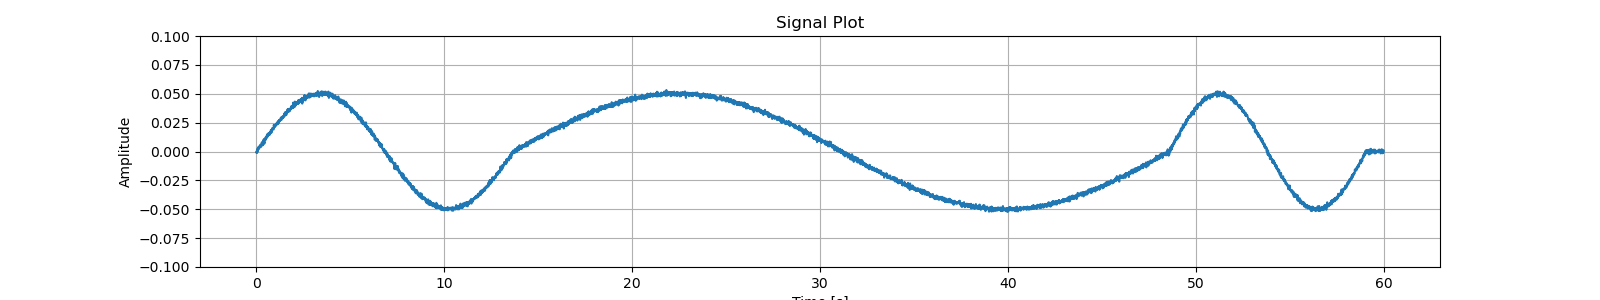

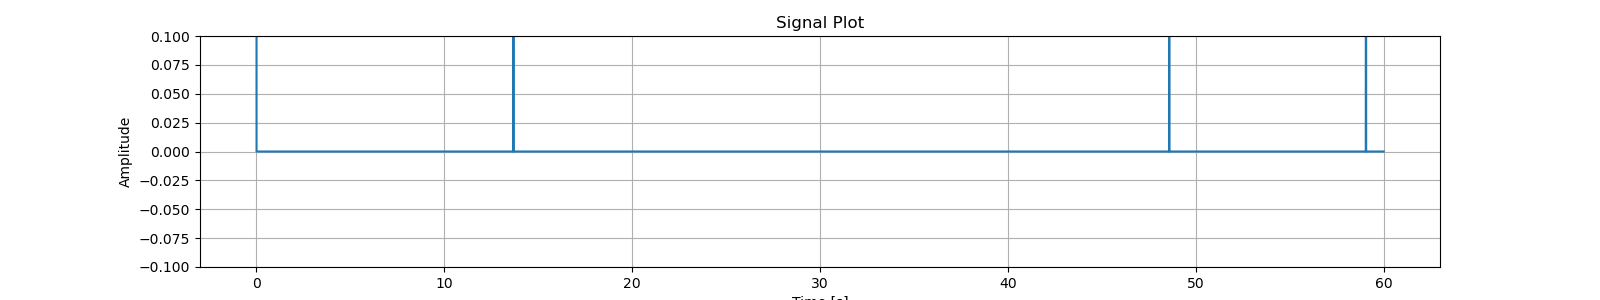

In [23]:
from matplotlib.pylab import rand, randint
from scipy import signal

# Fonction pour générer le signal souhaité
fs = 100


plt.close('all')

def calculate_tempo_synth(onset, window_size=8, bpm=True):

    onsets = onset['onsets']

    if onsets.size < window_size:
        return None
    
    if bpm:
        # Calcul des intervalles et conversion en tempi (BPM)
        intervals = 60.0 / np.diff(onsets)
    else:
        intervals = np.diff(onsets)

    
    # Calcul de la moyenne glissante des tempi
    tempi = np.convolve(intervals, np.ones(window_size)/window_size, mode='valid')
    tempo = np.mean(tempi)

    # Calcul des écarts par rapport à la moyenne glissante
    deviations = intervals[(window_size-1):] - tempo

    print(deviations)
    return tempo, deviations, onsets[(window_size):]

def onset_to_sig_synth(onset,signal_t:pd.Series=None,fs=100,value=1.0):
    filtered = onset

    '''
        signal_t : Serie, on sait où commence la serie de data 
    '''

    #si pas d'onset correspondant
    if filtered.size == 0:
        return None
    
    signal_firstidx = 0
    
    if(signal_t is not None):
        duration = len(signal_t) #samples
        signal_firstidx = round(signal_t.reset_index(drop=True)[0] // 10) # * fs / (ms->s = 1000)
    else:
        duration = int(filtered['onset'].max() * fs + 1) #secondes max * échantillon par seconde
    
    # Créer un signal de zéros
    signal = np.zeros(duration)
    
    for idx in filtered['onsets']:
        onset_index = round(idx * fs) - signal_firstidx
        if onset_index < duration:
            signal[onset_index] = value
    
    return signal

def synthetic_signal( signal_type, amplitude, frequency : float=0.0, duty=0.5, decay=1.0, noise_level=0.0,fs=fs, duration=60, freq_variation_rate=0.0, freq_bounds=(0, 10), seed=None):

    t = np.linspace(0, duration, int(fs*duration), endpoint=False)
    
    np.random.seed(seed)  # Fixer la seed pour la reproductibilité

    frequencies = np.full(t.shape, frequency)

    # Variation de la fréquence
    if frequency is not None and 0 < freq_variation_rate <= 1:
        # frequencies = frequency + freq_variation_rate * np.sin(2 * np.pi * np.random.uniform(freq_bounds[0], freq_bounds[1], size=t.shape)) #???
        num_random_values = int(len(t) * freq_variation_rate)
        random_indices = np.random.choice(len(t), size=num_random_values, replace=False)
        random_values = np.random.uniform(freq_bounds[0], freq_bounds[1], size=num_random_values)
        frequencies[random_indices] = random_values

    print("signal:freq",frequencies,"+/-",np.std(frequencies))

    if signal_type == 'sine':
        signal_wave = np.zeros_like(t)
        i = 0
        cumulative_phase = 0  # Initialize cumulative phase
        while i < len(t):
            period_samples = int(fs / frequencies[i])  # Period in number of samples
            if i + period_samples < len(t):
                for j in range(period_samples):
                    if i + j < len(t):  # Check to avoid indexing beyond the last element
                        # Calculate phase increment
                        phase_increment = 2 * np.pi * frequencies[i] / fs
                        signal_wave[i + j] = amplitude * np.sin(cumulative_phase)
                        cumulative_phase += phase_increment
            i += period_samples
    elif signal_type == 'square':
        signal_wave = np.zeros_like(t)
        i = 0
        while i < len(t):
            period_samples = int(fs / frequencies[i])  # Period in number of samples
            high_samples = int(period_samples * duty)
            if i + period_samples < len(t):
                signal_wave[i:i + high_samples] = amplitude
                signal_wave[i + high_samples:i + period_samples] = 0
            i += period_samples
    elif signal_type == 'triangle':
        signal_wave = np.zeros_like(t)
        i = 0
        while i < len(t):
            period_samples = int(fs / frequencies[i])  # Period in number of samples
            high_samples = int(period_samples * duty)
            low_samples = period_samples - high_samples

            if i + period_samples < len(t):
                signal_wave[i:i + high_samples] = np.linspace(0, amplitude, high_samples)
                signal_wave[i + high_samples:i + period_samples] = np.linspace(amplitude, 0, low_samples)
            else:
                remaining_samples = len(t) - i
                if remaining_samples <= high_samples:
                    signal_wave[i:i + remaining_samples] = np.linspace(0, amplitude, remaining_samples)
                else:
                    signal_wave[i:i + high_samples] = np.linspace(0, amplitude, high_samples)
                    signal_wave[i + high_samples:len(t)] = np.linspace(amplitude, 0, remaining_samples - high_samples)
            
            i += period_samples
    elif signal_type == 'exponential':
        signal_wave = np.zeros_like(t)
        period_samples = fs / frequencies  # Période en nombre d'échantillons
        i = 0
        while i < len(t):
            period = int(period_samples[i])
            half_period = period // 2
            if i + period < len(t):
                signal_wave[i:i + half_period] = amplitude * np.exp(-decay * np.linspace(0, 1, half_period))
                signal_wave[i + half_period:i + period] = amplitude * np.exp(-decay * np.linspace(0, 1, period - half_period))[::-1]
            i += period
    elif signal_type == 'onset':
        signal_wave = np.zeros_like(t)
        period_samples = fs / frequencies  # Période en nombre d'échantillons
        i = 0
        while i < len(t):
            onset_index = int(i)
            if onset_index < len(t):
                signal_wave[onset_index] = amplitude
            i += int(period_samples[i])
    else:
        raise ValueError("Type de signal non reconnu")
    
    if noise_level > 0:
        noise = np.random.normal(0, noise_level, signal_wave.shape)
        signal_wave += noise
    
    return t, signal_wave

# Fonction pour transformer le signal en DataFrame
def signal_to_df(t, signal_wave,dfname):
    df = pd.DataFrame({
        't': t,
        dfname: signal_wave
    })
    return df

def generate_onset(frequency:float=0.0, freq_variation_rate=0.0, freq_bounds=(0, 10), seed=None,fs=fs, duration=60, amplitude=1.0):
    t = np.linspace(0, duration, int(fs*duration), endpoint=False)
    
    np.random.seed(seed)  # Fixer la seed pour la reproductibilité

    frequencies = np.full(t.shape, frequency)

    # Variation de la fréquence
    if frequency is not None and 0 < freq_variation_rate <= 1:
        num_random_values = int(len(t) * freq_variation_rate)
        random_indices = np.random.choice(len(t), size=num_random_values, replace=False)
        print(frequency,freq_bounds)
        random_values = np.random.uniform(freq_bounds[0], freq_bounds[1], size=num_random_values)
        frequencies[random_indices] = random_values

    print("onset:freq",frequencies,"+/-",np.std(frequencies))
    
    onsets = []
    period_samples = fs / frequencies  # Période en nombre d'échantillons
    i = 0
    while i < len(t):
        onset_index = int(i)
        if onset_index < len(t):
            onsets.append(t[onset_index])
        i += int(period_samples[i])
    
    # Transformer les onsets en DataFrame
    df_onsets = pd.DataFrame({
        'onsets': onsets
    })
    
    return df_onsets
    


seed = randint(0,100)

fo = 1/10
fa = 1/10
fb = 1/2

df = 1/10 #mauvaise idée le nom

f_rate = 1


# signal_t, signal_wave = synthetic_signal('exponential', amplitude=0.000001, decay=3,frequency=1/3, noise_level=0.000,freq_variation_rate=0.1,freq_bounds=(0.2,0.4),seed=seed)
signal_t,signal_wave = synthetic_signal('sine', amplitude=.05,frequency=fa, noise_level=0.0,freq_variation_rate=f_rate,freq_bounds=(fa-df,fa+df),seed=seed)

# signal_wave += synthetic_signal('sine', amplitude=0.05, decay=3,frequency=1/2, noise_level=0.0,freq_variation_rate=0.1)[1]
signal_wave += synthetic_signal('exponential', amplitude=0.0, decay=100,frequency=fb, noise_level=0.001,freq_variation_rate=f_rate,freq_bounds=(fb-df,fb+df),seed=seed)[1]
# signal_wave += synthetic_signal('triangle', amplitude=0.03, duty=0.2,frequency=fb, noise_level=0.001,freq_variation_rate=f_rate,freq_bounds=(fb-0.5,fb+0.5),seed=seed)[1]

onset = generate_onset(amplitude=0.1,frequency=fo,freq_variation_rate=f_rate,freq_bounds=(fo-df,fo+df),seed=seed )


df = signal_to_df(signal_t,signal_wave,'intensity')

plot_signal(df['t'],df['intensity'],ylim=(-0.1,0.1))


# signal_t, signal_wave = synthetic_signal('onset', amplitude=0.1, decay=2,frequency=fo,freq_variation_rate=0.001,freq_bounds=(fo-0.1,fo+0.1),seed=seed )
# df = signal_to_df(signal_t,signal_wave,'onsets')


onset = onset_to_sig_synth(onset,df['t'])

plot_signal(df['t'],onset,ylim=(-0.1,0.1))


1.0 (0.09999999999999998, 1.9)
onset:freq [1.        1.        1.        ... 1.        1.        1.1442731] +/- 0.11818080611267812
[0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491
 0.00483491 0.00483491 0.00483491 0.00483491 0.00483491]


interactive(children=(FloatSlider(value=60.0, description='fa', max=240.0, min=40.0), FloatSlider(value=1.0, d…

interactive(children=(Checkbox(value=True, description='Center Signal'), RadioButtons(description='Filter Type…

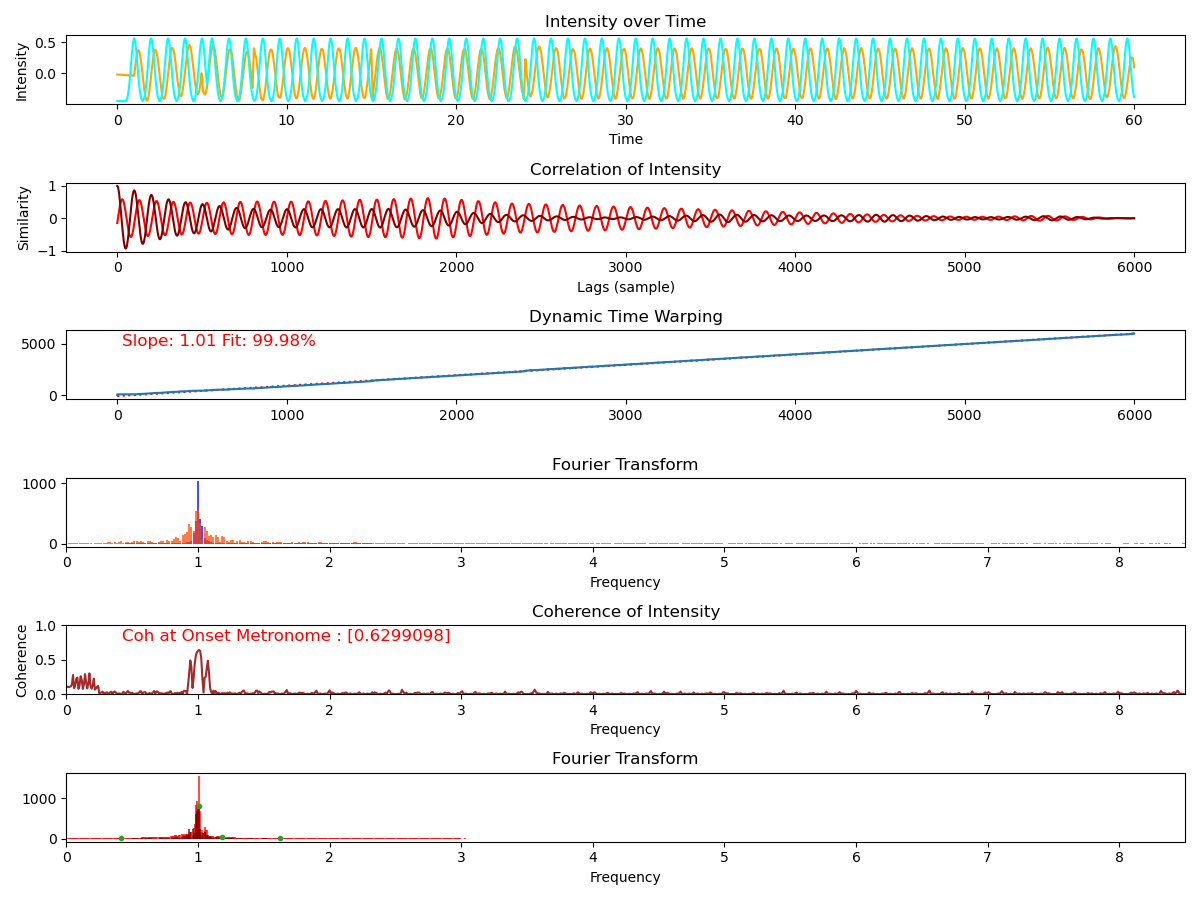

In [140]:
from cProfile import label
from ctypes import alignment

import scipy.stats as st

# seed = randint(0,100)
seed = 32

fo = bpm2freq(60.0)
fa = bpm2freq(60.0)
fb = 1.0

ampa =0.4
ampb =0.05

f_ratea = 1/20 #coefficient issu du musicien
f_rateb = 0 #coefficient issu du musicien
f_rateo = 1/21  #coefficient issu du placement des onsets et du musicien

f_bound = 0.9 # variation issue du musicien

# ~ augmentation de 50% une fois sur 10 (basé sur les stats)

# signal_t,signal_wave = synthetic_signal('sine', amplitude=ampa, decay=3,frequency=fa, noise_level=0.01,freq_variation_rate=f_ratea,freq_bounds=(fa-f_bound,fa+f_bound),seed=seed)
# signal_wave += synthetic_signal('sine', amplitude=ampb,frequency=fb,freq_variation_rate=f_rateb,freq_bounds=(fb-f_bound,fb+f_bound),seed=seed)[1]
# signal_wave += synthetic_signal('exponential', amplitude=0.5,duty=0.1,frequency=fb/3,freq_variation_rate=f_rateb,freq_bounds=(fb/3-f_bound+0.3,fb/3+f_bound+0.7),seed=seed)[1]
# signal_wave += synthetic_signal('square', amplitude=0.1,duty=0.7,frequency=1.7,freq_variation_rate=f_rateb,freq_bounds=(1.7-f_bound,1.7+f_bound),seed=seed)[1]

# signal_t,signal_wave = synthetic_signal('sine', amplitude=0.1, decay=3,frequency=fa, noise_level=0.0,freq_variation_rate=f_rate,freq_bounds=(fa-f_bound,fa+f_bound),seed=seed)
# signal_wave += synthetic_signal('exponential', amplitude=0.05, decay=3,frequency=fb, noise_level=0.001,freq_variation_rate=f_rate,freq_bounds=(fb-0.1,fb+0.1),seed=seed)[1]

onset = generate_onset(amplitude=2,frequency=fo,freq_variation_rate=f_rateo,freq_bounds=(fo-f_bound,fo+f_bound),seed=seed )

# df = signal_to_df(signal_t,signal_wave,'intensity')

# print(df['intensity'].size)


tempo,deviations,_ = calculate_tempo_synth(onset,window_size=8,bpm=False)  or (None,None,None)
onset_sig = onset_to_sig_synth(onset,df['t'],value=1.0)

#pas d'onset
if onset_sig is None:
    print("Warning : No Onset")


plt.close('all')

FREQUENCY = fs = 100 #Hz

fig, (ax_filtered_df, ax_corr,ax_dtw,ax_dft,ax_coherence,ax_period) = plt.subplots(6, 1, figsize=(12, 9))


def update_plot(filtered_df,phased_onset,autocorr_tuple,corr_tuple,dft_tuple,coherence_tuple,period_tuple):
    global df,onset_sig

    # [l.remove() for l in ax_a.lines]
    ax_filtered_df.clear()
    ax_filtered_df.plot(df['t'], filtered_df, label='Signal filtré', color='orange')
    ax_filtered_df.plot(df['t'], phased_onset, label='Signal onset', color='cyan')
    ax_filtered_df.set_title('Intensity over Time')
    ax_filtered_df.set_xlabel('Time')
    ax_filtered_df.set_ylabel('Intensity')

    ax_dft.clear()
    fftonset = ax_dft.stem(dft_tuple[1][0],dft_tuple[1][1],linefmt="blue",markerfmt=" ",basefmt=" ",label="dft onset")
    fftsig = ax_dft.stem(dft_tuple[0][0],dft_tuple[0][1],linefmt="orangered",markerfmt=" ",basefmt=" ",label="dft signal")
    ft_res = dft_tuple[0][0][1] - dft_tuple[0][0][0]
    # peaks, peaks_info = signal.find_peaks(dft_tuple[0][1],height=1.0,threshold=(0.2,None),prominence=(1.0,None),width=(0.03/ft_res,0.3/ft_res),distance=0.2/ft_res)
    # ax_dft.plot(dft_tuple[0][0][peaks],dft_tuple[0][1][peaks],".")
    plt.setp(fftsig, 'alpha', 0.7)
    plt.setp(fftonset, 'alpha', 0.7)
    ax_dft.set_title('Fourier Transform')
    ax_dft.set_xlabel('Frequency')
    ax_dft.set_ylabel('')
    # ax_dft.set_xscale('log')
    # ax_dft.set_yscale('log')
    ax_dft.set_xlim(0, 8.5)


    ax_corr.clear()
    ax_corr.plot(corr_tuple[0],corr_tuple[1],1,color="red",label='cross-correlation')
    ax_corr.plot(autocorr_tuple[0],autocorr_tuple[1],1,color="maroon",label='auto-correlation')
    ax_corr.set_title('Correlation of Intensity')
    ax_corr.set_xlabel('Lags (sample)')
    ax_corr.set_ylabel('Similarity')

    ax_coherence.clear()
    ax_coherence.plot(coherence_tuple[0],coherence_tuple[1],color="brown")
    # peaks, _ = signal.find_peaks(coherence_tuple[1],height=max(coherence_tuple[1])/4)
    # ax_coherence.plot(coherence_tuple[0][peaks],coherence_tuple[1][peaks],".")
    ax_coherence.set_title('Coherence of Intensity')
    ax_coherence.set_xlabel('Frequency')
    ax_coherence.set_ylabel('Coherence')
    # ax_coherence.set_xscale('log')
    ax_coherence.set_ylim([0, 1])
    ax_coherence.set_xlim(0, 8.5)
    freq_metronome = coherence_tuple[1][np.where(coherence_tuple[0] == 1.0)]
    ax_coherence.text(0.05, 0.95, f'Coh at Onset Metronome : {freq_metronome}', transform=ax_coherence.transAxes, fontsize=12, verticalalignment='top', color='red')

    ax_period.clear()
    fftonset = ax_period.stem(period_tuple[1][0],period_tuple[1][1],linefmt="red",markerfmt=" ",basefmt=" ",label="dft cross-correlation")
    fftsig = ax_period.stem(period_tuple[0][0],period_tuple[0][1],linefmt="maroon",markerfmt=" ",basefmt=" ",label="dft auto-correlation")
    ft_res = period_tuple[0][0][1] - period_tuple[0][0][0]
    peaks, peaks_info = signal.find_peaks(period_tuple[0][1],height=1.0,threshold=(0.2,None),prominence=(1.0,None),width=(0.03/ft_res,0.3/ft_res),distance=0.15/ft_res)
    ax_period.plot(period_tuple[0][0][peaks],period_tuple[0][1][peaks],".")
    plt.setp(fftsig, 'alpha', 0.7)
    plt.setp(fftonset, 'alpha', 0.7)
    ax_period.set_title('Fourier Transform')
    ax_period.set_xlabel('Frequency')
    ax_period.set_ylabel('')
    # ax_period.set_xscale('log')
    # ax_period.set_yscale('log')
    ax_period.set_xlim(0, 8.5)

    # ax_coh_period.clear()
    # ax_coh_period.plot(coh_period_tuple[0],coh_period_tuple[1],color="brown")
    # # peaks, _ = signal.find_peaks(coh_period_tuple[1],height=max(coh_period_tuple[1])/4)
    # # ax_coh_period.plot(coh_period_tuple[0][peaks],coh_period_tuple[1][peaks],".")
    # ax_coh_period.set_title('Coherence of Intensity')
    # ax_coh_period.set_xlabel('Frequency')
    # ax_coh_period.set_ylabel('Coherence')
    # # ax_coh_period.set_xscale('log')
    # ax_coh_period.set_ylim([0, 1])
    # ax_coh_period.set_xlim(0, 8.5)



    ax_dtw.clear()
    # for line in dtw(filtered_df,phased_onset,keep_internals=True).plot(type='threeway').lines:
    #  ax_dtw.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())
    alignment = dtw(filtered_df,phased_onset,keep_internals=True)
    slope, intercept = np.polyfit(alignment.index1, alignment.index2, 1)
    # ax_dtw.plot(slope * np.linspace(0,alignment.index1.size) + intercept, color='red', label=f'Linear fit: y={slope:.2f}x + {intercept:.2f}')
    x_fit = np.linspace(alignment.index1.min(), alignment.index1.max(), alignment.index1.size)
    y_fit = slope * x_fit + intercept
    ax_dtw.plot(x_fit,y_fit, color='red',ls='dotted', label=f'Linear fit: y={slope:.2f}x + {intercept:.2f}')
    ax_dtw.plot(alignment.index1,alignment.index2)

    # tolerance = 100.0
    # within_tolerance = np.abs(alignment.index2 - y_fit) <= tolerance
    # alignement_rate = np.sum(within_tolerance) / len(alignment.index2) * 100

    sst = np.sum((alignment.index2 - np.mean(y_fit))**2)
    ssr =  np.sum((alignment.index2 - y_fit)**2)
    alignement_rate = (1 - ssr/sst) * 100 # coefficient de détermination R2

    # alignement_rate = ssr/alignment.index2.size # erreur quadratique moyenne

    # ax_dtw.text(0.05, 0.95, f'Slope: {slope:.2f} Fit: {percentage_within_tolerance:.2f}%', transform=ax_dtw.transAxes, fontsize=12, verticalalignment='top', color='red')
    ax_dtw.text(0.05, 0.95, f'Slope: {slope:.2f} Fit: {alignement_rate:.2f}%', transform=ax_dtw.transAxes, fontsize=12, verticalalignment='top', color='red')
    ax_dtw.set_title('Dynamic Time Warping')



    plt.tight_layout()

    

filter_type = widgets.RadioButtons(
    options=['None', 'Lowpass', 'Highpass', 'Bandpass'],
    value='Bandpass',
    description='Filter Type:'
)

cutoff_slider = widgets.FloatSlider(
    value=0.1,
    min=0.001,
    max=fs/2-0.001,
    step=0.001,
    description='Cutoff (Hz):'
)

lh_cut_slider = widgets.FloatRangeSlider(
    value=[0.25,9],
    min=0.001,
    max=fs/2-0.001,
    step=0.001,
    description='Low Cut and High Cut (Hz):'
)

center_signal_checkbox = widgets.Checkbox(
    value=True,
    description='Center Signal'
)

onset_signal_phase_slider = widgets.IntSlider(
    value=0,
    min=-1000,
    max=1000,
    description='Onset Phase (ms)'
)

coh_nperseg_slider = widgets.IntSlider(
    # value=512,
    # value=2048,
    value=3072,
    # value=int(df['t'].size*FREQUENCY),
    # value=2**np.floor(np.log2(df['t'].size / 8)).astype(int),
    # value=2**np.floor(np.log2(df['t'].size)),
    # value=6000,
    # value = 1024,
    min=128,
    max=df['t'].size,
    step=2
)

coh_NFFT_slider = widgets.IntSlider(
    # value=512,
    # value=2048,
    value=2**14,
    # value=int(df['t'].size*FREQUENCY),
    # value=2**np.floor(np.log2(df['t'].size / 8)).astype(int),
    # value=2**np.floor(np.log2(df['t'].size)),
    # value=6000,
    # value = 1024,
    min=128,
    max=df['t'].size * 2,
    step=2
)

coh_noverlap_slider = widgets.IntSlider(
    # value = 510,
    # value = 2046,
    # value = 2**(np.log2(df['t'].size)) - 2,
    value = 3072,
    # value=512,
    min=64,
    max=df['t'].size,
    step=2
)

apodize_slider = widgets.FloatSlider(
    # value = tempo/2,
    value = tempo,
    min = 0.0,
    max = tempo
)

windows_type_selector = widgets.Dropdown(
    options=[   'gaussian', 'hann', 'hamming', 'blackmanharris',
                'exponential', 'chebwin', 'flattop', 'kaiser', 'nuttall', 'taylor'],
    value='taylor',
    # value='blackmanharris',
    # value='gaussian',
    description='apodize type:'
)

fa_slider = widgets.FloatSlider(
    # value = tempo/2,
    # value = 1,
    # min = 0.3,
    # max = 8.5
    value = 60,
    min = 40,
    max = 240
)
fo_slider = widgets.FloatSlider(
    # value = tempo/2,
    value = 1,
    min = 0.3,
    max = 8.5
)
farate_slider = widgets.FloatSlider(
    # value = tempo/2,
    value = 0.0,
    min = 0,
    max = 1
)
forate_slider = widgets.FloatSlider(
    # value = tempo/2,
    value = 0.0,
    min = 0.0,
    max = 1
)
fbound_slider = widgets.FloatSlider(
    # value = tempo/2,
    value = 0.0,
    min = 0.0,
    max = 1
)


@widgets.interact(fa=fa_slider,fo=fo_slider,fbound=fbound_slider)
def update_sig(fa=1,fo=1,fbound=0):
    global df,onset_sig,tempo,deviations
    signal_t,signal_wave = synthetic_signal('sine', amplitude=ampa, decay=3,frequency=bpm2freq(fa), noise_level=0.01,freq_variation_rate=1/20,freq_bounds=(fa-fbound,fa+fbound),seed=seed)


    df = signal_to_df(signal_t,signal_wave,'intensity')

    print(freq2bpm(fa),freq2bpm(fo))

    # onset = generate_onset(amplitude=2,frequency=fo,freq_variation_rate=0,freq_bounds=(0,0),seed=seed )
    # tempo,deviations,_ = calculate_tempo_synth(onset,window_size=8,bpm=False)  or (None,None,None)
    # onset_sig = onset_to_sig_synth(onset,df['t'],value=1.0)
    
    

@widgets.interact(center=center_signal_checkbox,filter = filter_type,cutoff = cutoff_slider,lh_cut=lh_cut_slider,
                  wapodize=windows_type_selector,napodize = apodize_slider,onset_phase=onset_signal_phase_slider,
                  nperseg=coh_nperseg_slider,NFFT=coh_NFFT_slider,noverlap=coh_noverlap_slider)
def update_filter(center,filter = 'None',cutoff = 1,lh_cut=[0.6,8.0],wapodize='gaussian',napodize=0,onset_phase=0,nperseg=1024,NFFT=1024,noverlap=512):
    global df,onset_sig

    shift_value = 100
    filtered_df = shift(df['intensity'].to_numpy(),shift_value,0)
    phased_onset = center_sig(apodize(shift(onset_sig, onset_phase+shift_value,0),window_size=napodize,window_type=wapodize,fs=FREQUENCY)) 

    #filtre pour retirer les harmoniques des onsets transformé en signale : min max très large, std plus étroit, ci 98 proche de la réalité
    # print(1/(tempo+max(deviations)),1/(tempo+min(deviations)))
    # min_freq_dev  = 1/(tempo+max(deviations))
    # max_freq_dev = 1/(tempo+min(deviations))
    # print(1/(tempo+std(deviations)),1/(tempo-std(deviations)))
    # min_freq_dev  = 1/(tempo+std(deviations))
    # max_freq_dev = 1/(tempo-std(deviations))
    ci_min,ci_max = st.norm.interval(confidence=0.98, loc=np.mean(deviations), scale=st.sem(deviations))
    print(1/(tempo+ci_max),1/(tempo-ci_min))
    min_freq_dev  = 1/(tempo+abs(ci_max))
    max_freq_dev = 1/(tempo-abs(ci_min))

    filtred_phased_onset = phased_onset

    if(max_freq_dev - min_freq_dev < 0.05):
        min_freq_dev  = 1/(tempo+abs(0.05))
        max_freq_dev = 1/(tempo-abs(0.05))
    sos = sos_butter_bandpass(min_freq_dev,max_freq_dev)
    filtred_phased_onset = sos_filter(phased_onset, sos)

    if center:
        filtered_df = center_sig(filtered_df)
    
    if filter == 'Lowpass':
        sos = sos_butter_lowpass(cutoff)
        filtered_df = sos_filter(filtered_df, sos)
    elif filter == 'Highpass':
        sos = sos_butter_highpass(cutoff)
        filtered_df = sos_filter(filtered_df, sos)
    elif filter == 'Bandpass':
        sos = sos_butter_bandpass(lh_cut[0], lh_cut[1])
        filtered_df = sos_filter(filtered_df, sos)

    coh_noverlap_slider.max = coh_nperseg_slider.value -2
    coh_NFFT_slider.min = coh_nperseg_slider.value
    # coh_NFFT_slider.value = coh_nperseg_slider.value + 1
    # coh_noverlap_slider.value = coh_NFFT_slider.value-2


    autoc = autocorrelation(filtered_df)
    cc = correlation2(filtered_df,phased_onset,False,norm=True)

    # test = dft(np.array(construct_symmetric_array( autoc)))
    # print(test)

    # filtered_df = sos_filter(df['intensity'],sos_butter_highpass(cutoff))
    # update_plot(filtered_df,dft(autocorrelation(filtered_df)[1]),autocorrelation(filtered_df,True))
    # update_plot(filtered_df,[psd(filtered_df,nperseg=filtered_df.size),psd(onset_sig,nperseg=onset_sig.size)],correlation2(filtered_df,onset_sig,False),coherence(filtered_df,onset_sig))
    # update_plot(filtered_df,phased_onset,autocorrelation(filtered_df),correlation2(filtered_df,phased_onset,False,norm=True),[dft(filtered_df),dft(phased_onset)],coherence(filtered_df,phased_onset,NFFT=NFFT,noverlap=noverlap))
    update_plot(filtered_df,
                phased_onset,
                autoc,
                cc,
                [dft(filtered_df),dft(filtred_phased_onset)],
                # coherence(filtered_df,filtred_phased_onset,fs=100.0,NFFT=NFFT,noverlap=noverlap),
                signal.coherence(filtered_df,filtred_phased_onset,fs=100.0,window=wapodize,nperseg=nperseg,noverlap=noverlap,nfft=NFFT),
                [dft(construct_symmetric_array( autoc)[1]),dft(construct_symmetric_array( cc)[1])]
                )



In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

plt.close('all')

# Parameters
fs = 100  # Sampling frequency
fc = 1/5  # Carrier frequency in Hz
duration = 60  # in seconds
k = 0.5  # Modulation index, sensitivity of frequency modulation
time = np.arange(0, duration, 1/fs)
df = 0.1
fbound = (fc-df,fc+df)

np.random.seed(randint(0,100))

# Random modulating signal (noise)
# noise = np.random.normal(fbound[0],fbound[1], len(time))  # Gaussian noise
key_points_time = np.linspace(0, duration, num=)  # 20 key points
key_points_values = np.random.normal(fbound[0], fbound[1], len(key_points_time))

# Linear interpolation
linear_interp = interp1d(key_points_time, key_points_values, kind='quadratic', fill_value="extrapolate")
noise = linear_interp(time)

def low_pass_filter(signal, cutoff_hz, fs):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff_hz / nyq
    b, a = butter(1, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

filtered_noise = low_pass_filter(noise, cutoff_hz=10, fs=fs)  # 10 Hz cutoff

# Modulate the carrier frequency
instantaneous_frequency = fc + k * filtered_noise

# Generate modulated signal
theta = np.cumsum(2 * np.pi * instantaneous_frequency / fs)
modulated_signal =low_pass_filter(np.sin(theta), cutoff_hz=10, fs=fs) 

# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, filtered_noise, label="Random Modulating Signal (Noise)")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time, modulated_signal, label="Modulated Signal")
plt.legend()
plt.show()


SyntaxError: invalid syntax (722039486.py, line 21)

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

plt.close('all')

x_samples = np.arange(-10, 350, 5)
freq_samples = 0.1* np.random.normal(0.9,1.1,x_samples.shape)

x = np.arange(0, 60, 0.1)

dx = np.full_like(x, 0.1 )       # Change in x

interpolation = interp1d(x_samples, freq_samples, kind='quadratic')
freq = interpolation(x)

x_plot = (freq * dx ).cumsum()    # Cumsum freq * change in x

y = np.sin(2*np.pi*x_plot)

plt.plot(x, y, label="sin(freq(x) * x)")
plt.plot(x, freq, label="freq(x)")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming values for these variables
fs = 100  # Sampling frequency
duration = 60  # Duration in seconds
frequency = 1.0  # Base frequency in Hz
amplitude = 1.0  # Amplitude of the sine wave
freq_variation_rate = 0.05  # Variation rate, let's assume this is a scaling factor for the modulator
freq_bounds = [0.5 * frequency, 1.5 * frequency]  # Frequency bounds ±1%
t = np.linspace(0, duration, int(fs * duration))  # Time array

# Generate a smooth modulating signal
modulation_frequency = 10  # Frequency of the modulating signal
modulator = freq_variation_rate * np.sin(2 * np.pi * modulation_frequency * t)
frequencies = frequency + modulator

# Calculate cumulative phase
cumulative_phase = np.cumsum(2 * np.pi * frequencies / fs)

# Generate signal
signal_wave = amplitude * np.sin(cumulative_phase)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, signal_wave, label='Modulated Sine Wave')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Frequency Modulated Sine Wave with Controlled Variation Intensity')
plt.legend()
plt.show()

print("signal:freq", frequencies, "+/-", np.std(frequencies))


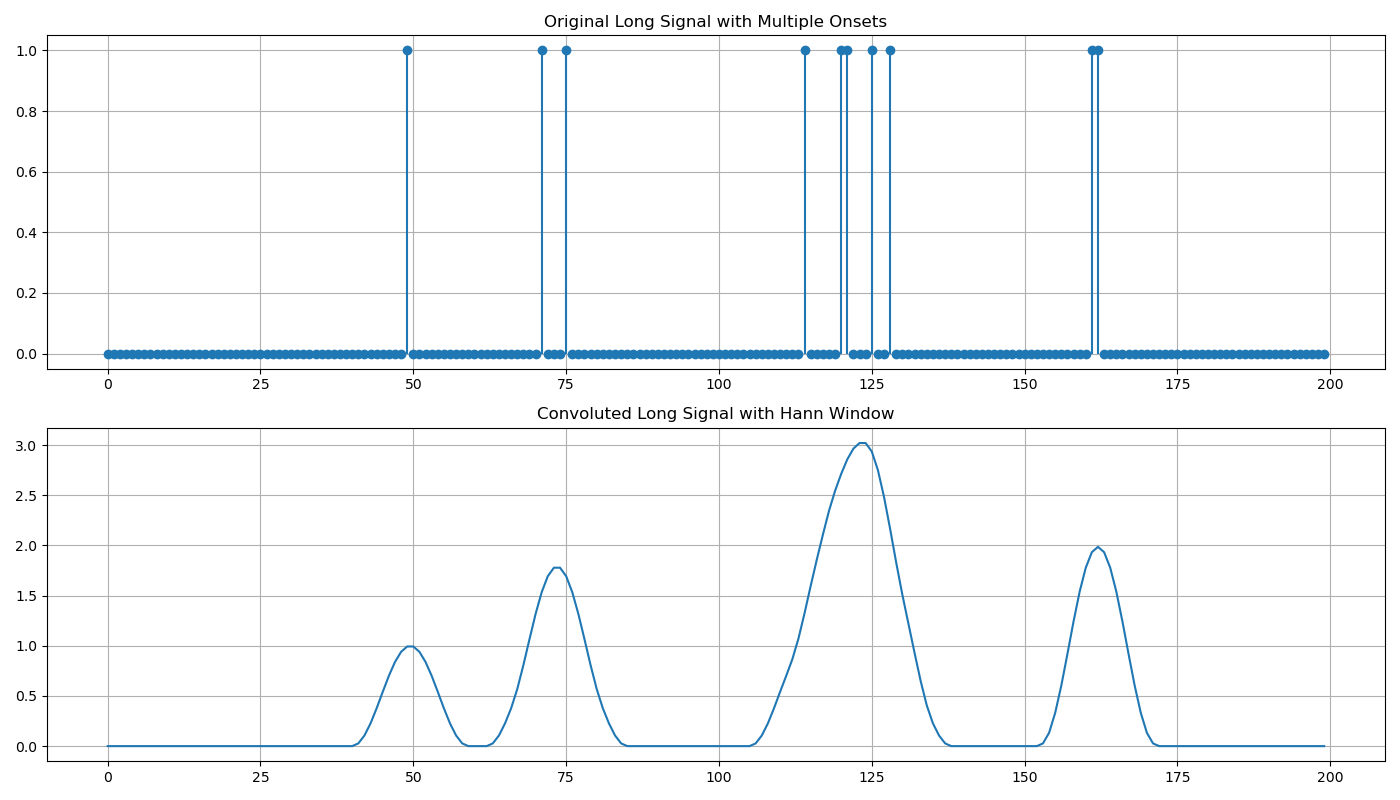

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a long signal with multiple onsets
np.random.seed(42)  # For reproducibility
long_signal = np.zeros(200)
onset_positions = np.random.choice(range(20, 180), size=10, replace=False)
long_signal[onset_positions] = 1

# Parameters
window_length = 20  # Length of the window function (choose appropriately)

# Hann window function
hann_window = np.hanning(window_length)

# Apply convolution
convoluted_signal = np.convolve(long_signal, hann_window, mode='same')

# Plot the original and convoluted signals
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.stem(long_signal, basefmt=" ")
plt.title('Original Long Signal with Multiple Onsets')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(convoluted_signal, label='Convoluted Signal')
plt.title('Convoluted Long Signal with Hann Window')
plt.grid(True)

plt.tight_layout()
plt.show()


linear regression

In [ ]:
# How to Calculate R-Squared Using SciPy
import numpy as np
from scipy.stats import linregress

# Generate fake data
np.random.seed(42)
X = 2 * np.random.rand(25, 1) 
y = 4 + 3 * X + np.random.randn(25, 1) 

# Fit a linear regression model using linregress
slope, intercept, r_value, p_value, std_err = linregress(X.flatten(), y.flatten())

# Calculate R-squared
r_squared = r_value**2
print(f'R-squared: {r_squared:.4f}')

# Returns: R-squared: 0.7919

